<br/>
<br/>

<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u>Modélisation Du Sinistre </u></h1>
<br/>
    

### Entrainement du modèle d'autoencodeur

In [7]:
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

base_Edu_cleaned est le dataFrame qui a été exporté dans le fichier préparation avant les réductions des dimensions

In [ ]:
!pip install pyarrow

In [113]:
chemin_fichier = "C:/Users/damso/Documents/data/real_claims.csv"

base1= pd.read_parquet("C:/Users/damso/Documents/data/base_Edu.parquet",engine='pyarrow')
base3= pd.read_parquet("C:/Users/damso/Documents/data/Base3.parquet",engine='pyarrow')
real_claims= pd.read_csv(chemin_fichier, sep=';', engine='python')

In [68]:
base3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Columns: 588 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(72), boolean(257), datetime64[us](3), float64(158), object(98)
memory usage: 9.5+ MB


In [114]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold

# === 1. Supprimer les colonnes dupliquées ===
def remove_duplicated_columns(df):
    duplicated_cols = df.columns[df.T.duplicated()]
    if len(duplicated_cols) > 0:
        print(f"Colonnes dupliquées supprimées : {list(duplicated_cols)}")
        df = df.drop(columns=duplicated_cols)
    return df

# === 2. Supprimer les colonnes datetime ===
def remove_datetime_columns(df):
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    if len(datetime_cols) > 0:
        print(f"Colonnes datetime supprimées : {list(datetime_cols)}")
        df = df.drop(columns=datetime_cols)
    return df

# === 3. Supprimer les colonnes déjà présentes dans base1 ===
def remove_columns_in_base1(df, base1):
    common_cols = [col for col in base1.columns if col in df.columns]
    if len(common_cols) > 0:
        print(f"Colonnes communes à base1 supprimées : {list(common_cols)}")
        df = df.drop(columns=common_cols)
    return df

# === 4. Supprimer les colonnes constantes ou quasi constantes (tous types) ===
def remove_quasi_constant_features_all_types(df, threshold=0.01):
    cols_to_drop = []
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
        if top_freq >= (1 - threshold):
            cols_to_drop.append(col)
    if cols_to_drop:
        print(f"✅ Variables constantes/quasi constantes supprimées : {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)
    return df
# === 5. Supprimer les colonnes se terminant par 'id', 'number', 'name' ou commençant par 'sd' ===
def remove_columns_by_pattern(df):
    to_drop = [
        col for col in df.columns
        if col.lower().endswith(('id', 'number', 'name')) or col.lower().startswith('sd')
    ]
    if to_drop:
        print(f"Colonnes supprimées par motif ('id', 'number', 'name' ou 'sd') : {to_drop}")
        df = df.drop(columns=to_drop)
    return df


# === 6. Supprimer les colonnes trop corrélées (numériques et catégorielles encodées) ===
def remove_highly_correlated_features(df, threshold=0.95):
    df_temp = df.copy()

    # Encodage des variables catégorielles
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df_temp[cat_cols] = encoder.fit_transform(df_temp[cat_cols])

    # Supprimer les lignes contenant des NaN pour éviter erreur de corrélation
    df_temp = df_temp.dropna()

    corr_matrix = df_temp.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    if to_drop:
        print(f"📉 Variables supprimées pour forte corrélation (> {threshold}) : {to_drop}")
        df = df.drop(columns=to_drop)

    return df

# === Pipeline complet ===
def clean_base3(base3, base1):
    df = base3.copy()
    df = remove_columns_in_base1(df, base1)
    df = remove_duplicated_columns(df)
    df = remove_datetime_columns(df)
    df = remove_columns_by_pattern(df)
    df = remove_quasi_constant_features_all_types(df, threshold=0.05)
    df = remove_highly_correlated_features(df, threshold=0.95)
    print(f"\n✅ Base finale nettoyée : {df.shape[1]} variables restantes.")
    return df

# === Application ===
base3_cleaned = clean_base3(base3, base1)


Colonnes communes à base1 supprimées : ['unique_learner_id', 'days_between_signup_and_first_activity', 'days_between_order_and_first_activity', 'first_theory_activity_date', 'days_between_first_and_last_activities', 'chapter_before_success_count', 'serie_before_success_count', 'quiz_before_success_count', 'theory_activities_total', 'weekly_study_objective', 'is_first_exam_success', 'days_between_booking_and_exam', 'nb_mistakes_first_exam', 'score_at_registration', 'score_before_exam', 'days_between_first_activity_and_exam', 'days_between_order_and_exam', 'avg_self_assessment', 'avg_self_assessment_gap', 'percentage_activities_2_3_4h_week', 'percentage_activities_5_6_7h_week', 'percentage_activities_23_0_1h_week', 'percentage_activities_2_3_4h_weekend', 'percentage_activities_5_6_7h_weekend', 'percentage_activities_23_0_1h_weekend', 'percentage_activities_8h_week', 'percentage_activities_8h_weekend', 'percentage_activities_9h_week', 'percentage_activities_9h_weekend', 'percentage_activi

In [117]:
base3_cleaned["totalClaimCount"].value_counts() 

totalClaimCount
0    2704
1     315
2      45
Name: count, dtype: int64

In [103]:
base3_cleaned.head(10)

months_between_inception  claims_nbr  total_claims_cost  \
0                       0.0           0                NaN   
1                       1.0           0                NaN   
2                       1.0           0                NaN   
3                       1.0           0                NaN   
4                       1.0           0                NaN   
5                       1.0           1              963.9   
6                       1.0           0                NaN   
7                       1.0           0                NaN   
8                       1.0           0                NaN   
9                       1.0           0                NaN   

   PC_earned_exposure  estimated_premium    job_type  is_from_aggregator  \
0            0.038251             743.38  Submission                True   
1            0.076503             729.52  Submission                True   
2            0.166667             663.46  Submission               False   
3            0.084932             944.01  Submission               False   
4            0.153005             731.13  Submission                True   
5            0.049315             735.92  Submission               False   
6            0.035519             793.44  Submission                True   
7            0.139344             468.12  Submission               False   
8            0.092896            1009.41  Submission               False   
9            0.153425             744.55  Submission               False   

   driver_count  coeff_driver_rc        package  ... SRA_Groupe  \
0             1         1.790892   Tous Risques  ...         30   
1             1         1.668281  Intermédiaire  ...         28   
2             1         1.176285   Tous Risques  ...         28   
3             1         1.818255   Tous Risques  ...         31   
4             1         2.196739  Intermédiaire  ...         28   
5             1         1.628543  Intermédiaire  ...         31   
6             1         1.195398   Tous Risques  ...         29   
7             1         1.249409  Intermédiaire  ...         32   
8             1         1.283594   Tous Risques  ...         33   
9             1         2.415731  Intermédiaire  ...         30   

  SRA_AntiDemarrage SRA_Segment SRA_NombreRapports VEH_ClasseCout RFVLX1  \
0      7 CLES SERIE          M1                  5              I     NO   
1      7 CLES SERIE           B                  5              H     NO   
2      7 CLES SERIE           B                  5              E     NO   
3      7 CLES SERIE          M1                  6              M     NO   
4      7 CLES SERIE           B                  5              G     NO   
5        NON CLASSE          M1                  5              J     NO   
6      7 CLES SERIE           B                  5              H     NO   
7      7 CLES SERIE           B                  5              G     NO   
8      7 CLES SERIE          M2                  6              O     NO   
9      7 CLES SERIE           B                  5              G     NO   

  PDVOL PROPIL1 RFBDG   slope  
0    NO      NO    NO  1.1050  
1    NO      NO   YES  1.0875  
2    NO     YES   YES  1.0875  
3    NO      NO    NO  1.0875  
4    NO      NO    NO  1.0875  
5    NO     YES    NO  1.0875  
6    NO      NO    NO  1.0125  
7    NO      NO    NO  1.0875  
8    NO      NO    NO  1.0125  
9    NO     YES   YES  1.0875  

[10 rows x 66 columns]

In [ ]:
# Vérification des types de données dans le DataFrame
print(base3_cleaned.dtypes)

# Convertir 'totalClaimCount' en entier si ce n'est pas déjà le cas
base3_cleaned["totalClaimCount"] = pd.to_numeric(base3_cleaned["totalClaimCount"], errors='coerce')

# Vérifier si la conversion a réussi
print(base3_cleaned["totalClaimCount"].dtype)  # Cela doit afficher 'int' ou 'float'

# S'assurer qu'il n'y a pas de NaN dans la colonne après la conversion
print(base3_cleaned["totalClaimCount"].isnull().sum())

# Si tu as des NaN après la conversion, tu devras décider de la façon de les gérer (par exemple, en les imputant)
base3_cleaned["totalClaimCount"].fillna(0, inplace=True)  # Par exemple, remplacer NaN par 0


### Forward selection avec LightGBM et Prédiction

In [20]:
df_forward= pd.read_csv("C:/Users/damso/Documents/data/df_briand.csv",sep=';',engine='python')
df_forward.head()

PC_earned_exposure  PER_Age        package  PER_LicenceAge PER_Profession  \
0            0.038251       22   Tous Risques               1       EMPLOYEE   
1            0.076503       21  Intermédiaire               1        STUDENT   
2            0.166667       26   Tous Risques               2       EMPLOYEE   
3            0.084932       28   Tous Risques               1       EMPLOYEE   
4            0.153005       23  Intermédiaire               0        STUDENT   

  BEH_MaritalStatus is_learner_driver  all_missings           BEH_TypeGarage  \
0         UNMARRIED                NO             1  CLOSED_PRIVATE_CAR_PARK   
1         UNMARRIED                NO             0  CLOSED_PRIVATE_CAR_PARK   
2         UNMARRIED                NO             0                    OTHER   
3         UNMARRIED                NO             1                    OTHER   
4         UNMARRIED                NO             0                    OTHER   

               BEH_Usage  ...  RFVLX1  RFVLX2 PDVOL  AMV2  CVH1  CVH2 PROPIL1  \
0  PRIVATE_WORKING_ROUTE  ...      NO      NO    NO    NO    NO    NO      NO   
1                PRIVATE  ...      NO      NO    NO    NO    NO    NO      NO   
2  PRIVATE_WORKING_ROUTE  ...      NO      NO    NO    NO    NO    NO     YES   
3  PRIVATE_WORKING_ROUTE  ...      NO      NO    NO    NO    NO    NO      NO   
4                PRIVATE  ...      NO      NO    NO    NO    NO    NO      NO   

   RFBDG  POL_CRMMax  target_binary_has_claim  
0     NO          NO                        0  
1    YES          NO                        0  
2    YES          NO                        0  
3     NO          NO                        0  
4     NO         YES                        0  

[5 rows x 30 columns]

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# --- Préparation des données ---

# Conversion de la cible en numérique (remplacement des vides par 0)
df_forward["totalClaimCount"] = pd.to_numeric(df_forward["totalClaimCount"], errors='coerce').fillna(0)

# Définir X et y
X = df_forward.drop(columns=["totalClaimCount"])
y = df_forward["totalClaimCount"]

# Encodage des variables catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Split en respectant le déséquilibre des classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Forward Selection avec LightGBM ---

selected_features = []
remaining_features = list(X.columns)
best_score = float('inf')

def evaluate_lgbm(X_train, y_train, X_valid, y_valid, features):
    model = lgb.LGBMRegressor(
        objective='poisson',
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train[features], y_train)
    preds = model.predict(X_valid[features])
    return mean_absolute_error(y_valid, preds)

while remaining_features:
    scores_with_candidates = []
    for feature in remaining_features:
        current_features = selected_features + [feature]
        score = evaluate_lgbm(X_train, y_train, X_test, y_test, current_features)
        scores_with_candidates.append((score, feature))
    
    scores_with_candidates.sort()
    candidate_score, candidate_feature = scores_with_candidates[0]

    if candidate_score < best_score:
        selected_features.append(candidate_feature)
        remaining_features.remove(candidate_feature)
        best_score = candidate_score
        print(f"Ajout de : {candidate_feature} | MAE: {best_score:.4f}")
    else:
        print("Aucune amélioration supplémentaire, arrêt.")
        break

# --- Modèle final avec les variables sélectionnées ---

final_model = lgb.LGBMRegressor(
    objective='poisson',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

final_preds = final_model.predict(X_test[selected_features])
final_mae = mean_absolute_error(y_test, final_preds)

print(f"\nVariables sélectionnées : {selected_features}")
print(f"Final MAE : {final_mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 2144, number of used features: 1
[LightGBM] [Info] Start training from score -2.021454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 2144, number of used features: 1
[LightGBM] [Info] Start training from score -2.021454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2
[LightGBM] [Info] Number of data points in the train set: 2144, 

In [10]:
selected_features

['target_binary_has_claim',
 'PER_LicenceAge',
 'PER_Profession',
 'PROPIL1',
 'previous_insurance_months',
 'RFVLX1',
 'POL_CRMMax',
 'package']


Importance des variables (par gain) :
                     feature  importance_gain  importance_split
0    target_binary_has_claim      6209.393893                93
1             PER_LicenceAge        21.431864               540
4  previous_insurance_months         9.854440               220
2             PER_Profession         7.483881               119
7                    package         5.754715                89
6                 POL_CRMMax         4.061091                64
3                    PROPIL1         1.908151                30
5                     RFVLX1         0.602960                13


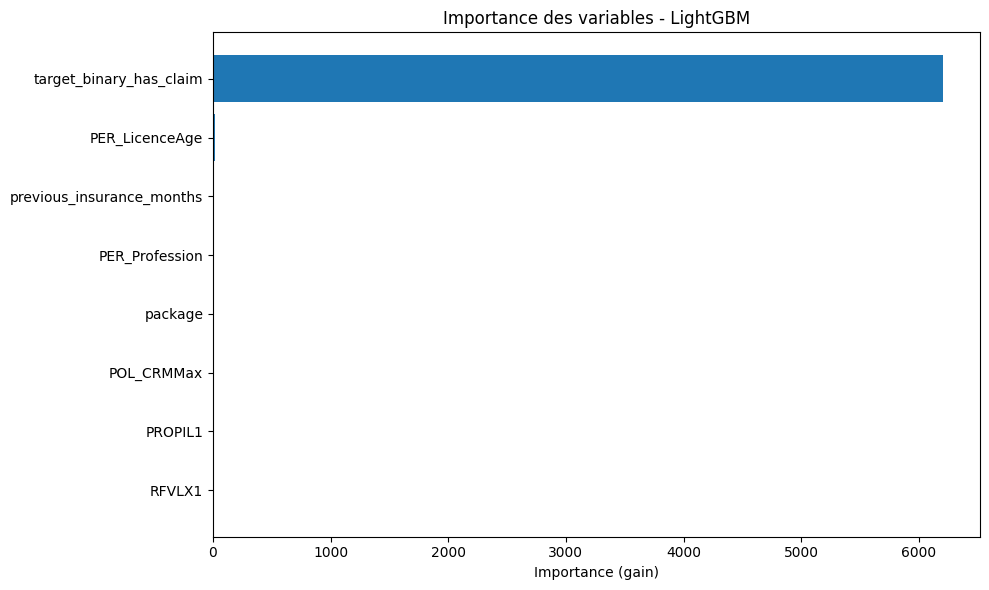

In [11]:
import matplotlib.pyplot as plt

# Importance des variables (gain ou split)
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance_gain': final_model.booster_.feature_importance(importance_type='gain'),
    'importance_split': final_model.booster_.feature_importance(importance_type='split')
}).sort_values(by='importance_gain', ascending=False)

print("\nImportance des variables (par gain) :")
print(importance_df)

# Affichage graphique (optionnel)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance_gain'])
plt.xlabel("Importance (gain)")
plt.title("Importance des variables - LightGBM")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
base = pd.read_csv("C:/Users/damso/Documents/data/base_model.csv",sep=";")

In [13]:
# Sélectionner toutes les colonnes dont le nom contient 'facteur'
facteurs = base.filter(regex='facteur', axis=1).copy()
facteurs

facteur1   facteur2   facteur3
0      1.837339   2.159837  29.258821
1     -8.336267  -0.476025  22.595692
2      1.800313   3.490731  29.080462
3     -8.192768  -1.574194  34.350758
4      1.790425  10.415071  17.511938
...         ...        ...        ...
66688 -0.389424  -1.813741   4.552617
66689  8.004194  -2.475655   3.092647
66690  3.976845  -4.419189  -0.396898
66691  6.927619  -1.338494   2.527168
66692  3.768754 -11.169271   2.933604

[66693 rows x 3 columns]

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# --- Étape 1 : Modèle principal sur totalClaimCount ---

# Cible et features principales
y = df_forward["totalClaimCount"]
X_main = df_forward

# Encodage si besoin
for col in X_main.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_main[col] = le.fit_transform(X_main[col].astype(str))

# Split
X_train_main, X_test_main, y_train, y_test = train_test_split(X_main, y, test_size=0.3, stratify=y, random_state=42)

# Modèle principal
main_model = lgb.LGBMRegressor(objective='poisson', n_estimators=100, learning_rate=0.1, random_state=42)
main_model.fit(X_train_main, y_train)

# Prédiction et résidus
y_pred_main = main_model.predict(X_test_main)
residuals = y_test - y_pred_main

# --- Étape 2 : Modèle sur les résidus avec les facteurs ---

# Variables explicatives secondaires (facteurs)
X_facteurs = facteurs[["facteur1", "facteur2", "facteur3"]].copy()

# Encodage si besoin
for col in X_facteurs.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_facteurs[col] = le.fit_transform(X_facteurs[col].astype(str))

# Même split que y_test (30% de la base)
#_, X_test_facteurs = train_test_split(X_facteurs, test_size=0.3, stratify=y, random_state=42)

# Re-indexe proprement X_facteurs pour correspondre à y
X_facteurs = X_facteurs.loc[y.index].copy()

# Ensuite, fais le split
_, X_test_facteurs, _, y_test_facteurs = train_test_split(
    X_facteurs, y, test_size=0.3, stratify=y, random_state=42
)

# Modèle sur les résidus
resid_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.1, random_state=42)
resid_model.fit(X_test_facteurs, residuals)  # X_test_facteurs correspond aux mêmes index que residuals

# Prédiction des résidus
resid_preds = resid_model.predict(X_test_facteurs)

# --- Évaluation de la prédiction des résidus ---

mae = mean_absolute_error(residuals, resid_preds)
rmse = np.sqrt(mean_squared_error(residuals, resid_preds))
r2 = r2_score(residuals, resid_preds)

print("Évaluation de la capacité prédictive des facteurs :")
print(f"MAE (résidus)   : {mae:.4f}")
print(f"RMSE (résidus)  : {rmse:.4f}")
print(f"R² (résidus)    : {r2:.4f}")

if r2 > 0.1:
    print("✅ Les facteurs expliquent une part significative des résidus.")
else:
    print("⚠️ Les facteurs ont un pouvoir explicatif faible sur les résidus.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 2144, number of used features: 27
[LightGBM] [Info] Start training from score -2.021454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

### verification de la significativité statistique pour un modèle OLS

In [22]:
import statsmodels.api as sm
import pandas as pd

# Suppose que residuals contient les erreurs du modèle LightGBM
# Et que X_test_facteurs est le DataFrame des facteurs correspondant à ces résidus

# On ajoute l'intercept (constante)
X_lift = sm.add_constant(X_test_facteurs)

# Régression linéaire des résidus sur les facteurs
lift_model = sm.OLS(residuals, X_lift).fit()

# Résumé du modèle avec p-values, coefficients, R², etc.
print(lift_model.summary())


                            OLS Regression Results                            
Dep. Variable:        totalClaimCount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.182
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.315
Time:                        22:47:04   Log-Likelihood:                 3515.0
No. Observations:                 920   AIC:                            -7022.
Df Residuals:                     916   BIC:                            -7003.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.435      0.1


Importance des facteurs dans la regression LightGBM sur les résidus :
    Feature  Importance (gain)
1  facteur2           0.029761
2  facteur3           0.024208
0  facteur1           0.020001


C:\Users\damso\AppData\Local\Temp\ipykernel_23116\2848973352.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance (gain)', y='Feature', palette='viridis')


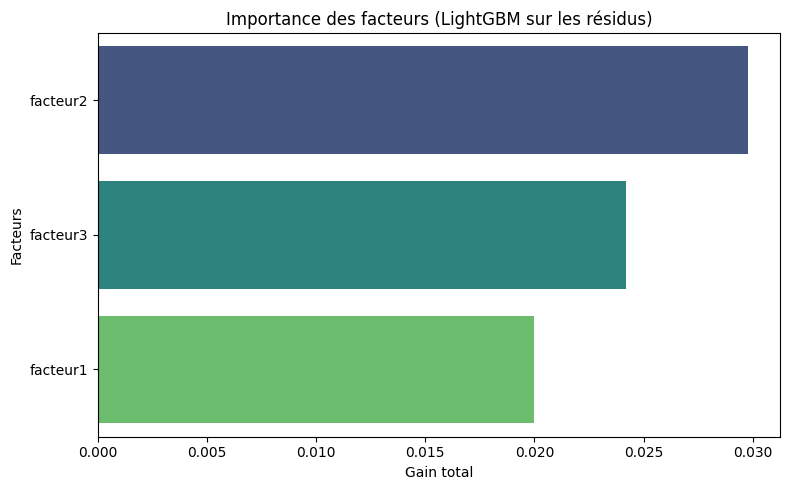

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Récupérer l'importance des facteurs
importance = resid_model.booster_.feature_importance(importance_type='gain')
features = resid_model.booster_.feature_name()

# Créer un DataFrame pour affichage
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (gain)': importance
}).sort_values(by='Importance (gain)', ascending=False)

# Affichage console
print("\nImportance des facteurs dans la regression LightGBM sur les résidus :")
print(importance_df)

# --- Visualisation ---
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance (gain)', y='Feature', palette='viridis')
plt.title("Importance des facteurs (LightGBM sur les résidus)")
plt.xlabel("Gain total")
plt.ylabel("Facteurs")
plt.tight_layout()
plt.show()


In [1]:
!pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\damso\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip setuptools wheel



  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
Using cached setuptools-80.3.1-py3-none-any.whl (1.2 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)


In [4]:
!pip install cython numpy pandas scikit-learn matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached Cython-3.0.12-cp313-cp313-win_amd64.whl.metadata (3.6 kB)
Using cached Cython-3.0.12-cp313-cp313-win_amd64.whl (2.8 MB)


In [ ]:

!pip install shap


In [3]:
import shap
import matplotlib.pyplot as plt

# Créer l'explainer SHAP à partir du modèle entraîné
explainer = shap.Explainer(resid_model, X_test_facteurs)

# Calculer les valeurs SHAP
shap_values = explainer(X_test_facteurs)

# --- Visualisation de l'importance globale ---
shap.plots.bar(shap_values, max_display=10)

# --- Visualisation détaillée (effet par observation) ---
shap.plots.beeswarm(shap_values, max_display=10)

# Facultatif : dépendance pour un facteur donné (ex: facteur2)
# shap.plots.scatter(shap_values[:, "facteur2"], color=shap_values)


ModuleNotFoundError: No module named 'shap'

In [64]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr

# --- 1. Remplacer SRA_ClasseReparationActuelle et SRA_ClasseActuelle ---
def create_is_same_SRA(df):
    df['is_same_SRA'] = (df['SRA_ClasseReparationActuelle'] == df['SRA_ClasseActuelle']).astype(int)
    df = df.drop(columns=['SRA_ClasseReparationActuelle', 'SRA_ClasseActuelle'])
    print("✅ is_same_SRA créée et anciennes variables supprimées.")
    return df

# --- 2. Garder uniquement les variables listées dans le Word ---
def keep_selected_variables(df, variables_list):
    missing_vars = [var for var in variables_list if var not in df.columns]
    if missing_vars:
        print(f"⚠️ Variables listées mais absentes de la base : {missing_vars}")
    df_reduced = df.loc[:, df.columns.intersection(variables_list)]
    print(f"✅ {len(df_reduced.columns)} variables conservées.")
    return df_reduced

# --- 3. Supprimer les colonnes datetime ---
def remove_datetime_columns(df):
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    if len(datetime_cols) > 0:
        print(f"✅ Variables datetime supprimées : {list(datetime_cols)}")
        df = df.drop(columns=datetime_cols)
    return df

# --- 4. Supprimer les variables constantes ou quasi constantes ---
def remove_quasi_constant_features(df, threshold=0.01):
    # On conserve uniquement les variables numériques pour VarianceThreshold
    df_numeric = df.select_dtypes(include=[np.number])
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df_numeric)
    mask = selector.get_support()
    reduced_numeric_df = df_numeric.loc[:, mask]
    
    # Identifier les variables supprimées
    removed_features = df_numeric.columns[~mask]
    if len(removed_features) > 0:
        print(f"✅ Variables quasi constantes supprimées : {list(removed_features)}")

    # Reconstituer un dataframe complet (numérique nettoyé + non numériques inchangées)
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    df_reduced = pd.concat([reduced_numeric_df, df_non_numeric], axis=1)
    return df_reduced

# --- 5. Supprimer la multicolinéarité forte ---
def remove_highly_correlated_features(df, threshold=0.90):
    # Travailler uniquement sur les colonnes numériques pour corrélation
    df_numeric = df.select_dtypes(include=[np.number])
    corr_matrix = df_numeric.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    if to_drop:
        print(f"✅ Variables fortement corrélées supprimées : {to_drop}")
    
    # Drop dans la base complète
    df_reduced = df.drop(columns=to_drop)
    return df_reduced

# =======================
# === Exécution concrète
# =======================

# 1. Charger la liste de variables (depuis ton fichier Word déjà lu)
variables_retenues = [
    "months_between_inception", "total_claims_cost", "PC_earned_exposure", "estimated_premium", "is_from_aggregator",
    "driver_count", "coeff_driver_rc", "package", "POL_Age", "MRH_PER_Ownership", "BEH_TypeGarage", "BEH_Usage",
    "POL_DeclaredAnnualKm", "PER_DurDetVehicle", "VEH_Age", "is_md_worst_driver", "is_deterministic_rule_ok",
    "PER_Age", "PER_Profession", "EduScore", "previous_insurance_months", "POL_Antecedent", "POL_CRM", "POL_CRMMax",
    "BEH_PastInsurerCancellation", "is_learner_driver", "totalClaimCount", "totalClaimCount_ACC", "bodilyClaimCount",
    "respClaimCount", "sd_PER_Age", "SRA_DernierPrixConnu", "SRA_PtacENkg", "SRA_PuissanceReelleMaxiCEE",
    "SRA_VitesseMaxi", "SRA_TypeFreins", "SRA_NombrePlaces", "SRA_BoiteVitesses", "SRA_Groupe", "SRA_AntiDemarrage",
    "SRA_NombreRapports", "VEH_ClasseCout", "VEH_Segment_FOCUS", "IVAN", "PDVOL", "AMV1", "AMV2", "CVH1", "CVH2",
    "PROPIL1", "slope", "modified_earned_exposure", "is_same_SRA"
]

# 2. Application sur ta base
base3_cleaned = create_is_same_SRA(base3_cleaned)
base3_cleaned = keep_selected_variables(base3_cleaned, variables_retenues)
base3_cleaned = remove_datetime_columns(base3_cleaned)
base3_cleaned = remove_quasi_constant_features(base3_cleaned, threshold=0.01)
base3_cleaned = remove_highly_correlated_features(base3_cleaned, threshold=0.90)

print("\n🎯 Nettoyage complet terminé. Base finale prête pour la modélisation !")
print(f"Dimensions finales : {base3_cleaned.shape}")


✅ is_same_SRA créée et anciennes variables supprimées.
✅ 53 variables conservées.
✅ Variables quasi constantes supprimées : ['slope']
✅ Variables fortement corrélées supprimées : ['PC_earned_exposure', 'modified_earned_exposure']

🎯 Nettoyage complet terminé. Base finale prête pour la modélisation !
Dimensions finales : (3064, 50)


In [ ]:
!pip install openpyxl

In [52]:
# Exportation vers un chemin spécifique
chemin_export = "C:/Users/damso/Documents/data/base3_var_restantes.xlsx"

base3_cleaned.to_excel(chemin_export, index=False)

print(f"Fichier exporté avec succès ici : {chemin_export}")


Fichier exporté avec succès ici : C:/Users/damso/Documents/data/base3_var_restantes.xlsx


In [16]:
# Calcul du pourcentage de valeurs manquantes
missing_percentages = real_claims.isnull().mean() * 100

# Tri décroissant pour voir d'abord les variables les plus concernées
missing_percentages = missing_percentages.sort_values(ascending=False)

# Affichage
print(missing_percentages)


claims_nbr                                       0.0
PC_earned_exposure                               0.0
PER_Age                                          0.0
facteur1                                         0.0
facteur2                                         0.0
facteur3                                         0.0
all_missings                                     0.0
PER_Profession_ARTISANS                          0.0
PER_Profession_EMPLOYEE                          0.0
PER_Profession_ENTREPRENEUR_MORE_10_EMPLOYEES    0.0
PER_Profession_FARMER_SMALL_EXPLOITATION         0.0
PER_Profession_INACTIVE                          0.0
PER_Profession_LIBERAL_PROFESSION                0.0
PER_Profession_Not Known                         0.0
PER_Profession_PROF_INTER_FCT_PUBLIC             0.0
PER_Profession_RETIRED                           0.0
PER_Profession_STUDENT                           0.0
PER_Profession_TRADERS                           0.0
BEH_MaritalStatus_COHABITEE                   

In [ ]:
import pandas as pd
import pyarrow.parquet as pq

# Chemin du fichier
chemin_fichier = "C:/Users/damso/Documents/data/df_real_claims_with_sample.parquet"

# Lire les métadonnées du fichier (sans charger les données)
parquet_file = pq.ParquetFile(chemin_fichier)

# Obtenir la liste des colonnes SANS charger le fichier
all_columns = parquet_file.schema.names

print(all_columns)
 
# Exclure la colonne problématique
columns_to_read = [col for col in all_columns if col != "first_theory_activity_date" and col != "var_Assurance19"]
 
# Lire uniquement les colonnes sélectionnées
df = pd.read_parquet(chemin_fichier, columns=columns_to_read, engine="pyarrow")


print("Fichier importé avec succès 9")

display(df)

In [ ]:
base_assu_new= pd.read_parquet("C:/Users/damso/Documents/data/df_real_claims_with_sample.parquet")
base_assu_new.info()

In [2]:
base_assu= pd.read_parquet("C:/Users/damso/Documents/data/base_assu.parquet")

base_Edu=pd.read_csv("C:/Users/damso/Documents/data/base_Edu_cleaned.csv")

base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(30000)

In [3]:
base_Edu1 = pd.read_parquet("C:/Users/damso/Documents/data/base_Edu.parquet")

columns_delete= list(set(base_Edu1.columns) - set(base_Edu.columns))
len(columns_delete)

104

In [4]:
columns_delete

['time_q75_training_count_avg',
 'serie_q75_exam_score_pct_std_avg',
 'time_q50_training_count_avg',
 'serie_q100_training_score_pct_avg_avg',
 'time_q100_training_score_pct_std_avg',
 'serie_q75_exam_score_pct_avg_avg',
 'avg_correct_answer_rate_last_7d_before_theory_exam',
 'score_at_registration',
 'time_q25_exam_score_pct_std_avg',
 'nb_distinct_instructor',
 'time_q50_theme_count_avg',
 'delay_booking_creation_annulation_days_min',
 'delay_annulation_lesson_days_max',
 'time_q75_exam_count_avg',
 'time_q100_exam_score_pct_std_avg',
 'time_q75_training_score_pct_avg_avg',
 'proportion_activities_last_3d_before_theory_exam',
 'time_q100_theme_score_pct_avg_avg',
 'nb_cancellations',
 'serie_q25_training_score_pct_std_avg',
 'serie_q100_exam_score_pct_avg_avg',
 'serie_q100_theme_score_pct_avg_avg',
 'time_q50_theme_score_pct_std_avg',
 'time_q75_exam_score_pct_std_avg',
 'delay_between_lesson_hours_max',
 'serie_q100_theme_score_pct_std_avg',
 'serie_q25_exam_score_pct_avg_avg',
 't

In [5]:


# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

Epoch 1/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0447 - val_loss: 0.0306
Epoch 2/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0299 - val_loss: 0.0302
Epoch 3/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0295 - val_loss: 0.0298
Epoch 4/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0292 - val_loss: 0.0296
Epoch 5/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0289 - val_loss: 0.0293
Epoch 6/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0287 - val_loss: 0.0291
Epoch 7/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0284 - val_loss: 0.0289
Epoch 8/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0282 - val_loss: 0.0287
Epoch 9/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0281 - val_loss: 0.0286
Epoch 10/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0279 - val_loss: 0.0285
Epoch 11/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0278 - val_loss: 0.0284
Epoch 12/50
730/730 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/st

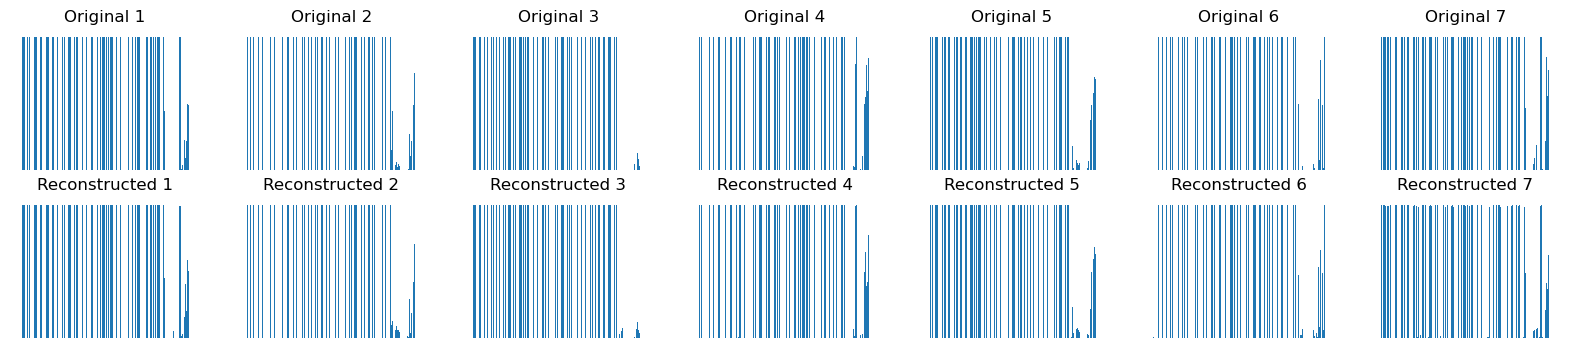

Erreur moyenne de reconstruction : 0.0280


In [33]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 3

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")

### importation de la base

In [37]:
#url = "C:/Users/damso/Documents/data/base_Edu.parquet"
df=base_assu
df.describe().T

count                mean  \
unique_learner_id                       69398.0  3754957169445755.5   
learner_id                              69398.0      1583879.345644   
days_between_signup_and_first_activity  69398.0          215.312142   
days_between_order_and_first_activity   69398.0          141.204213   
days_between_first_and_last_activities  69398.0          344.318583   
...                                         ...                 ...   
var_Assurance11                         69398.0                 0.0   
var_Assurance12                         69398.0                 0.0   
var_Assurance13                         69398.0                 0.0   
var_Assurance14                         69398.0                 0.0   
var_Assurance15                         69398.0            0.098029   

                                                          min  \
unique_learner_id                      -9222849458566410240.0   
learner_id                                              364.0   
days_between_signup_and_first_activity                    0.0   
days_between_order_and_first_activity                 -2304.0   
days_between_first_and_last_activities                    0.0   
...                                                       ...   
var_Assurance11                                           0.0   
var_Assurance12                                           0.0   
var_Assurance13                                           0.0   
var_Assurance14                                           0.0   
var_Assurance15                                           0.0   

                                                          25%  \
unique_learner_id                      -4598777253173660672.0   
learner_id                                           728669.5   
days_between_signup_and_first_activity                    0.0   
days_between_order_and_first_activity                     0.0   
days_between_first_and_last_activities                   85.0   
...                                                       ...   
var_Assurance11                                           0.0   
var_Assurance12                                           0.0   
var_Assurance13                                           0.0   
var_Assurance14                                           0.0   
var_Assurance15                                           0.0   

                                                      50%  \
unique_learner_id                       540777374478605.5   
learner_id                                      1497337.5   
days_between_signup_and_first_activity               27.0   
days_between_order_and_first_activity                 2.0   
days_between_first_and_last_activities              241.0   
...                                                   ...   
var_Assurance11                                       0.0   
var_Assurance12                                       0.0   
var_Assurance13                                       0.0   
var_Assurance14                                       0.0   
var_Assurance15                                       0.0   

                                                          75%  \
unique_learner_id                       4626702790680507392.0   
learner_id                                          2308807.0   
days_between_signup_and_first_activity                  269.0   
days_between_order_and_first_activity                   139.0   
days_between_first_and_last_activities                  489.0   
...                                                       ...   
var_Assurance11                                           0.0   
var_Assurance12                                           0.0   
var_Assurance13                                           0.0   
var_Assurance14                                           0.0   
var_Assurance15                                           0.0   

                                                          max  \
unique_learner_id                       92233268

In [38]:
# restriction de la base Edu aux variables communes aux bases ASU et EDU
# pour voir les variables qui ne sont pas communes aux deux bases dans la base asu 
columns=[] # contient les colonnes communes aux deux bases 
for column in base_Edu1.columns:
    if column in df.columns:
        columns.append(column)
#base_AE=base_AE[columns]
df.drop(columns, axis=1)


learner_id  job_number   unique_learner_id_1  \
0         2032674  5952452787  -5911177134761577615   
1          893514  6956583814   8022228279541171063   
2         2858364  1547176297   4508976855497020988   
3         1362204  3464728867   2395000730355774468   
4         1054230  1534163688   1056703805299986938   
...           ...         ...                   ...   
69393     3793717  2234733812   -872146316430440559   
69394     2775978  1784701608  -3415706474168471139   
69395     2102507  7135995107  -1958338314080661076   
69396     2862021  1866260241  -7394860117143701634   
69397     3025251  4027814965    728065250042229337   

       days_between_signup_and_first_activity_1  \
0                                           157   
1                                             7   
2                                             0   
3                                             0   
4                                            64   
...                                         ...   
69393                                         0   
69394                                       109   
69395                                       672   
69396                                       113   
69397                                         0   

       days_between_order_and_first_activity_1  \
0                                          157   
1                                            8   
2                                          -32   
3                                            0   
4                                            0   
...                                        ...   
69393                                        0   
69394                                      109   
69395                                      665   
69396                                      114   
69397                                        1   

       days_between_first_and_last_activities_1  \
0                                           195   
1                                           819   
2                                             0   
3                                           376   
4                                           691   
...                                         ...   
69393                                       372   
69394                                       270   
69395                                       613   
69396                                        76   
69397                                       595   

       chapter_before_success_count_1  serie_before_success_count_1  \
0                                   0                             0   
1                                   0                             0   
2                                   0                             0   
3                                   0                             0   
4                                   0                           109   
...                               ...                           ...   
69393                               0                            57   
69394                               0                            50   
69395                               0                            93   
69396                               0                             0   
69397                               0                             0   

       quiz_before_success_count_1  theory_activities_total_1  ...  \
0                                0                         42  ...   
1                                0                         26  ...   
2                                0                          1  ...   
3                                0                        288  ...   
4                                0                        156  ...   
...                            ...                        ...  ...   
69393                           18                        193  ...   
69394                            0                         51  ...   
69395                          321  

In [42]:
#suppression des colonnes doubles
columns_double=df.drop(columns, axis=1).drop(['learner_id',	'job_number','unique_learner_id_1','var_Assurance0', 'var_Assurance1', 'var_Assurance2', 'var_Assurance3',
       'var_Assurance4', 'var_Assurance5', 'var_Assurance6', 'var_Assurance7',
       'var_Assurance8', 'var_Assurance9', 'var_Assurance10',
       'var_Assurance11', 'var_Assurance12', 'var_Assurance13',
       'var_Assurance14', 'var_Assurance15'],axis=1).columns

df=df.drop(columns_double, axis=1)
df.head()

unique_learner_id  learner_id  job_number  \
0  -5911177134761577615     2032674  5952452787   
1   8022228279541171063      893514  6956583814   
2   4508976855497020988     2858364  1547176297   
3   2395000730355774468     1362204  3464728867   
4   1056703805299986938     1054230  1534163688   

   days_between_signup_and_first_activity  \
0                                     157   
1                                       7   
2                                       0   
3                                       0   
4                                      64   

   days_between_order_and_first_activity  \
0                                    157   
1                                      8   
2                                    -32   
3                                      0   
4                                      0   

   days_between_first_and_last_activities  chapter_before_success_count  \
0                                     195                             0   
1                                     819                             0   
2                                       0                             0   
3                                     376                             0   
4                                     691                             0   

   serie_before_success_count  quiz_before_success_count  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                         109                          0   

   theory_activities_total  ...  var_Assurance6  var_Assurance7  \
0                       42  ...               0               0   
1                       26  ...               0               0   
2                        1  ...               0               0   
3                      288  ...               0               1   
4                      156  ...               0               0   

   var_Assurance8  var_Assurance9  var_Assurance10  var_Assurance11  \
0               0               0                0                0   
1               0               0                0                0   
2               0               0                0                0   
3               3               0                0                0   
4               0               0                0                0   

   var_Assurance12  var_Assurance13  var_Assurance14  var_Assurance15  
0                0                0                0                0  
1                0                0                0                0  
2                0                0                0                0  
3                0                0                0                0  
4                0                0                0                0  

[5 rows x 489 columns]

In [43]:
# supression des lignes doubles
df = df.drop_duplicates()
df.shape

(66692, 489)

In [44]:
df.columns

Index(['unique_learner_id', 'learner_id', 'job_number',
       'days_between_signup_and_first_activity',
       'days_between_order_and_first_activity',
       'days_between_first_and_last_activities',
       'chapter_before_success_count', 'serie_before_success_count',
       'quiz_before_success_count', 'theory_activities_total',
       ...
       'var_Assurance6', 'var_Assurance7', 'var_Assurance8', 'var_Assurance9',
       'var_Assurance10', 'var_Assurance11', 'var_Assurance12',
       'var_Assurance13', 'var_Assurance14', 'var_Assurance15'],
      dtype='object', length=489)

In [45]:
# on supprime les variables qui ont été supprimer dans la base edu, ainsi que les variables inutiles
df_new=df.drop(columns_delete + ["unique_learner_id","learner_id","job_number","first_theory_activity_date",'unique_learner_id_1'], axis=1)


In [46]:
print(df_new.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(df_new.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(df_new.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(df_new.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

24  variables de type int ont des valeurs manquantes
24  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


In [47]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=df_new.select_dtypes("boolean").columns
for col in colboo:
    df_new[col] = encode_column_with_na(df_new[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories

In [48]:
miss_quant=df_new.select_dtypes(include=["int","float"]).isnull().sum()/len(df_new)
miss_quant[miss_quant>0.20].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [49]:
#imputation par la médiane
col=df_new.select_dtypes(exclude='category').columns
df_new[col] = df_new[col].fillna(df_new[col].median())

In [50]:
var_assurance=['var_Assurance0', 'var_Assurance1', 'var_Assurance2', 'var_Assurance3',
       'var_Assurance4', 'var_Assurance5', 'var_Assurance6', 'var_Assurance7',
       'var_Assurance8', 'var_Assurance9', 'var_Assurance10',
       'var_Assurance11', 'var_Assurance12', 'var_Assurance13',
       'var_Assurance14', 'var_Assurance15']

### Projection des variables dans l'espace latent

In [51]:
#on duplique l'observation pour qu'il n'y ait pas d'erreur lors de la division des données en données d'entrainement et données de test car la 
# stratification voudrait au moins deux observations par classe
df_duplicate = df_new[df_new["var_Assurance2"]==3]  # Sélection des lignes à dupliquer
df_new = pd.concat([df_new, df_duplicate], ignore_index=True)
df_new.shape

(66693, 380)

In [52]:
# traitement des données de la base ASU en entrée du modèle

X_to_predict= df_new.drop(var_assurance, axis=1)
# Récupérer les colonnes numériques et catégoriques
numerical_cols = X_to_predict.select_dtypes(include=['int', 'float']).columns
categorical_cols = X_to_predict.select_dtypes(include=['category', 'object','boolean']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(X_to_predict[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(X_to_predict[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# construction du code latent pour la base ASU, projection dans l'espace latent de l'auto encodeur construit précédemment
encoded_imgs = encoder.predict(final_data)


2085/2085 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step


### **Prédiction du risque corporel**

In [57]:
#construction de la nouvelle base
nom_facteur=["facteur{}".format(i) for i in np.arange(1,4)]
col_to_delete = base_AE.columns.drop("first_theory_activity_date")
base = df_new.drop(col_to_delete, axis=1)
base[nom_facteur]=encoded_imgs
base.head()

var_Assurance0  var_Assurance1  var_Assurance2  var_Assurance3  \
0              80            2.75               0               0   
1               3            1.54               0               0   
2              78            1.00               0               0   
3              44            2.00               0               2   
4              91            1.88               0               0   

   var_Assurance4  var_Assurance5  var_Assurance6  var_Assurance7  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               1   
4               0               0               0               0   

   var_Assurance8  var_Assurance9  var_Assurance10  var_Assurance11  \
0               0               0                0                0   
1               0               0                0                0   
2               0               0                0                0   
3               3               0                0                0   
4               0               0                0                0   

   var_Assurance12  var_Assurance13  var_Assurance14  var_Assurance15  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   facteur1   facteur2   facteur3  
0  1.837339   2.159837  29.258821  
1 -8.336267  -0.476025  22.595692  
2  1.800313   3.490731  29.080462  
3 -8.192768  -1.574194  34.350758  
4  1.790425  10.415071  17.511938

In [59]:
 # suppression des variables constantes
base=base.drop(["var_Assurance11","var_Assurance12","var_Assurance13","var_Assurance14"],axis=1)

Etant donnée que la variable cible est une variable de comptage, on fera l'hypothèse qu'elle suit une loi discrète classique. 

In [60]:
df_new["var_Assurance2"].mean()

0.006642376261376756

In [61]:
df_new["var_Assurance2"].var()

0.007348069143468633

# exportons à présent les données que nous utiliserons pour nos modélisation

In [62]:
base.to_csv("C:/Users/damso/Documents/data/base_model.csv", index=False,header=True,sep=";")

Etant donnée que la différence entre la moyenne et la variance de cette variable est négligeable (pas de surdispersion), nous allons considéré une distribution de poisson avec une fonction de lien logarithmique pour le modèle linéaire généralisé. 

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'un GLM poisson(lisa)</u></h2>
<br/>
    

<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation d'un modèle XGBoost(briand)</u></h2>
<br/>
    

In [ ]:
base = pd.read_csv("C:/Users/damso/Documents/data/base_model.csv",sep=";")

In [24]:
base = pd.DataFrame(base)
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66693 entries, 0 to 66692
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   var_Assurance0   66693 non-null  int64  
 1   var_Assurance1   66693 non-null  float64
 2   var_Assurance2   66693 non-null  int64  
 3   var_Assurance3   66693 non-null  int64  
 4   var_Assurance4   66693 non-null  int64  
 5   var_Assurance5   66693 non-null  int64  
 6   var_Assurance6   66693 non-null  int64  
 7   var_Assurance7   66693 non-null  int64  
 8   var_Assurance8   66693 non-null  int64  
 9   var_Assurance9   66693 non-null  int64  
 10  var_Assurance10  66693 non-null  int64  
 11  var_Assurance15  66693 non-null  int64  
 12  facteur1         66693 non-null  float64
 13  facteur2         66693 non-null  float64
 14  facteur3         66693 non-null  float64
dtypes: float64(4), int64(11)
memory usage: 7.6 MB


In [25]:
base.nunique()

var_Assurance0       101
var_Assurance1       356
var_Assurance2         4
var_Assurance3         6
var_Assurance4         6
var_Assurance5         3
var_Assurance6         4
var_Assurance7         5
var_Assurance8         8
var_Assurance9         3
var_Assurance10        6
var_Assurance15        6
facteur1           66609
facteur2           66610
facteur3           66556
dtype: int64

In [26]:
# les variables var_assurance11 ... var_assurance14 sont constantes et ne contiennent que des 0
bodily=base["var_Assurance2"]
material=base["var_Assurance3"]
base=base.drop(["var_Assurance2","var_Assurance3"],axis=1)
base = base.astype(np.float64)
#base = np.asarray(base, dtype=np.float64)


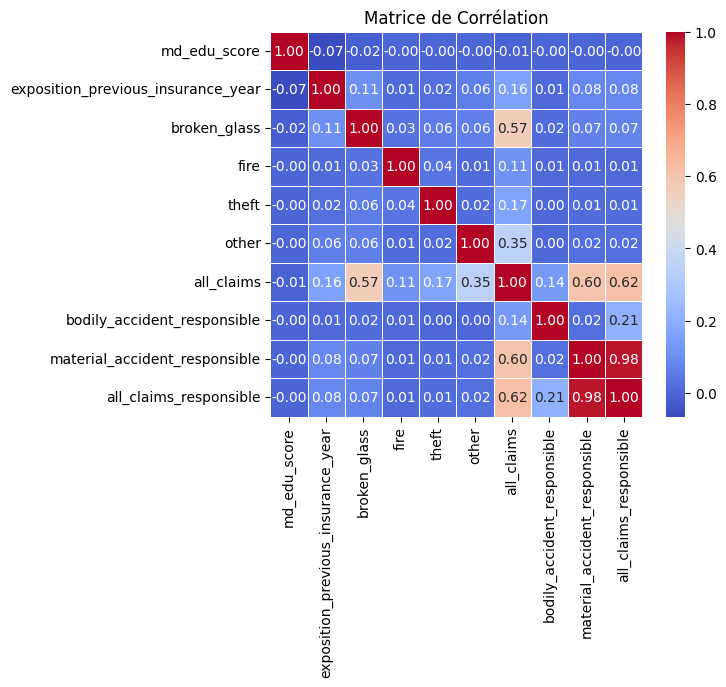

In [11]:
base_corr=base.drop(["facteur1","facteur2","facteur3"], axis=1)
base_corr.columns=["md_edu_score","exposition_previous_insurance_year","broken_glass","fire","theft","other","all_claims","bodily_accident_responsible","material_accident_responsible","all_claims_responsible"]
corr_matrix=base_corr.corr()
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

Bien que la variable var_Assurance15 (all_claims_responsible) est tres fortement correlée avec la variable var_Assurance10("material_accident_responsible") cela ne pourrait entrainer un problème de multicolinéarité dans le modèle car il est basé sur des arbres de décision. 

In [12]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(base, bodily, test_size=0.3, stratify=bodily, random_state=40)
#x_train = scaler.fit_transform(x_train)
y_train.value_counts()

var_Assurance2
0    46391
1      279
2       13
3        2
Name: count, dtype: int64

In [37]:


# Calcul de la variance de chaque ligne pour var_Assurance2
variance_var_assu2 = bodily.var()

# Calcul de la moyenne de var_Assurance2
mean_var_assu2 = bodily.mean()

# Afficher les résultats
print(f"Variance de var_Assurance2 : {variance_var_assu2}")
print(f"Moyenne de var_Assurance2 : {mean_var_assu2}")

# Comparaison
if variance_var_assu2 > mean_var_assu2:
    print("La variance est supérieure à la moyenne.")
elif variance_var_assu2 < mean_var_assu2:
    print("La moyenne est supérieure à la variance.")
else:
    print("La variance et la moyenne sont égales.")

Variance de var_Assurance2 : 0.007348069143468633
Moyenne de var_Assurance2 : 0.006642376261376756
La variance est supérieure à la moyenne.


Puisque la variance de Bodily est supérieure à sa moyenne, nous pouvons envisager ajuster le modèle avec une binomiale négative

<h3>Prédiction de bodily(var_Assurance2)</h3>

In [ ]:
!pip install xgboost

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Supposons que `base` soit déjà nettoyé et prêt à l'emploi
# On va entraîner XGBoost pour prédire `bodily`
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Entraînement XGBoost
xgb_model.fit(x_train, y_train)

# Extraire les prédictions ou probabilités comme features
xgb_features_train = xgb_model.predict_proba(x_train)
xgb_features_test = xgb_model.predict_proba(x_test)


c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:21:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Supposons que tu as déjà entraîné ton modèle XGBoost :
# model_xgb.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = xgb_model.predict(x_test)

# Accuracy globale
print("Accuracy :", accuracy_score(y_test, y_pred))

# Classification report
print("Classification Report :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Accuracy : 0.9975509796081568
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19882
           1       0.93      0.64      0.76       120
           2       1.00      0.17      0.29         6

    accuracy                           1.00     20008
   macro avg       0.98      0.60      0.68     20008
weighted avg       1.00      1.00      1.00     20008

Matrice de confusion :
[[19881     1     0]
 [   43    77     0]
 [    0     5     1]]


<p>
le modèle est parfait pour la classe 0 <br/>
1 prédiction sur 3 est fausse pour la classe 1<br/>
2 prédictions sur 3 sont fausses pour la classe 2
</p>

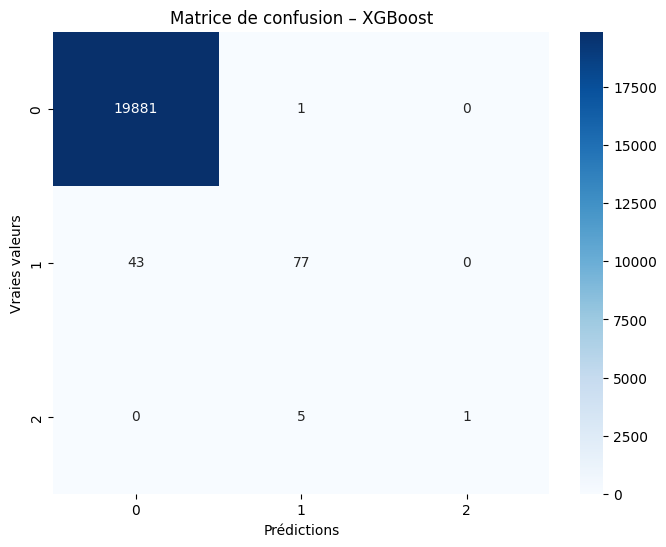

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
labels = sorted(set(y_test))  # pour s'assurer que les classes soient bien ordonnées

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion – XGBoost')
plt.show()


Le modèle xgboost construit est très performant(accuracy =0.98) pour predire la classe 0 mais moins sur les autres classe à cause du déséquilibre des classes , nous allons appliquer un GLM à ces sorties afin de réduire le biais due au déséquilibre des classes.

In [38]:


# Calcul de la variance de chaque ligne pour var_Assurance2
variance_var_assu2 = bodily.var()

# Calcul de la moyenne de var_Assurance2
mean_var_assu2 = bodily.mean()

# Afficher les résultats
print(f"Variance de var_Assurance2 : {variance_var_assu2}")
print(f"Moyenne de var_Assurance2 : {mean_var_assu2}")

# Comparaison
if variance_var_assu2 > mean_var_assu2:
    print("La variance est supérieure à la moyenne.")
elif variance_var_assu2 < mean_var_assu2:
    print("La moyenne est supérieure à la variance.")
else:
    print("La variance et la moyenne sont égales.")

Variance de var_Assurance2 : 0.007348069143468633
Moyenne de var_Assurance2 : 0.006642376261376756
La variance est supérieure à la moyenne.


In [ ]:
!pip install statsmodels

### application d'un modèle multinomiale aux sorties du modèle XGBoost

In [53]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
import pandas as pd

# Ajouter une constante (interception) à l'entrée du GLM
xgb_train_glm = sm.add_constant(xgb_features_train)
xgb_test_glm = sm.add_constant(xgb_features_test)

# Modèle multinomial (multiclasse)
glm_model = MNLogit(y_train, xgb_train_glm)
glm_result = glm_model.fit()

# Résumé statistique du modèle
print(glm_result.summary())

# Prédictions
y_pred_probs = glm_result.predict(xgb_test_glm)
y_pred = np.argmax(y_pred_probs, axis=1)



c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 17
                          MNLogit Regression Results                          
Dep. Variable:         var_Assurance2   No. Observations:                46685
Model:                        MNLogit   Df Residuals:                    46670
Method:                           MLE   Df Model:                           12
Date:                Thu, 10 Apr 2025   Pseudo R-squ.:                     nan
Time:                        12:21:15   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1848.1
Covariance Type:            nonrobust   LLR p-value:                       nan
var_Assurance2=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                   nan        nan        nan        nan         nan         nan
x1             

In [54]:

# Évaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19882
           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00         6

    accuracy                           0.99     20008
   macro avg       0.33      0.33      0.33     20008
weighted avg       0.99      0.99      0.99     20008



c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<p>
le modèle s'est éfondré et ne prédit que la première classe désormais
</p>
<br/>

### application d'une regression logistique avec pondération des classes

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Entraînement du GLM avec class_weight='balanced'
glm_model1 = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=40,
    class_weight='balanced'
)

# Fit sur les features issues de XGBoost
glm_model1.fit(xgb_features_train, y_train)

# Prédictions (classes directement)
y_pred1 = glm_model1.predict(xgb_features_test)

# Évaluation
print("Classification Report :")
print(classification_report(y_test, y_pred1))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred1))


c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19882
           1       0.93      0.64      0.76       120
           2       1.00      0.17      0.29         6

    accuracy                           1.00     20008
   macro avg       0.98      0.60      0.68     20008
weighted avg       1.00      1.00      1.00     20008

Matrice de confusion :
[[19881     1     0]
 [   43    77     0]
 [    0     5     1]]


le modèle prédit des valeurs positives représentant des comptages attendus.
Le modèle prédit très mal les classes déséquilibrés.

### Application d'une regression(GLM binomial négatif) aux sorties de XGBoost

In [ ]:

# Évaluation
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

In [41]:
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
# Ajout de constante (intercept)
xgb_train_glm = sm.add_constant(xgb_features_train)
xgb_test_glm = sm.add_constant(xgb_features_test)

# GLM multinomial (famille Binomial pour classification binaire, ou multinomiale si besoin)
glm_model = sm.GLM(y_train, xgb_train_glm, family=NegativeBinomial())

glm_result = glm_model.fit()

# Résumé du modèle
print(glm_result.summary())

# Prédictions
pred_probs = glm_result.predict(xgb_test_glm)
pred_classes = (pred_probs > 0.5).astype(int)  # ou np.argmax() pour multi-classes


c:\Users\damso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:         var_Assurance2   No. Observations:                46685
Model:                            GLM   Df Residuals:                    46680
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -496.97
Date:                Thu, 10 Apr 2025   Deviance:                       161.74
Time:                        11:47:42   Pearson chi2:                     365.
No. Iterations:                     9   Pseudo R-squ. (CS):            0.05715
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.921e+05   2.15e+06      0.089      0.9

In [44]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Prédictions continues
y_pred = glm_result.predict(xgb_test_glm)

# Évaluation
print("R² :", r2_score(y_test, y_pred))
print("RMSE(ecart-type) :", np.sqrt(mean_squared_error(y_test, y_pred)))  # remplacement ici
print("MAE(variance) :", mean_absolute_error(y_test, y_pred))


R² : 0.41744600456543257
RMSE(ecart-type) : 0.06455506114227136
MAE(variance) : 0.005275955698361583


ce modèle semble produire de bons résultats mais n'est pas adapté pour une prédiction de variables catégorielles car c'est une regression , donc les sorties ne seront pas toujours entières. Nous allons donc opter pour un modèle de classification multiclasse(MNLogit)

<b>
Puisque nous n'arrivons à améliorer la précision du modèle xgboost, nous allons faire un reéchantillonnage avant les prédictions
</b>

### Utisation du modèle après reéchantillonnage rééchantillonage SMOTE

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit
#Création du split en respectant les proportions des classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=40)

for train_index, test_index in sss.split(base, bodily):
    X_train, X_test = base.iloc[train_index], base.iloc[test_index]
    y_train, y_test = bodily.iloc[train_index], bodily.iloc[test_index]

#Vérification de la distribution des classes
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

var_Assurance2
0    0.993702
1    0.005979
2    0.000281
3    0.000037
Name: proportion, dtype: float64
var_Assurance2
0    0.993703
1    0.005997
2    0.000300
Name: proportion, dtype: float64


### **Prédiction du risque matériel(var_Assurance3)** 

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
x_train2, x_test2, y_train2, y_test2 = train_test_split(base, material, test_size=0.3, stratify=material, random_state=40)
#x_train = scaler.fit_transform(x_train)
y_train2.value_counts()

In [ ]:


# Calcul de la variance de chaque ligne pour var_Assurance2
variance_var_assu3 = material.var()

# Calcul de la moyenne de var_Assurance2
mean_var_assu3 = material.mean()

# Afficher les résultats
print(f"Variance de var_Assurance3 : {variance_var_assu3}")
print(f"Moyenne de var_Assurance3 : {mean_var_assu3}")

# Comparaison
if variance_var_assu2 > mean_var_assu2:
    print("La variance est supérieure à la moyenne.")
elif variance_var_assu2 < mean_var_assu2:
    print("La moyenne est supérieure à la variance.")
else:
    print("La variance et la moyenne sont égales.")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Supposons que `base` soit déjà nettoyé et prêt à l'emploi
# On va entraîner XGBoost pour prédire `bodily`
xgb_model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Entraînement XGBoost
xgb_model2.fit(x_train2, y_train2)

# Extraire les prédictions ou probabilités comme features
xgb_features_train2 = xgb_model2.predict_proba(x_train2)
xgb_features_test2 = xgb_model2.predict_proba(x_test2)


<br/>
<br/>

<h2 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color: #3498db"> <u> Implémentation du Zero Inflated Neuronal Network (ZINN) (deeson)</u></h2>
<br/>
    

## Construction du ZINN

In [ ]:
#!pip install torch
import pandas as pd
AssuAE=pd.read_csv('/home/onyxia/work/bas_glm.csv',sep=';')

In [ ]:
AssuAE

var_Assurance0  var_Assurance1  var_Assurance2  var_Assurance3  \
0                  80            2.75               0               0   
1                   3            1.54               0               0   
2                  78            1.00               0               0   
3                  44            2.00               0               2   
4                  91            1.88               0               0   
...               ...             ...             ...             ...   
66688              46            0.28               0               0   
66689              91            3.00               0               0   
66690              40            0.76               0               0   
66691              83            0.75               0               0   
66692              74            3.00               3               0   

       var_Assurance4  var_Assurance5  var_Assurance6  var_Assurance7  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               1   
4                   0               0               0               0   
...               ...             ...             ...             ...   
66688               0               0               0               0   
66689               0               0               0               0   
66690               0               0               0               0   
66691               0               0               0               0   
66692               1               0               0               0   

       var_Assurance8  var_Assurance9  var_Assurance10  var_Assurance11  \
0                   0               0                0                0   
1                   0               0                0                0   
2                   0               0                0                0   
3                   3               0                0                0   
4                   0               0                0                0   
...               ...             ...              ...              ...   
66688               0               0                0                0   
66689               0               0                0                0   
66690               0               0                0                0   
66691               0               0                0                0   
66692               4               1                0                0   

       var_Assurance12  var_Assurance13  var_Assurance14  var_Assurance15  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    0                0                0                0   
...                ...              ...              ...              ...   
66688                0                0                0                0   
66689                0                0                0                0   
66690                0                0                0                0   
66691                0                0                0                0   
66692                0                0                0                1   

        facteur1   facteur2   facteur3  
0       1.415548  21.419186  31.390768  
1      -3.509951  10.637355  34.872350  
2      -0.539669  23.029255  33.702557  
3      -4.133618  17.098064  46.019650  
4      -6.750637  23.080462  29.997705  
...          ...        ...        ...  
66688   8.858546   6.619362   6.504601  
66689  13.155061   1.959979   3.016555  
66690  12.955491   1.475969   0.130758  
66691  13.310589 

In [ ]:

mapping_noms = {
    f"var_Assurance{i}": nom
    for i, nom in enumerate([
        'md_edu_score', 'exposition_previous_insurance_year', 'bodily_accident', 
        'material_accident', 'broken_glass', 'fire', 'theft', 'other', 
        'all_claims', 'bodily_accident_responsible', 'material_accident_responsible', 
        'broken_glass_responsible', 'fire_responsible', 'theft_responsible', 
        'other_responsible', 'all_claims_responsible'
    ])
}

print(mapping_noms)

{'var_Assurance0': 'md_edu_score', 'var_Assurance1': 'exposition_previous_insurance_year', 'var_Assurance2': 'bodily_accident', 'var_Assurance3': 'material_accident', 'var_Assurance4': 'broken_glass', 'var_Assurance5': 'fire', 'var_Assurance6': 'theft', 'var_Assurance7': 'other', 'var_Assurance8': 'all_claims', 'var_Assurance9': 'bodily_accident_responsible', 'var_Assurance10': 'material_accident_responsible', 'var_Assurance11': 'broken_glass_responsible', 'var_Assurance12': 'fire_responsible', 'var_Assurance13': 'theft_responsible', 'var_Assurance14': 'other_responsible', 'var_Assurance15': 'all_claims_responsible'}


In [ ]:
AssuAE=AssuAE.rename(columns=mapping_noms)
AssuAE

md_edu_score  exposition_previous_insurance_year  bodily_accident  \
0                80                                2.75                0   
1                 3                                1.54                0   
2                78                                1.00                0   
3                44                                2.00                0   
4                91                                1.88                0   
...             ...                                 ...              ...   
66688            46                                0.28                0   
66689            91                                3.00                0   
66690            40                                0.76                0   
66691            83                                0.75                0   
66692            74                                3.00                3   

       material_accident  broken_glass  fire  theft  other  all_claims  \
0                      0             0     0      0      0           0   
1                      0             0     0      0      0           0   
2                      0             0     0      0      0           0   
3                      2             0     0      0      1           3   
4                      0             0     0      0      0           0   
...                  ...           ...   ...    ...    ...         ...   
66688                  0             0     0      0      0           0   
66689                  0             0     0      0      0           0   
66690                  0             0     0      0      0           0   
66691                  0             0     0      0      0           0   
66692                  0             1     0      0      0           4   

       bodily_accident_responsible  material_accident_responsible  \
0                                0                              0   
1                                0                              0   
2                                0                              0   
3                                0                              0   
4                                0                              0   
...                            ...                            ...   
66688                            0                              0   
66689                            0                              0   
66690                            0                              0   
66691                            0                              0   
66692                            1                              0   

       broken_glass_responsible  fire_responsible  theft_responsible  \
0                             0                 0                  0   
1                             0                 0                  0   
2                             0                 0                  0   
3                             0                 0                  0   
4                             0                 0                  0   
...                         ...               ...                ...   
66688                         0                 0                  0   
66689                         0                 0                  0   
66690                         0                 0                  0   
66691                         0                 0                  0   
66692                         0                 0                  0   

       other_responsible  all_claims_responsible   facteur1   facteur2  \
0                      0                       0   1.415548  21.419186   
1                      0                       0  -3.509951  10.637355   
2                      0                       0  -0.539669  23.029255   
3                      0                       0  -4.133618  17.098064   
4                      0                       0  -6.750637  23.080462   
...                  ...                     ...        ...        

In [ ]:
AssuAE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66693 entries, 0 to 66692
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   md_edu_score                        66693 non-null  int64  
 1   exposition_previous_insurance_year  66693 non-null  float64
 2   bodily_accident                     66693 non-null  int64  
 3   material_accident                   66693 non-null  int64  
 4   broken_glass                        66693 non-null  int64  
 5   fire                                66693 non-null  int64  
 6   theft                               66693 non-null  int64  
 7   other                               66693 non-null  int64  
 8   all_claims                          66693 non-null  int64  
 9   bodily_accident_responsible         66693 non-null  int64  
 10  material_accident_responsible       66693 non-null  int64  
 11  broken_glass_responsible            66693

Nous commençons ici par définir la classe ZeroInflatedNN, qui représente un modèle de réseau de
neurones zéro-inflated. Ce modèle permet de prédire à la fois la probabilité de "zéros structurels" et le taux Poisson pour les observations non-nulles, afin de mieux gérer des données où les zéros sont surreprésentés et d’améliorer l’estimation des événements pour les observations positives.

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import NegativeBinomial, Bernoulli

# Fix random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

class ZeroInflatedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ZeroInflatedNN, self).__init__()

        # Shared hidden layers
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Zero-inflation head (logistic regression)
        self.zero_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Outputs p(zero)
        )
        
        # Count head for Negative Binomial (predicts μ and r)
        self.count_head = nn.Linear(hidden_dim, 2)  # μ (mean) and r (dispersion)

    def forward(self, x):
        features = self.shared_net(x)
        
        # Zero-inflation part
        p_zero = self.zero_head(features).squeeze(-1)
        
        # Negative Binomial part
        count_params = self.count_head(features)
        mu = F.softplus(count_params[:, 0]) + 1e-4  # ensure positivity
        r = F.softplus(count_params[:, 1]) + 1e-4
        
        return p_zero, mu, r
    
    def loss(self, p_zero, mu, r, target):
        # Negative Binomial PMF (NB(y; μ, r))
        nb_dist = NegativeBinomial(total_count=r, probs=r/(r + mu + 1e-8))
        nb_pmf = torch.exp(nb_dist.log_prob(target))  # NB(y)
        
        # Zero-Inflation: π·I(y=0) + (1-π)·NB(y)
        likelihood = torch.where(
            target == 0,
            p_zero + (1 - p_zero) * nb_pmf,  # π + (1-π)·NB(0)
            (1 - p_zero) * nb_pmf             # (1-π)·NB(y)
        )
        
        return -torch.log(likelihood + 1e-8).mean()  # Negative log-likelihood

    def predict(self, x, sample=False):
        """
        Generate predictions from the ZINB model.
        
        Args:
            x: Input features
            sample: If True, sample from ZINB distribution.
                    If False, return expected value E[Y] = (1-π)*μ.
        """
        self.eval()
        with torch.no_grad():
            p_zero, mu, r = self(x)
            
            if sample:
                # Sample from Bernoulli (zero-inflation)
                is_zero = torch.rand_like(p_zero) < p_zero
                
                # Sample from Negative Binomial (counts)
                nb_dist = NegativeBinomial(
                    total_count=r,
                    probs=r / (r + mu + 1e-8)  # Avoid division by zero
                )
                counts = nb_dist.sample()
                
                # Apply zero-inflation: structural zeros replace NB samples
                predictions = torch.where(is_zero, 
                                        torch.zeros_like(counts), 
                                        counts)
            else:
                # Expected value of ZINB: E[Y] = (1-π)*μ
                predictions = (1 - p_zero) * mu
                
            return predictions.long()

In [ ]:
def train_zinn(model, X_train, y_train, X_val=None, y_val=None, epochs=100, lr=0.01, 
              verbose=True, early_stopping=False, patience=20, seed=42):
    """Train a Zero-Inflated Negative Binomial Neural Network."""
    set_seed(seed)
    device = next(model.parameters()).device
    
    # Convert data to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if X_val is not None:
        X_val = X_val.to(device)
        y_val = y_val.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//2)
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    no_improve = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        
        p_zero, mu, r = model(X_train)
        loss = model.loss(p_zero, mu, r, y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_losses.append(loss.item())

        # Validation
        if X_val is not None:
            model.eval()
            with torch.no_grad():
                p_zero_val, mu_val, r_val = model(X_val)
                val_loss = model.loss(p_zero_val, mu_val, r_val, y_val)
                val_losses.append(val_loss.item())
                scheduler.step(val_loss)
                
            if early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_state = copy.deepcopy(model.state_dict())
                    no_improve = 0
                else:
                    no_improve += 1

        if verbose and (epoch % 10 == 0 or epoch == 1 or epoch == epochs):
            log_msg = (f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | "
                      f"μ: {mu.mean().item():.2f} | r: {r.mean().item():.2f} | "
                      f"p(zero): {p_zero.mean().item():.2f}")
            if X_val is not None:
                log_msg += f" | Val Loss: {val_loss.item():.4f}"
            print(log_msg)

        if early_stopping and no_improve >= patience:
            if verbose:
                print(f"\nEarly stopping triggered at epoch {epoch}")
            model.load_state_dict(best_state)
            break

    return model, train_losses

In [ ]:
def evaluate_zinn(model, X_test, y_test, verbose=True):
    """Evaluate a trained ZINN model."""
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    model.eval()
    with torch.no_grad():
        p_zero, mu, r = model(X_test)
        y_pred_mean = (1 - p_zero) * mu
        y_pred_int = torch.round(y_pred_mean).long()
        
        test_loss = model.loss(p_zero, mu, r, y_test)
        mae = torch.mean(torch.abs(y_pred_int.float() - y_test))
        
        results = {
            'loss': test_loss.item(),
            'mae': mae.item(),
            'mean_p_zero': p_zero.mean().item(),
            'mean_mu': mu.mean().item(),
            'mean_r': r.mean().item(),
            'predictions': y_pred_int.cpu().numpy()
        }
        
        if verbose:
            print("\nEvaluation Metrics:")
            print(f"- Test Loss: {results['loss']:.4f}")
            print(f"- MAE: {results['mae']:.4f}")
            print(f"- Mean p(zero): {results['mean_p_zero']:.4f}")
            print(f"- Mean μ: {results['mean_mu']:.4f}")
            print(f"- Mean r: {results['mean_r']:.4f}")
            
            print("\nPrediction Examples:")
            for i in range(min(5, len(y_test))):
                print(f"True: {y_test[i].item():4.1f} | Pred: {y_pred_int[i].item():4d}")
        
        return results

## Application du ZINN à bodily_accident

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def prepare_zinb_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors and scaler
    """
    # 1. Feature/target selection with validation
    X = df[features].values
    y = df[target].values

    # Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Features and target must be convertible to numpy arrays")

    # 2. Preprocessing with standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 4. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': scaler
    }

    # 5. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zinb_data(
    df=AssuAE,
    features=["facteur1", "facteur2", "facteur3"],
    target="bodily_accident"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']


Data Preparation Summary:
- Training samples: 53354
- Test samples: 13339
- Feature dimension: 3
- Target range: [0, 3]
- Train zero proportion: 99.37%
- Test zero proportion: 99.37%

First 5 training samples:
Features: [-0.99  0.75 -0.29] -> Target: 0
Features: [0.4  0.43 0.03] -> Target: 0
Features: [ 2.29 -1.8  -1.85] -> Target: 0
Features: [ 0.81 -1.57 -1.71] -> Target: 0
Features: [-0.04 -0.02  0.95] -> Target: 0


Nous passons ici à l'entrainement du modèle. 

Epoch    1 | Train Loss: 0.1939 | μ: 0.73 | r: 0.67 | p(zero): 0.53


Epoch   10 | Train Loss: 0.0775 | μ: 1.01 | r: 0.42 | p(zero): 0.63
Epoch   20 | Train Loss: 0.0453 | μ: 1.69 | r: 0.18 | p(zero): 0.81
Epoch   30 | Train Loss: 0.0477 | μ: 1.98 | r: 0.13 | p(zero): 0.85
Epoch   40 | Train Loss: 0.0427 | μ: 1.76 | r: 0.18 | p(zero): 0.79
Epoch   50 | Train Loss: 0.0415 | μ: 1.58 | r: 0.23 | p(zero): 0.75
Epoch   60 | Train Loss: 0.0409 | μ: 1.60 | r: 0.23 | p(zero): 0.75
Epoch   70 | Train Loss: 0.0405 | μ: 1.67 | r: 0.21 | p(zero): 0.77
Epoch   80 | Train Loss: 0.0402 | μ: 1.68 | r: 0.21 | p(zero): 0.76
Epoch   90 | Train Loss: 0.0400 | μ: 1.67 | r: 0.22 | p(zero): 0.76
Epoch  100 | Train Loss: 0.0398 | μ: 1.68 | r: 0.22 | p(zero): 0.76


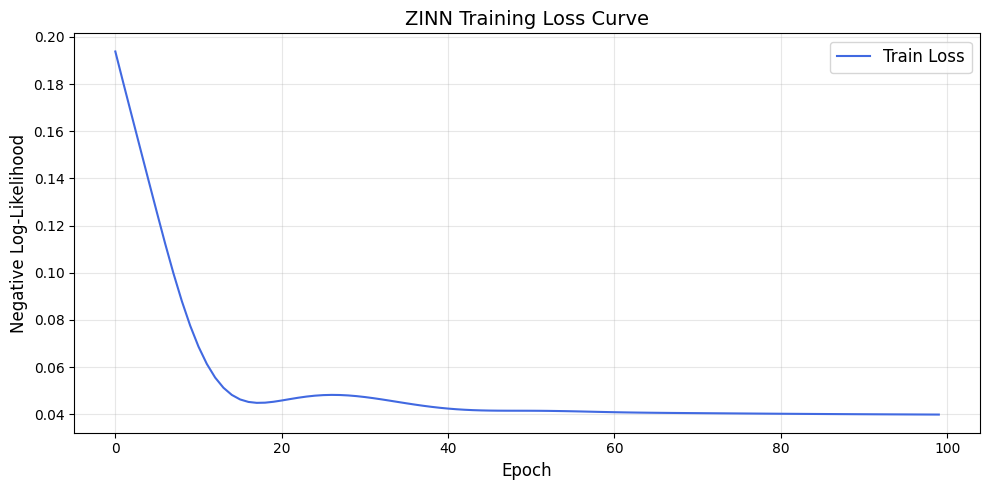


Evaluation Metrics:
- Test Loss: 0.0412
- MAE: 0.1077
- Mean p(zero): 0.7600
- Mean μ: 1.6757
- Mean r: 0.2175

Prediction Examples:
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0

Advanced Prediction Statistics:
- MAE: 0.1077
- RMSE: 0.3298
- True Zero Rate: 99.37%
- Predicted Zero Rate: 89.84%

Prediction Distribution:
  Mean: 0.10
  Std: 0.30
  Min/Max: 0/1
  Percentiles (25/50/75/90/95): [0. 0. 0. 1. 1.]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_evaluate_zinn(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZINN training and evaluation workflow.
    
    Args:
        X_train_tensor: Training features tensor
        y_train_tensor: Training targets tensor
        X_test_tensor: Test features tensor
        y_test_tensor: Test targets tensor
        hidden_dim: Hidden layer size
        epochs: Training epochs
        lr: Learning rate
        verbose: Print progress
        plot: Show training curve
        
    Returns:
        Dictionary containing model, results, and predictions
    """
    # 1. Model initialization
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN(input_dim=input_dim, hidden_dim=hidden_dim)
    
    # 2. Training with early stopping
    trained_model, train_losses = train_zinn(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    # 3. Training visualization
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZINN Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. Comprehensive evaluation
    test_results = evaluate_zinn(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    # 5. Process predictions
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    # 6. Additional metrics
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zinn(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=100,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']

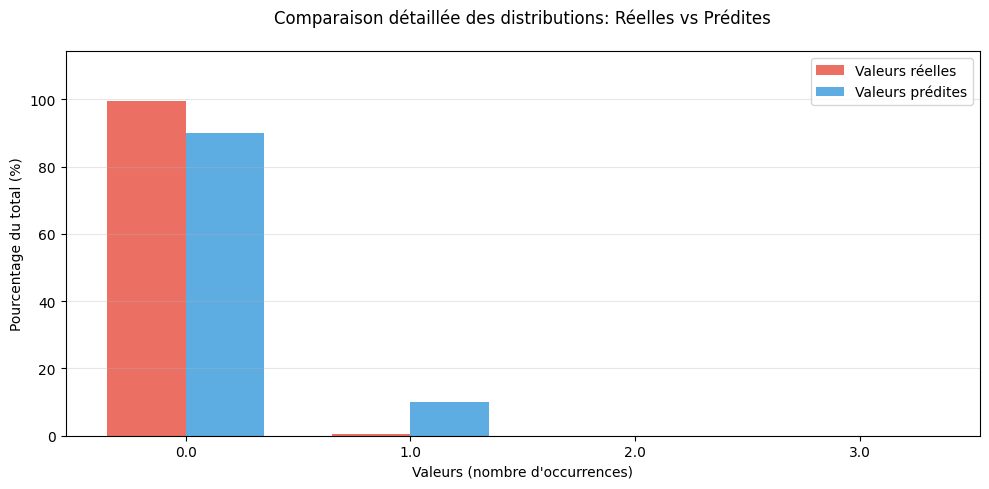


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%) 
--------------------------------------------------
0.0      |      99.37% |      89.84% |      -9.53%
1.0      |       0.58% |      10.16% |      +9.58%
2.0      |       0.04% |       0.00% |      -0.04%
3.0      |       0.01% |       0.00% |      -0.01%


In [ ]:
# 1. First ensure you have these imports at the top of your notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# 4. Get predictions and convert to numpy
with torch.no_grad():
    p_zero, mu, r = trained_model(X_test_tensor)
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()
    
    # Convert to numpy for visualization
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 5. Now run the visualization with proper variable names
plt.figure(figsize=(10, 5))

# Get value distributions using the numpy arrays
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.unique(np.concatenate([unique_vals_real, unique_vals_pred]))

# Create relative frequencies (percentages)
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# Plot settings
bar_width = 0.35
x_pos = np.arange(len(all_values))

# Plot distributions
plt.bar(x_pos - bar_width/2, 
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs réelles', 
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2, 
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs prédites', 
        color='#3498db',
        alpha=0.8)

# Add titles and labels
plt.title("Comparaison détaillée des distributions: Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre d'occurrences)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 6. Print the detailed comparison
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10}")
print("-" * 50)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}%")

/tmp/ipykernel_439800/3433444820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


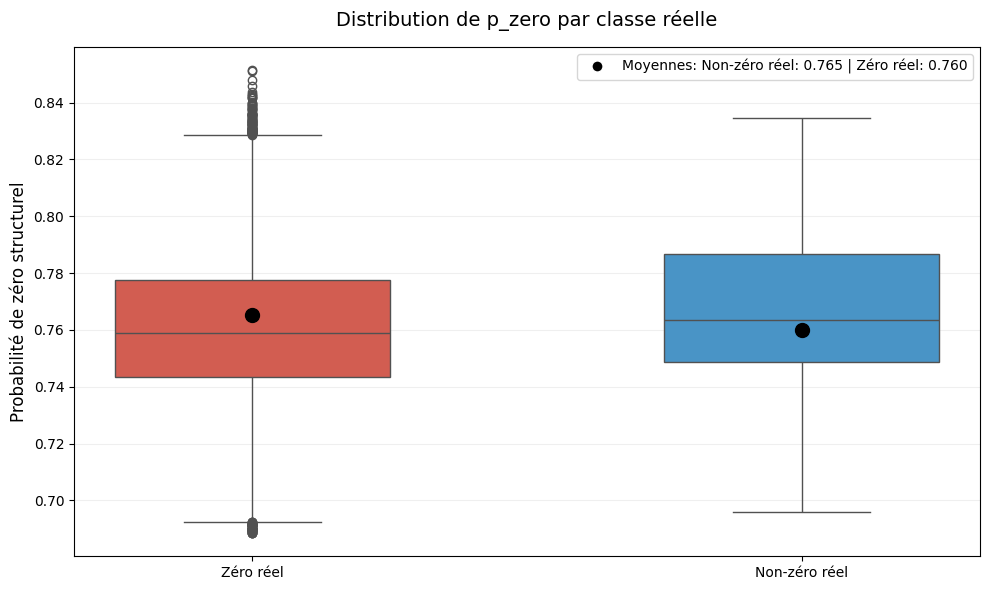


Analyse statistique de p_zero par classe:
                 count    mean     std     min     25%     50%     75%     max
Classe réelle                                                                 
Non-zéro réel     84.0  0.7654  0.0296  0.6960  0.7488  0.7635  0.7867  0.8347
Zéro réel      13255.0  0.7599  0.0278  0.6885  0.7435  0.7588  0.7775  0.8515

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.00      0.00      0.00        84
        Zéro       0.99      1.00      1.00     13255

    accuracy                           0.99     13339
   macro avg       0.50      0.50      0.50     13339
weighted avg       0.99      0.99      0.99     13339



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
with torch.no_grad():
    p_zero_test, mu_test, r_test = trained_model(X_test_tensor)
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Create DataFrame for visualization
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                palette=["#e74c3c", "#3498db"], width=0.5)

# Calculate means
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()

# Create custom legend entries
legend_entries = []
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100)
    legend_entries.append(f'{cls}: {mean:.3f}')

# Create unified legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='black', markersize=8,
                              label='Moyennes: ' + ' | '.join(legend_entries))],
           loc='upper right')

plt.title("Distribution de p_zero par classe réelle", fontsize=14, pad=15)
plt.ylabel("Probabilité de zéro structurel", fontsize=12)
plt.xlabel("")
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


# 3. Statistical summary
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 4. Classification report
from sklearn.metrics import classification_report
y_pred_zero = (p_zero_test_np > 0.5).astype(int)
y_true_zero = (y_test_np == 0).astype(int)

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                           target_names=["Non-zéro", "Zéro"]))

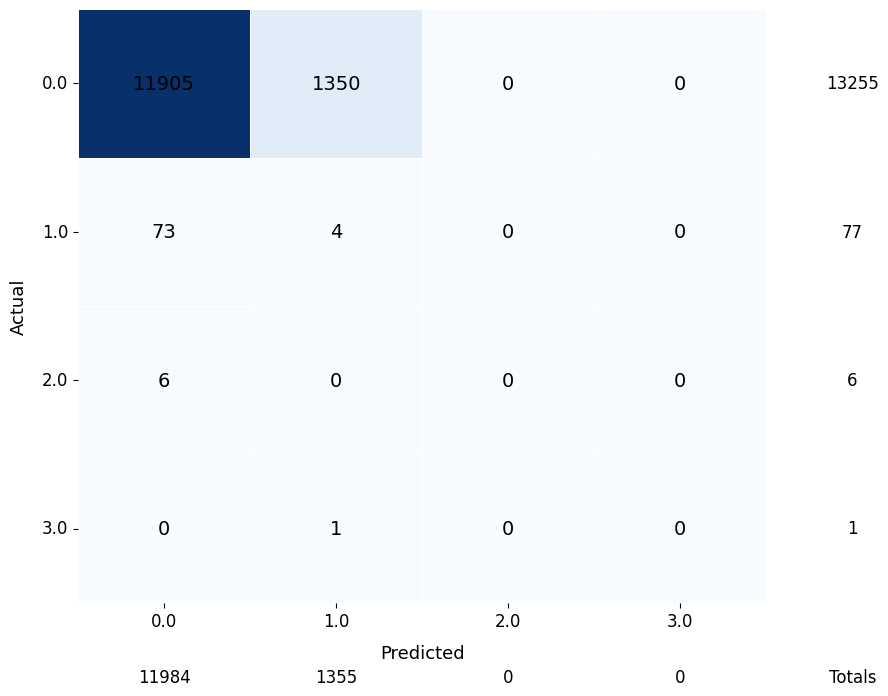


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       0.99      0.90      0.94     13255
   Class 1.0       0.00      0.05      0.01        77
   Class 2.0       0.00      0.00      0.00         6
   Class 3.0       0.00      0.00      0.00         1

    accuracy                           0.89     13339
   macro avg       0.25      0.24      0.24     13339
weighted avg       0.99      0.89      0.94     13339


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 13255      | 11984      | 11905     
1.0        | 77         | 1355       | 4         
2.0        | 6          | 0          | 0         
3.0        | 1          | 0          | 0         


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clear totals outside the matrix
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

# Add clean total labels
ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")

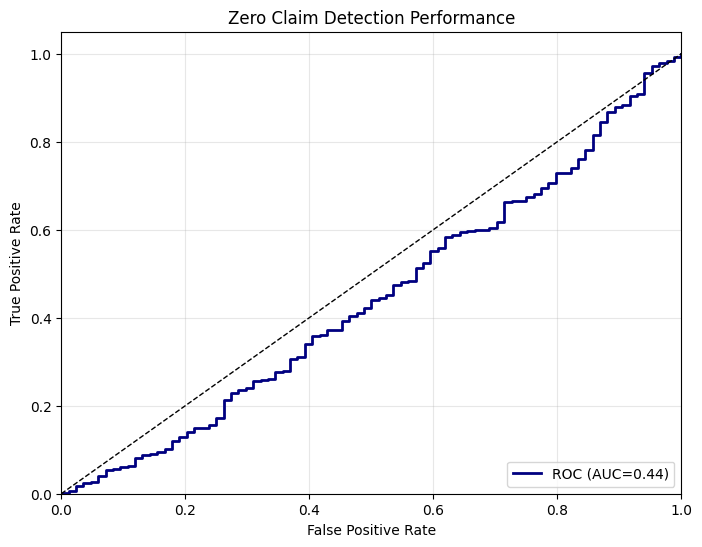

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)


plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

Notre modèle n'est pas du tout performant.

## Application à la variable material_accident

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def prepare_zinb_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors and scaler
    """
    # 1. Feature/target selection with validation
    X = df[features].values
    y = df[target].values

    # Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Features and target must be convertible to numpy arrays")

    # 2. Preprocessing with standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 4. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': scaler
    }

    # 5. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zinb_data(
    df=AssuAE,
    features=["facteur1", "facteur2", "facteur3"],
    target="material_accident"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']


Data Preparation Summary:
- Training samples: 53354
- Test samples: 13339
- Feature dimension: 3
- Target range: [0, 5]
- Train zero proportion: 85.93%
- Test zero proportion: 85.93%

First 5 training samples:
Features: [0.06 0.13 0.86] -> Target: 0
Features: [0.33 0.44 0.15] -> Target: 0
Features: [-1.4   0.95 -0.09] -> Target: 0
Features: [0.29 0.9  0.74] -> Target: 0
Features: [ 1.31 -2.01 -1.84] -> Target: 0


Epoch    1 | Train Loss: 0.5123 | μ: 0.73 | r: 0.67 | p(zero): 0.53
Epoch   10 | Train Loss: 0.4986 | μ: 0.93 | r: 0.54 | p(zero): 0.51
Epoch   20 | Train Loss: 0.4934 | μ: 1.04 | r: 0.57 | p(zero): 0.42
Epoch   30 | Train Loss: 0.4893 | μ: 1.37 | r: 0.59 | p(zero): 0.29
Epoch   40 | Train Loss: 0.4871 | μ: 1.88 | r: 0.63 | p(zero): 0.18
Epoch   50 | Train Loss: 0.4864 | μ: 2.42 | r: 0.68 | p(zero): 0.11
Epoch   60 | Train Loss: 0.4862 | μ: 2.79 | r: 0.71 | p(zero): 0.08
Epoch   70 | Train Loss: 0.4860 | μ: 2.95 | r: 0.73 | p(zero): 0.07
Epoch   80 | Train Loss: 0.4859 | μ: 2.97 | r: 0.73 | p(zero): 0.07
Epoch   90 | Train Loss: 0.4859 | μ: 2.94 | r: 0.73 | p(zero): 0.07
Epoch  100 | Train Loss: 0.4858 | μ: 2.92 | r: 0.73 | p(zero): 0.07


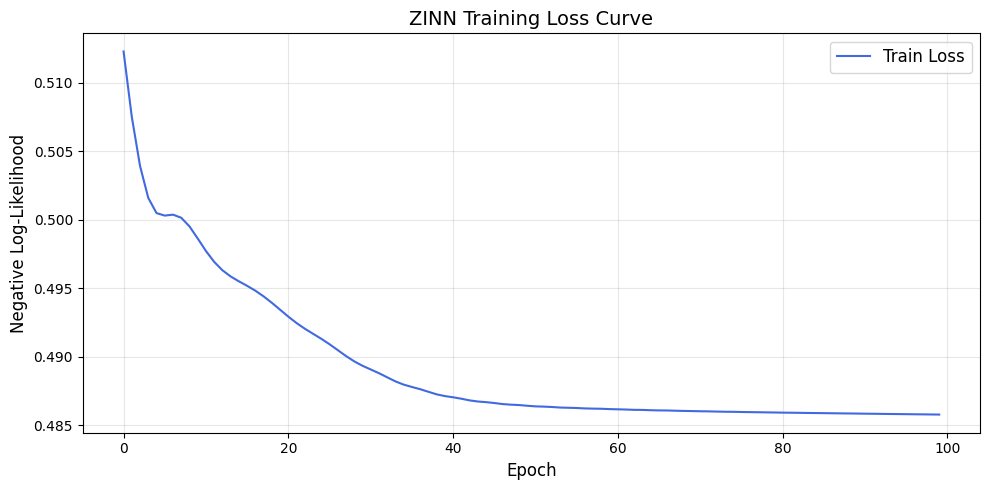


Evaluation Metrics:
- Test Loss: 0.4859
- MAE: 2.5699
- Mean p(zero): 0.0728
- Mean μ: 2.9070
- Mean r: 0.7250

Prediction Examples:
True:  2.0 | Pred:    2
True:  1.0 | Pred:    2
True:  0.0 | Pred:    3
True:  3.0 | Pred:    3
True:  0.0 | Pred:    2

Advanced Prediction Statistics:
- MAE: 2.5699
- RMSE: 2.7515
- True Zero Rate: 85.93%
- Predicted Zero Rate: 0.00%

Prediction Distribution:
  Mean: 2.73
  Std: 0.89
  Min/Max: 1/6
  Percentiles (25/50/75/90/95): [2. 3. 3. 4. 4.]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_evaluate_zinn(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZINN training and evaluation workflow.
    
    Args:
        X_train_tensor: Training features tensor
        y_train_tensor: Training targets tensor
        X_test_tensor: Test features tensor
        y_test_tensor: Test targets tensor
        hidden_dim: Hidden layer size
        epochs: Training epochs
        lr: Learning rate
        verbose: Print progress
        plot: Show training curve
        
    Returns:
        Dictionary containing model, results, and predictions
    """
    # 1. Model initialization
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN(input_dim=input_dim, hidden_dim=hidden_dim)
    
    # 2. Training with early stopping
    trained_model, train_losses = train_zinn(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    # 3. Training visualization
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZINN Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. Comprehensive evaluation
    test_results = evaluate_zinn(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    # 5. Process predictions
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    # 6. Additional metrics
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zinn(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=100,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']

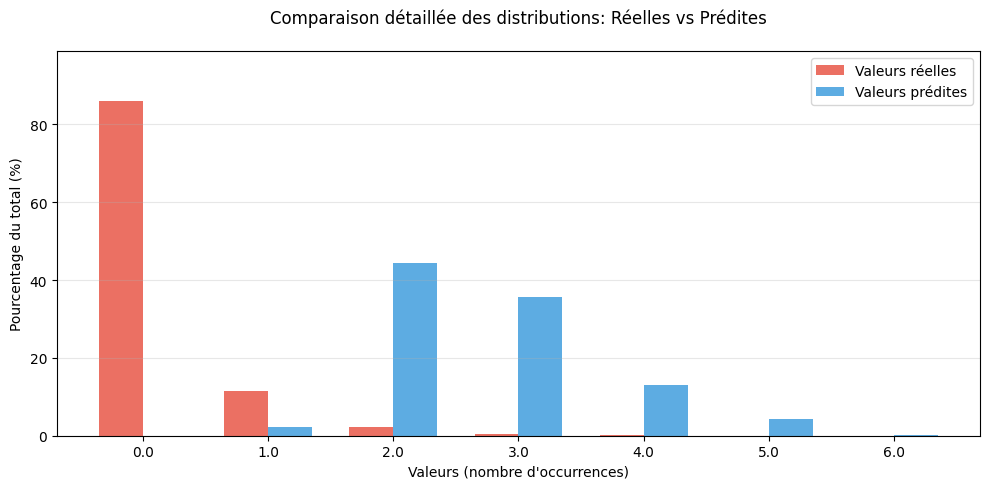


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%) 
--------------------------------------------------
0.0      |      85.93% |       0.00% |     -85.93%
1.0      |      11.40% |       2.37% |      -9.03%
2.0      |       2.26% |      44.30% |     +42.03%
3.0      |       0.32% |      35.68% |     +35.36%
4.0      |       0.07% |      13.04% |     +12.98%
5.0      |       0.01% |       4.32% |      +4.30%
6.0      |       0.00% |       0.28% |      +0.28%


In [ ]:
# 1. First ensure you have these imports at the top of your notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# 4. Get predictions and convert to numpy
with torch.no_grad():
    p_zero, mu, r = trained_model(X_test_tensor)
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()
    
    # Convert to numpy for visualization
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 5. Now run the visualization with proper variable names
plt.figure(figsize=(10, 5))

# Get value distributions using the numpy arrays
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.unique(np.concatenate([unique_vals_real, unique_vals_pred]))

# Create relative frequencies (percentages)
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# Plot settings
bar_width = 0.35
x_pos = np.arange(len(all_values))

# Plot distributions
plt.bar(x_pos - bar_width/2, 
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs réelles', 
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2, 
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs prédites', 
        color='#3498db',
        alpha=0.8)

# Add titles and labels
plt.title("Comparaison détaillée des distributions: Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre d'occurrences)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 6. Print the detailed comparison
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10}")
print("-" * 50)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}%")

/tmp/ipykernel_439800/3433444820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


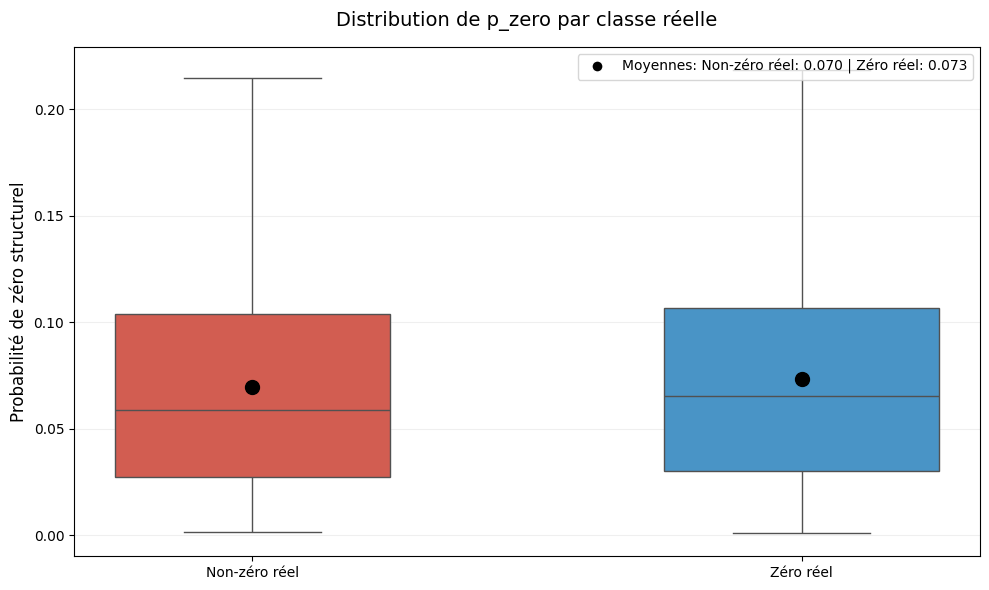


Analyse statistique de p_zero par classe:
                 count    mean     std     min     25%     50%     75%     max
Classe réelle                                                                 
Non-zéro réel   1877.0  0.0697  0.0504  0.0014  0.0271  0.0587  0.1037  0.2145
Zéro réel      11462.0  0.0733  0.0506  0.0009  0.0302  0.0655  0.1068  0.2185

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.14      1.00      0.25      1877
        Zéro       0.00      0.00      0.00     11462

    accuracy                           0.14     13339
   macro avg       0.07      0.50      0.12     13339
weighted avg       0.02      0.14      0.03     13339



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
with torch.no_grad():
    p_zero_test, mu_test, r_test = trained_model(X_test_tensor)
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Create DataFrame for visualization
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                palette=["#e74c3c", "#3498db"], width=0.5)

# Calculate means
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()

# Create custom legend entries
legend_entries = []
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100)
    legend_entries.append(f'{cls}: {mean:.3f}')

# Create unified legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='black', markersize=8,
                              label='Moyennes: ' + ' | '.join(legend_entries))],
           loc='upper right')

plt.title("Distribution de p_zero par classe réelle", fontsize=14, pad=15)
plt.ylabel("Probabilité de zéro structurel", fontsize=12)
plt.xlabel("")
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


# 3. Statistical summary
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 4. Classification report
from sklearn.metrics import classification_report
y_pred_zero = (p_zero_test_np > 0.5).astype(int)
y_true_zero = (y_test_np == 0).astype(int)

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                           target_names=["Non-zéro", "Zéro"]))

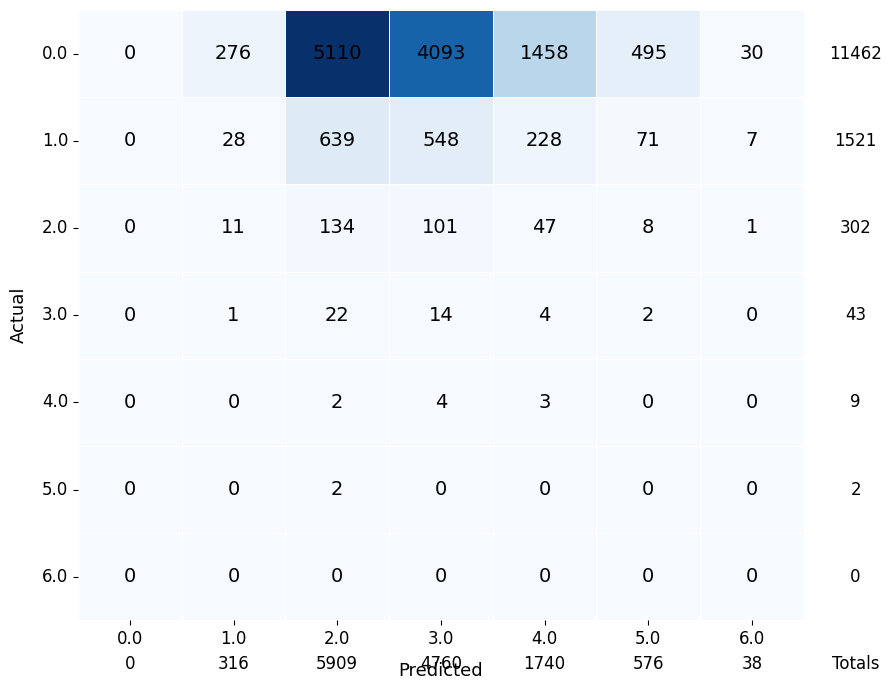


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       0.00      0.00      0.00     11462
   Class 1.0       0.09      0.02      0.03      1521
   Class 2.0       0.02      0.44      0.04       302
   Class 3.0       0.00      0.33      0.01        43
   Class 4.0       0.00      0.33      0.00         9
   Class 5.0       0.00      0.00      0.00         2
   Class 6.0       0.00      0.00      0.00         0

    accuracy                           0.01     13339
   macro avg       0.02      0.16      0.01     13339
weighted avg       0.01      0.01      0.00     13339


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 11462      | 0          | 0         
1.0        | 1521       | 316        | 28        
2.0        | 302        | 5909       | 134       
3.0        | 43         | 4760       | 14        
4.0        | 9          | 1740       | 3       

/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clear totals outside the matrix
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

# Add clean total labels
ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")

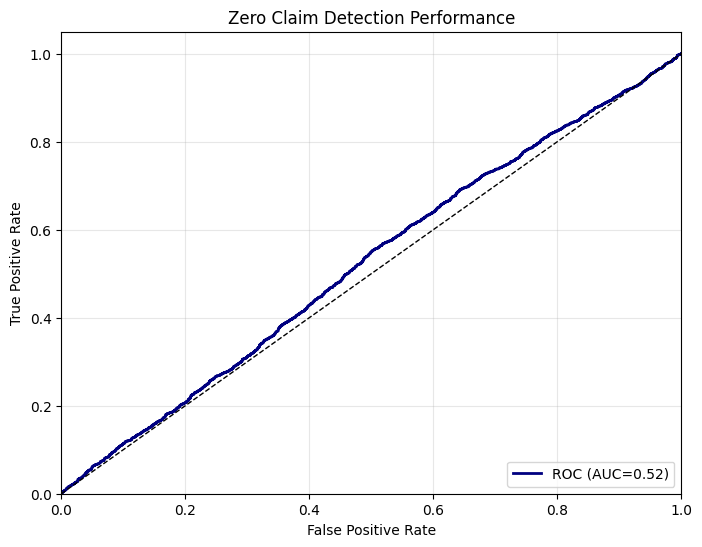

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Construction du ZINN pour theft

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def prepare_zinb_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors and scaler
    """
    # 1. Feature/target selection with validation
    X = df[features].values
    y = df[target].values

    # Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Features and target must be convertible to numpy arrays")

    # 2. Preprocessing with standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 4. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': scaler
    }

    # 5. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zinb_data(
    df=AssuAE,
    features=["facteur1", "facteur2", "facteur3"],
    target="theft"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']


Data Preparation Summary:
- Training samples: 53354
- Test samples: 13339
- Feature dimension: 3
- Target range: [0, 3]
- Train zero proportion: 99.54%
- Test zero proportion: 99.54%

First 5 training samples:
Features: [-0.57  0.04  0.59] -> Target: 0
Features: [-0.46  1.31  0.86] -> Target: 0
Features: [-1.25  0.51  1.46] -> Target: 0
Features: [-0.93  0.35 -0.41] -> Target: 0
Features: [-1.49  0.41  1.14] -> Target: 0


Epoch    1 | Train Loss: 0.1901 | μ: 0.73 | r: 0.67 | p(zero): 0.53
Epoch   10 | Train Loss: 0.0718 | μ: 1.01 | r: 0.43 | p(zero): 0.63
Epoch   20 | Train Loss: 0.0343 | μ: 1.72 | r: 0.17 | p(zero): 0.81
Epoch   30 | Train Loss: 0.0372 | μ: 2.13 | r: 0.11 | p(zero): 0.87
Epoch   40 | Train Loss: 0.0339 | μ: 1.97 | r: 0.14 | p(zero): 0.84


Epoch   50 | Train Loss: 0.0318 | μ: 1.75 | r: 0.19 | p(zero): 0.79
Epoch   60 | Train Loss: 0.0315 | μ: 1.68 | r: 0.21 | p(zero): 0.77
Epoch   70 | Train Loss: 0.0310 | μ: 1.72 | r: 0.20 | p(zero): 0.78
Epoch   80 | Train Loss: 0.0307 | μ: 1.77 | r: 0.19 | p(zero): 0.79
Epoch   90 | Train Loss: 0.0306 | μ: 1.77 | r: 0.19 | p(zero): 0.78
Epoch  100 | Train Loss: 0.0304 | μ: 1.76 | r: 0.20 | p(zero): 0.78


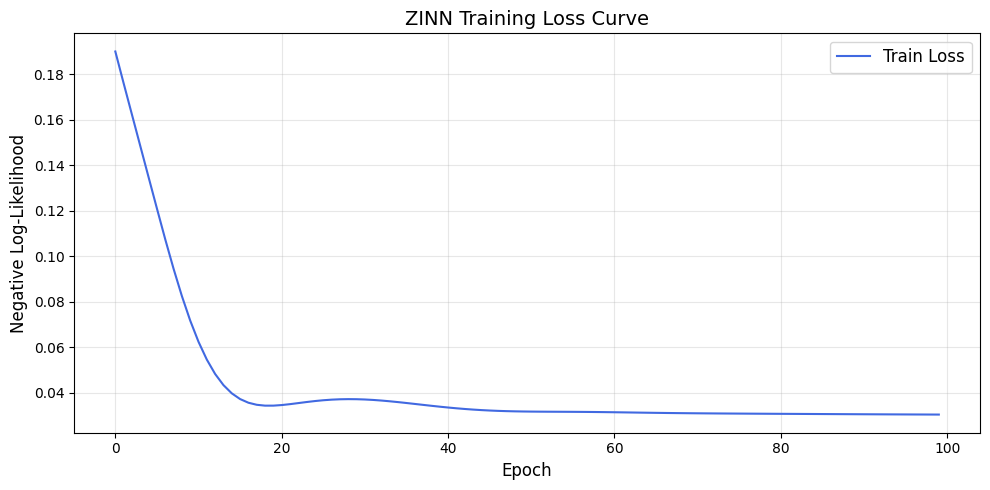


Evaluation Metrics:
- Test Loss: 0.0303
- MAE: 0.1026
- Mean p(zero): 0.7819
- Mean μ: 1.7665
- Mean r: 0.1942

Prediction Examples:
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0

Advanced Prediction Statistics:
- MAE: 0.1026
- RMSE: 0.3212
- True Zero Rate: 99.54%
- Predicted Zero Rate: 90.18%

Prediction Distribution:
  Mean: 0.10
  Std: 0.30
  Min/Max: 0/1
  Percentiles (25/50/75/90/95): [0. 0. 0. 0. 1.]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_evaluate_zinn(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZINN training and evaluation workflow.
    
    Args:
        X_train_tensor: Training features tensor
        y_train_tensor: Training targets tensor
        X_test_tensor: Test features tensor
        y_test_tensor: Test targets tensor
        hidden_dim: Hidden layer size
        epochs: Training epochs
        lr: Learning rate
        verbose: Print progress
        plot: Show training curve
        
    Returns:
        Dictionary containing model, results, and predictions
    """
    # 1. Model initialization
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN(input_dim=input_dim, hidden_dim=hidden_dim)
    
    # 2. Training with early stopping
    trained_model, train_losses = train_zinn(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    # 3. Training visualization
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZINN Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. Comprehensive evaluation
    test_results = evaluate_zinn(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    # 5. Process predictions
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    # 6. Additional metrics
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zinn(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=100,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']

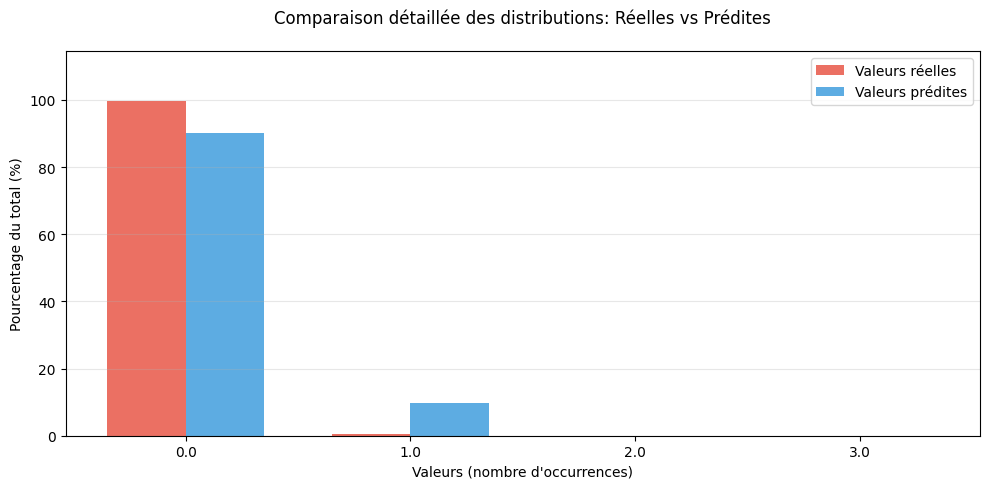


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%) 
--------------------------------------------------
0.0      |      99.54% |      90.18% |      -9.36%
1.0      |       0.44% |       9.82% |      +9.38%
2.0      |       0.01% |       0.00% |      -0.01%
3.0      |       0.01% |       0.00% |      -0.01%


In [ ]:
# 1. First ensure you have these imports at the top of your notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# 4. Get predictions and convert to numpy
with torch.no_grad():
    p_zero, mu, r = trained_model(X_test_tensor)
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()
    
    # Convert to numpy for visualization
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 5. Now run the visualization with proper variable names
plt.figure(figsize=(10, 5))

# Get value distributions using the numpy arrays
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.unique(np.concatenate([unique_vals_real, unique_vals_pred]))

# Create relative frequencies (percentages)
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# Plot settings
bar_width = 0.35
x_pos = np.arange(len(all_values))

# Plot distributions
plt.bar(x_pos - bar_width/2, 
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs réelles', 
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2, 
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs prédites', 
        color='#3498db',
        alpha=0.8)

# Add titles and labels
plt.title("Comparaison détaillée des distributions: Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre d'occurrences)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 6. Print the detailed comparison
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10}")
print("-" * 50)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}%")

/tmp/ipykernel_439800/3433444820.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


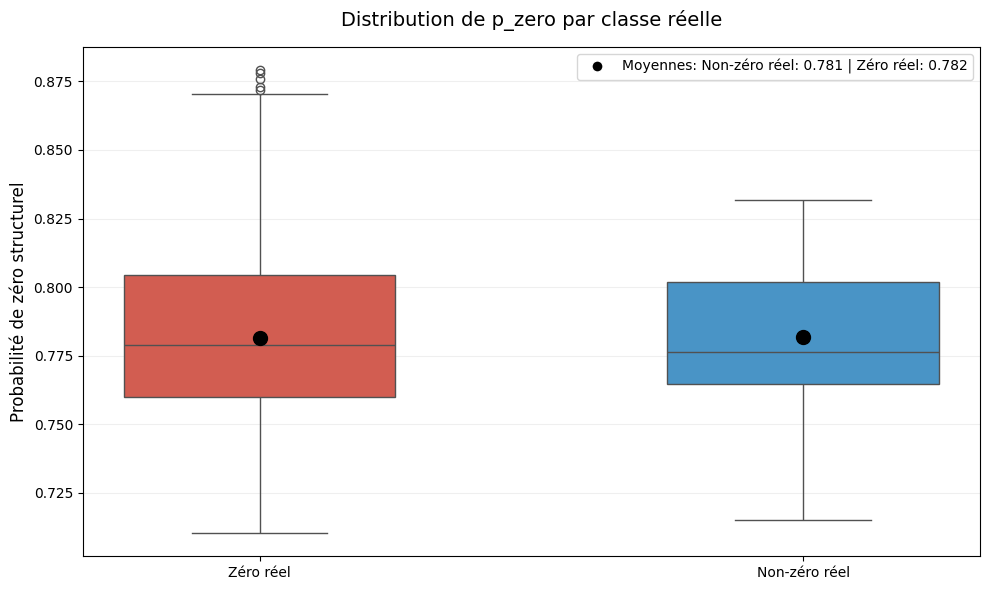


Analyse statistique de p_zero par classe:
                 count    mean     std     min     25%     50%     75%     max
Classe réelle                                                                 
Non-zéro réel     61.0  0.7813  0.0246  0.7151  0.7647  0.7762  0.8020  0.8317
Zéro réel      13278.0  0.7819  0.0305  0.7104  0.7598  0.7791  0.8043  0.8792

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.00      0.00      0.00        61
        Zéro       1.00      1.00      1.00     13278

    accuracy                           1.00     13339
   macro avg       0.50      0.50      0.50     13339
weighted avg       0.99      1.00      0.99     13339



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
with torch.no_grad():
    p_zero_test, mu_test, r_test = trained_model(X_test_tensor)
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Create DataFrame for visualization
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                palette=["#e74c3c", "#3498db"], width=0.5)

# Calculate means
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()

# Create custom legend entries
legend_entries = []
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100)
    legend_entries.append(f'{cls}: {mean:.3f}')

# Create unified legend
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='black', markersize=8,
                              label='Moyennes: ' + ' | '.join(legend_entries))],
           loc='upper right')

plt.title("Distribution de p_zero par classe réelle", fontsize=14, pad=15)
plt.ylabel("Probabilité de zéro structurel", fontsize=12)
plt.xlabel("")
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


# 3. Statistical summary
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 4. Classification report
from sklearn.metrics import classification_report
y_pred_zero = (p_zero_test_np > 0.5).astype(int)
y_true_zero = (y_test_np == 0).astype(int)

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                           target_names=["Non-zéro", "Zéro"]))

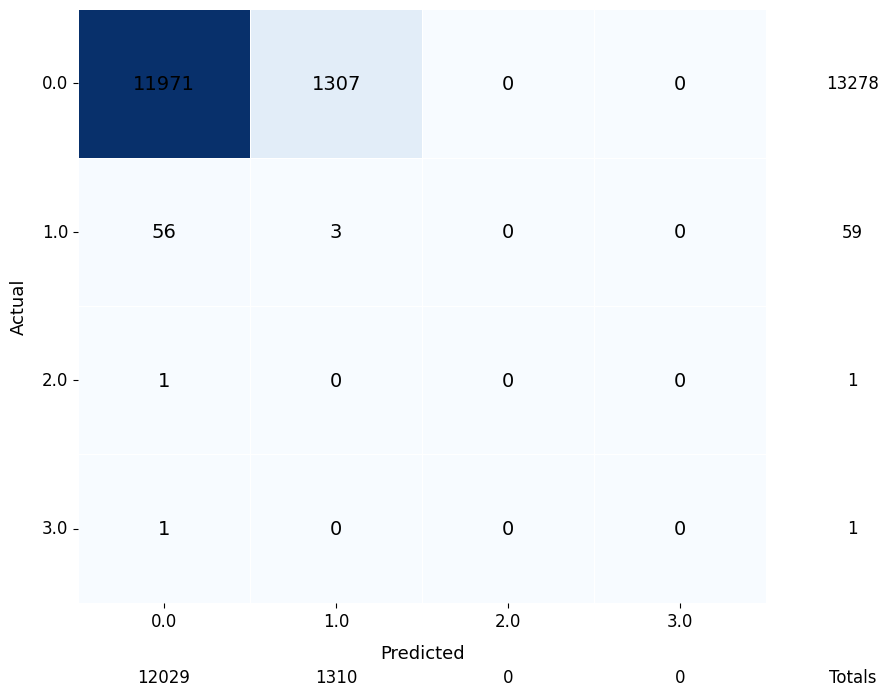


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       1.00      0.90      0.95     13278
   Class 1.0       0.00      0.05      0.00        59
   Class 2.0       0.00      0.00      0.00         1
   Class 3.0       0.00      0.00      0.00         1

    accuracy                           0.90     13339
   macro avg       0.25      0.24      0.24     13339
weighted avg       0.99      0.90      0.94     13339


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 13278      | 12029      | 11971     
1.0        | 59         | 1310       | 3         
2.0        | 1          | 0          | 0         
3.0        | 1          | 0          | 0         


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clear totals outside the matrix
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

# Add clean total labels
ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")

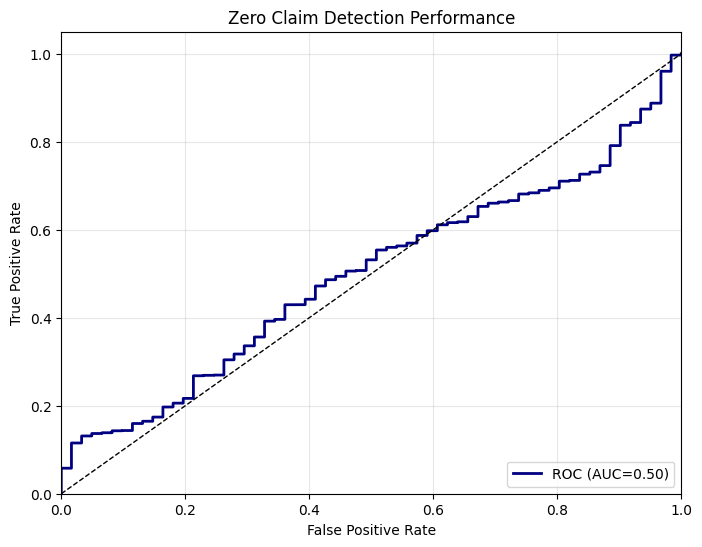

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Application à Broken_glass

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def prepare_zinb_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors and scaler
    """
    # 1. Feature/target selection with validation
    X = df[features].values
    y = df[target].values

    # Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Features and target must be convertible to numpy arrays")

    # 2. Preprocessing with standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 4. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': scaler
    }

    # 5. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zinb_data(
    df=AssuAE,
    features=["facteur1", "facteur2", "facteur3"],
    target="broken_glass"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']


Data Preparation Summary:
- Training samples: 53354
- Test samples: 13339
- Feature dimension: 3
- Target range: [0, 5]
- Train zero proportion: 93.96%
- Test zero proportion: 93.97%

First 5 training samples:
Features: [-1.2   1.04  0.01] -> Target: 0
Features: [ 0.81 -0.79 -1.45] -> Target: 0
Features: [ 0.91 -0.91 -1.43] -> Target: 0
Features: [-0.03 -0.16  1.17] -> Target: 0
Features: [0.03 0.04 0.89] -> Target: 0


Epoch    1 | Train Loss: 0.3180 | μ: 0.73 | r: 0.67 | p(zero): 0.53
Epoch   10 | Train Loss: 0.2580 | μ: 1.00 | r: 0.43 | p(zero): 0.61
Epoch   20 | Train Loss: 0.2573 | μ: 1.08 | r: 0.41 | p(zero): 0.61
Epoch   30 | Train Loss: 0.2562 | μ: 1.03 | r: 0.46 | p(zero): 0.57
Epoch   40 | Train Loss: 0.2546 | μ: 1.14 | r: 0.42 | p(zero): 0.58


Epoch   50 | Train Loss: 0.2540 | μ: 1.18 | r: 0.42 | p(zero): 0.55
Epoch   60 | Train Loss: 0.2536 | μ: 1.21 | r: 0.43 | p(zero): 0.53
Epoch   70 | Train Loss: 0.2533 | μ: 1.29 | r: 0.42 | p(zero): 0.51
Epoch   80 | Train Loss: 0.2529 | μ: 1.35 | r: 0.42 | p(zero): 0.48
Epoch   90 | Train Loss: 0.2525 | μ: 1.46 | r: 0.42 | p(zero): 0.44
Epoch  100 | Train Loss: 0.2522 | μ: 1.59 | r: 0.42 | p(zero): 0.40


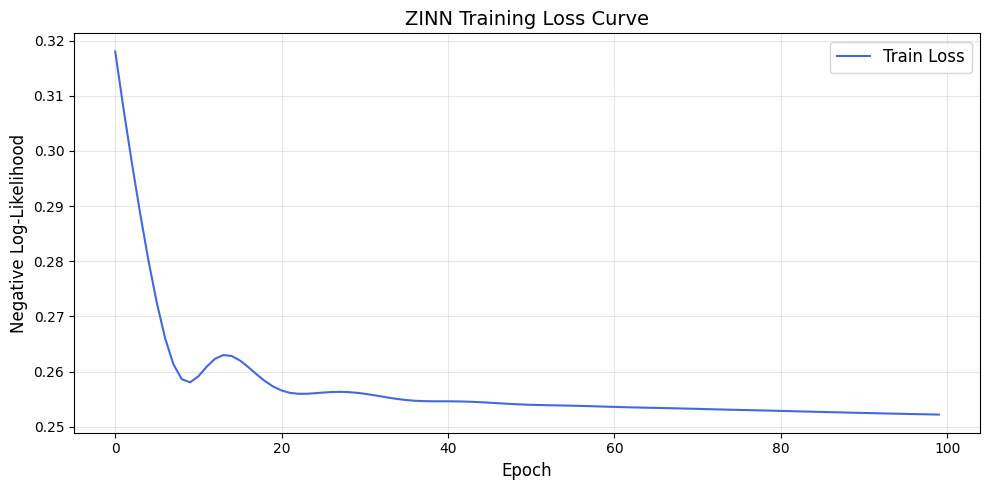


Evaluation Metrics:
- Test Loss: 0.2498
- MAE: 0.9726
- Mean p(zero): 0.3941
- Mean μ: 1.6013
- Mean r: 0.4237

Prediction Examples:
True:  0.0 | Pred:    1
True:  0.0 | Pred:    1
True:  0.0 | Pred:    1
True:  0.0 | Pred:    1
True:  0.0 | Pred:    1

Advanced Prediction Statistics:
- MAE: 0.9726
- RMSE: 1.0114
- True Zero Rate: 93.97%
- Predicted Zero Rate: 0.00%

Prediction Distribution:
  Mean: 1.03
  Std: 0.16
  Min/Max: 1/2
  Percentiles (25/50/75/90/95): [1. 1. 1. 1. 1.]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_evaluate_zinn(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZINN training and evaluation workflow.
    
    Args:
        X_train_tensor: Training features tensor
        y_train_tensor: Training targets tensor
        X_test_tensor: Test features tensor
        y_test_tensor: Test targets tensor
        hidden_dim: Hidden layer size
        epochs: Training epochs
        lr: Learning rate
        verbose: Print progress
        plot: Show training curve
        
    Returns:
        Dictionary containing model, results, and predictions
    """
    # 1. Model initialization
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN(input_dim=input_dim, hidden_dim=hidden_dim)
    
    # 2. Training with early stopping
    trained_model, train_losses = train_zinn(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    # 3. Training visualization
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZINN Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. Comprehensive evaluation
    test_results = evaluate_zinn(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    # 5. Process predictions
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    # 6. Additional metrics
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zinn(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=100,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']

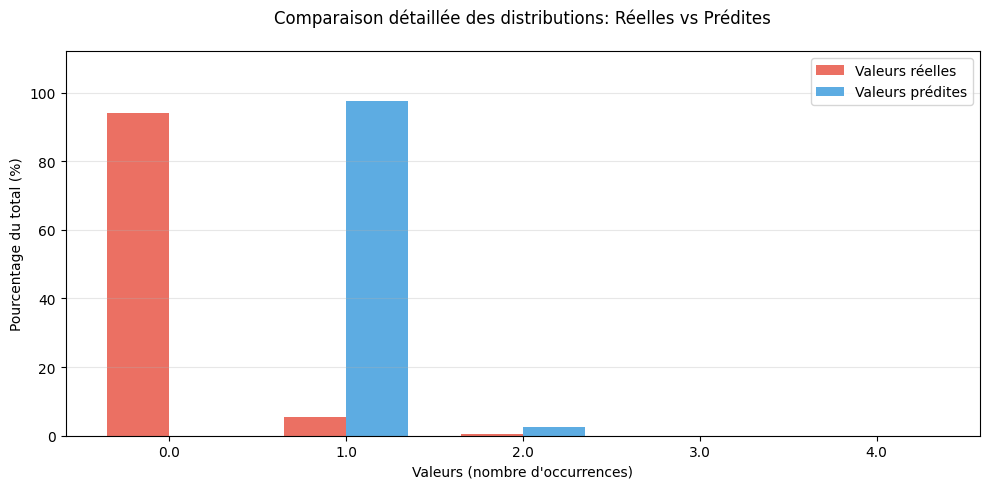


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%) 
--------------------------------------------------
0.0      |      93.97% |       0.00% |     -93.97%
1.0      |       5.38% |      97.42% |     +92.05%
2.0      |       0.59% |       2.58% |      +1.99%
3.0      |       0.06% |       0.00% |      -0.06%
4.0      |       0.01% |       0.00% |      -0.01%


In [ ]:
# 1. First ensure you have these imports at the top of your notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# 4. Get predictions and convert to numpy
with torch.no_grad():
    p_zero, mu, r = trained_model(X_test_tensor)
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()
    
    # Convert to numpy for visualization
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 5. Now run the visualization with proper variable names
plt.figure(figsize=(10, 5))

# Get value distributions using the numpy arrays
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.unique(np.concatenate([unique_vals_real, unique_vals_pred]))

# Create relative frequencies (percentages)
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# Plot settings
bar_width = 0.35
x_pos = np.arange(len(all_values))

# Plot distributions
plt.bar(x_pos - bar_width/2, 
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs réelles', 
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2, 
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width, 
        label='Valeurs prédites', 
        color='#3498db',
        alpha=0.8)

# Add titles and labels
plt.title("Comparaison détaillée des distributions: Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre d'occurrences)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 6. Print the detailed comparison
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10}")
print("-" * 50)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}%")

/tmp/ipykernel_439800/2421803895.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


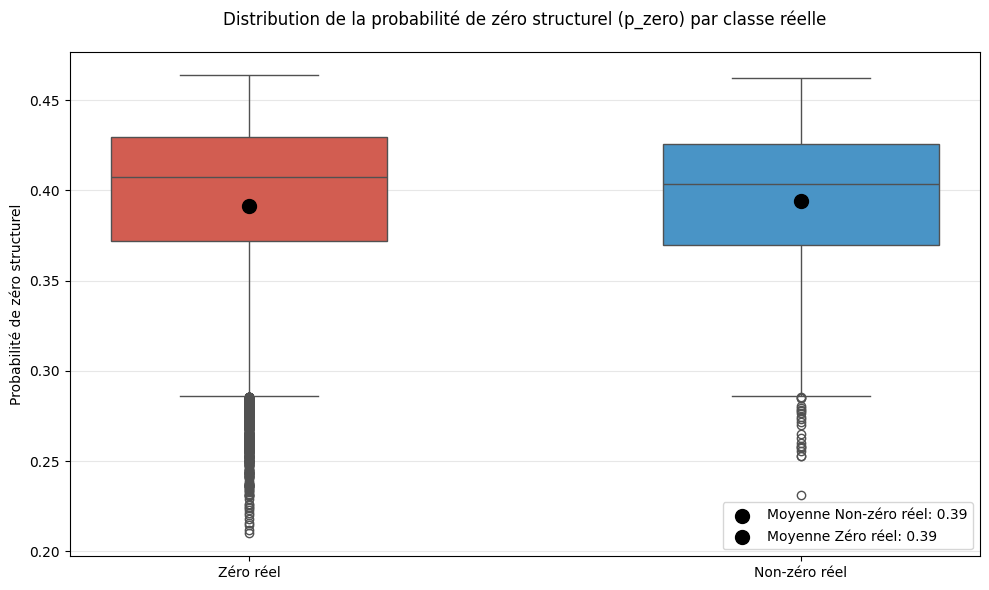


Analyse statistique de p_zero par classe:
                 count    mean     std     min     25%     50%     75%     max
Classe réelle                                                                 
Non-zéro réel    805.0  0.3915  0.0455  0.2313  0.3699  0.4037  0.4259  0.4623
Zéro réel      12534.0  0.3943  0.0472  0.2100  0.3720  0.4072  0.4294  0.4639

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.06      1.00      0.11       805
        Zéro       0.00      0.00      0.00     12534

    accuracy                           0.06     13339
   macro avg       0.03      0.50      0.06     13339
weighted avg       0.00      0.06      0.01     13339



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
with torch.no_grad():
    p_zero_test, mu_test, r_test = trained_model(X_test_tensor)
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Create DataFrame for visualization
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

# 1. Improved Boxplot with both means shown
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                palette=["#e74c3c", "#3498db"], width=0.5)

# Calculate and display both means
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100, label=f'Moyenne {cls}: {mean:.2f}')

plt.title("Distribution de la probabilité de zéro structurel (p_zero) par classe réelle", pad=20)
plt.ylabel("Probabilité de zéro structurel")
plt.xlabel("")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 3. Statistical summary
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 4. Classification report
from sklearn.metrics import classification_report
y_pred_zero = (p_zero_test_np > 0.5).astype(int)
y_true_zero = (y_test_np == 0).astype(int)

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                           target_names=["Non-zéro", "Zéro"]))


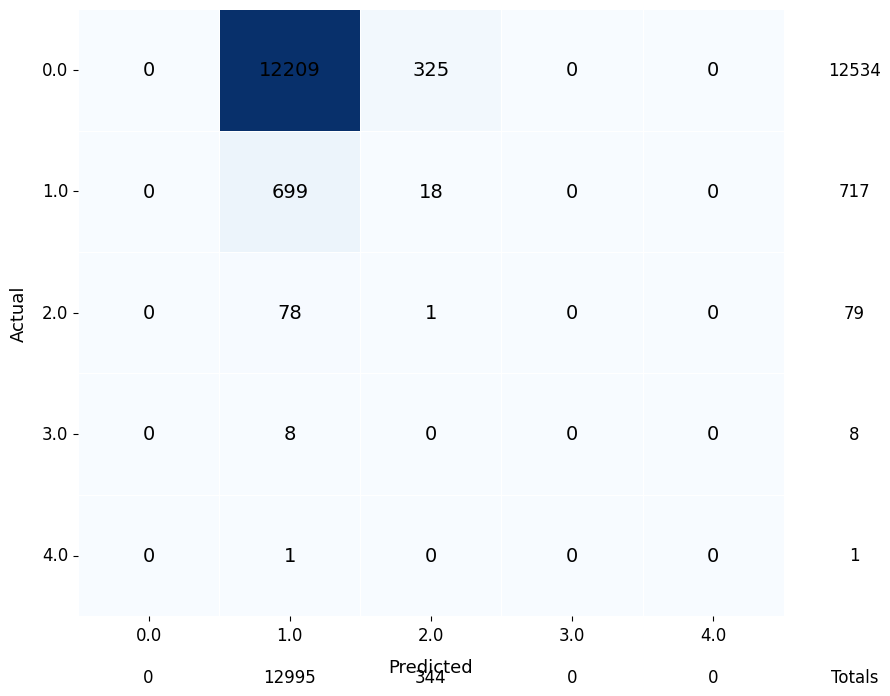


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       0.00      0.00      0.00     12534
   Class 1.0       0.05      0.97      0.10       717
   Class 2.0       0.00      0.01      0.00        79
   Class 3.0       0.00      0.00      0.00         8
   Class 4.0       0.00      0.00      0.00         1

    accuracy                           0.05     13339
   macro avg       0.01      0.20      0.02     13339
weighted avg       0.00      0.05      0.01     13339


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 12534      | 0          | 0         
1.0        | 717        | 12995      | 699       
2.0        | 79         | 344        | 1         
3.0        | 8          | 0          | 0         
4.0        | 1          | 0          | 0         


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clear totals outside the matrix
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

# Add clean total labels
ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")

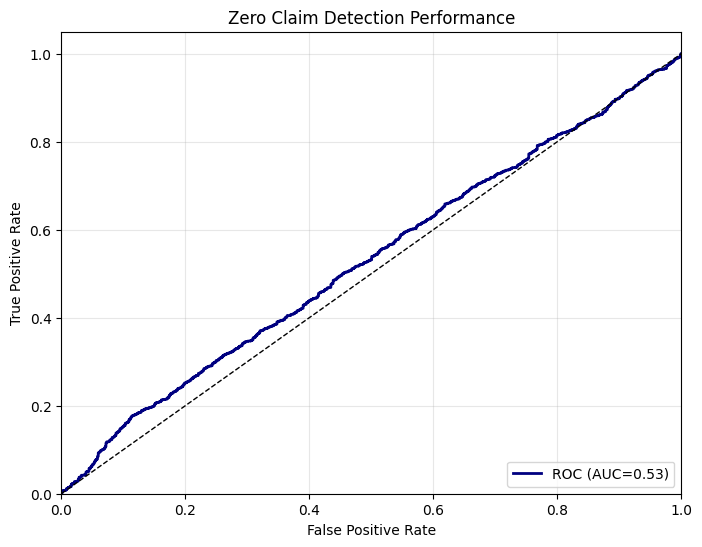

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Construction d'un modèle de Poisson pour fire

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Poisson, Bernoulli

# Fix random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

class ZeroInflatedNN_Poisson(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ZeroInflatedNN_Poisson, self).__init__()

        # Shared hidden layers
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Zero-inflation head (logistic regression)
        self.zero_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Outputs p(zero)
        )
        
        # Count head for Poisson (predicts λ)
        self.count_head = nn.Linear(hidden_dim, 1)  # λ (rate)

    def forward(self, x):
        features = self.shared_net(x)
        
        # Zero-inflation part
        p_zero = self.zero_head(features).squeeze(-1)
        
        # Poisson part
        lambda_ = F.softplus(self.count_head(features).squeeze(-1)) + 1e-4  # ensure positivity
        
        return p_zero, lambda_
    
    def loss(self, p_zero, lambda_, target):
        # Poisson PMF: P(y) = exp(-λ) * λ^y / y!
        pois_dist = Poisson(rate=lambda_)
        pois_pmf = torch.exp(pois_dist.log_prob(target))
        
        # Zero-Inflation: π·I(y=0) + (1-π)·Poisson(y)
        likelihood = torch.where(
            target == 0,
            p_zero + (1 - p_zero) * pois_pmf,
            (1 - p_zero) * pois_pmf
        )
        
        return -torch.log(likelihood + 1e-8).mean()  # Negative log-likelihood

    def predict(self, x, sample=False):
        """
        Generate predictions from the ZIP model.

        Args:
            x: Input features
            sample: If True, sample from ZIP distribution.
                    If False, return expected value E[Y] = (1-π)*λ.
        """
        self.eval()
        with torch.no_grad():
            p_zero, lambda_ = self(x)
            
            if sample:
                # Sample from Bernoulli (zero-inflation)
                is_zero = torch.rand_like(p_zero) < p_zero
                
                # Sample from Poisson (counts)
                pois_dist = Poisson(rate=lambda_)
                counts = pois_dist.sample()
                
                # Apply zero-inflation: structural zeros replace Poisson samples
                predictions = torch.where(is_zero, 
                                          torch.zeros_like(counts), 
                                          counts)
            else:
                # Expected value of ZIP: E[Y] = (1-π)*λ
                predictions = (1 - p_zero) * lambda_
                
            return predictions.long()


In [ ]:
def train_zip(model, X_train, y_train, X_val=None, y_val=None, epochs=100, lr=0.01, 
              verbose=True, early_stopping=False, patience=20, seed=42):
    """Train a Zero-Inflated Poisson Neural Network."""
    set_seed(seed)
    device = next(model.parameters()).device
    
    # Convert data to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if X_val is not None:
        X_val = X_val.to(device)
        y_val = y_val.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//2)
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    no_improve = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        
        p_zero, lambda_ = model(X_train)
        loss = model.loss(p_zero, lambda_, y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_losses.append(loss.item())

        # Validation
        if X_val is not None:
            model.eval()
            with torch.no_grad():
                p_zero_val, lambda_val = model(X_val)
                val_loss = model.loss(p_zero_val, lambda_val, y_val)
                val_losses.append(val_loss.item())
                scheduler.step(val_loss)
                
            if early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_state = copy.deepcopy(model.state_dict())
                    no_improve = 0
                else:
                    no_improve += 1

        if verbose and (epoch % 10 == 0 or epoch == 1 or epoch == epochs):
            log_msg = (f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | "
                      f"λ: {lambda_.mean().item():.2f} | "
                      f"p(zero): {p_zero.mean().item():.2f}")
            if X_val is not None:
                log_msg += f" | Val Loss: {val_loss.item():.4f}"
            print(log_msg)

        if early_stopping and no_improve >= patience:
            if verbose:
                print(f"\nEarly stopping triggered at epoch {epoch}")
            model.load_state_dict(best_state)
            break

    return model, train_losses


In [ ]:
def evaluate_zip(model, X_test, y_test, verbose=True):
    """Evaluate a trained Zero-Inflated Poisson model."""
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    model.eval()
    with torch.no_grad():
        p_zero, lambda_ = model(X_test)
        y_pred_mean = (1 - p_zero) * lambda_
        y_pred_int = torch.round(y_pred_mean).long()
        
        test_loss = model.loss(p_zero, lambda_, y_test)
        mae = torch.mean(torch.abs(y_pred_int.float() - y_test))
        
        results = {
            'loss': test_loss.item(),
            'mae': mae.item(),
            'mean_p_zero': p_zero.mean().item(),
            'mean_lambda': lambda_.mean().item(),
            'predictions': y_pred_int.cpu().numpy()
        }
        
        if verbose:
            print("\nEvaluation Metrics:")
            print(f"- Test Loss: {results['loss']:.4f}")
            print(f"- MAE: {results['mae']:.4f}")
            print(f"- Mean p(zero): {results['mean_p_zero']:.4f}")
            print(f"- Mean λ: {results['mean_lambda']:.4f}")
            
            print("\nPrediction Examples:")
            for i in range(min(5, len(y_test))):
                print(f"True: {y_test[i].item():4.1f} | Pred: {y_pred_int[i].item():4d}")
        
        return results


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def prepare_zip_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors and scaler
    """
    # 1. Feature/target selection with validation
    X = df[features].values
    y = df[target].values

    # Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Features and target must be convertible to numpy arrays")

    # 2. Preprocessing with standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 4. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': scaler
    }

    # 5. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zip_data(
    df=AssuAE,
    features=["facteur1", "facteur2", "facteur3"],
    target="fire"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']


Data Preparation Summary:
- Training samples: 53354
- Test samples: 13339
- Feature dimension: 3
- Target range: [0, 2]
- Train zero proportion: 99.79%
- Test zero proportion: 99.79%

First 5 training samples:
Features: [-1.11  0.99  1.32] -> Target: 0
Features: [0.61 1.82 0.06] -> Target: 0
Features: [-0.64  0.25  0.81] -> Target: 0
Features: [-0.14  1.01 -0.58] -> Target: 0
Features: [ 0.51 -1.61 -1.14] -> Target: 0


Epoch    1 | Train Loss: 0.2911 | λ: 0.76 | p(zero): 0.53
Epoch   10 | Train Loss: 0.1466 | λ: 0.54 | p(zero): 0.68
Epoch   20 | Train Loss: 0.0329 | λ: 0.20 | p(zero): 0.89
Epoch   30 | Train Loss: 0.0186 | λ: 0.06 | p(zero): 0.97
Epoch   40 | Train Loss: 0.0197 | λ: 0.03 | p(zero): 0.98
Epoch   50 | Train Loss: 0.0194 | λ: 0.03 | p(zero): 0.98
Epoch   60 | Train Loss: 0.0183 | λ: 0.04 | p(zero): 0.98
Epoch   70 | Train Loss: 0.0174 | λ: 0.05 | p(zero): 0.98
Epoch   80 | Train Loss: 0.0170 | λ: 0.07 | p(zero): 0.97
Epoch   90 | Train Loss: 0.0168 | λ: 0.07 | p(zero): 0.97
Epoch  100 | Train Loss: 0.0166 | λ: 0.07 | p(zero): 0.97


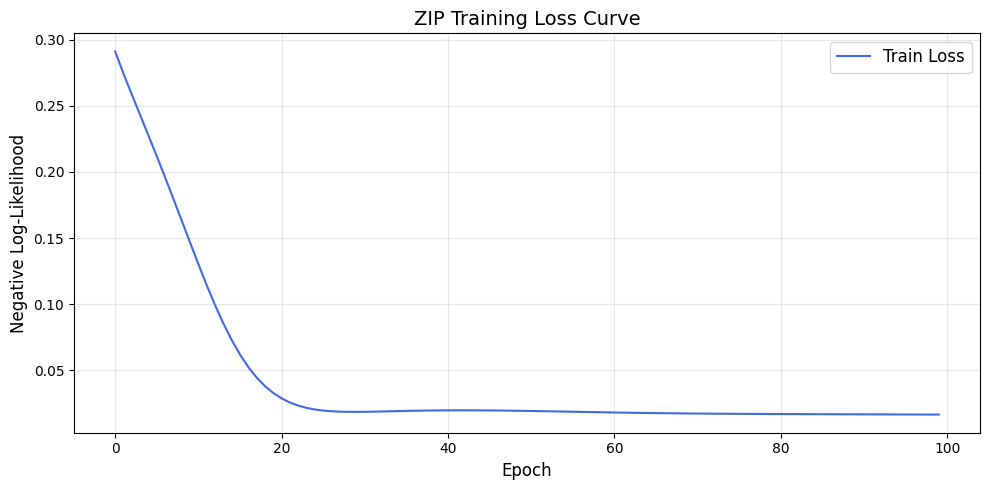


Evaluation Metrics:
- Test Loss: 0.0162
- MAE: 0.0021
- Mean p(zero): 0.9689
- Mean λ: 0.0700

Prediction Examples:
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0

Advanced Prediction Statistics:
- MAE: 0.0021
- RMSE: 0.0458
- True Zero Rate: 99.79%
- Predicted Zero Rate: 100.00%

Prediction Distribution:
  Mean: 0.00
  Std: 0.00
  Min/Max: 0/0
  Percentiles (25/50/75/90/95): [0. 0. 0. 0. 0.]


In [ ]:
def train_evaluate_zip(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZIP training and evaluation workflow.
    """
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN_Poisson(input_dim=input_dim, hidden_dim=hidden_dim)
    
    trained_model, train_losses = train_zip(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZIP Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    test_results = evaluate_zip(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zip(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=100,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']


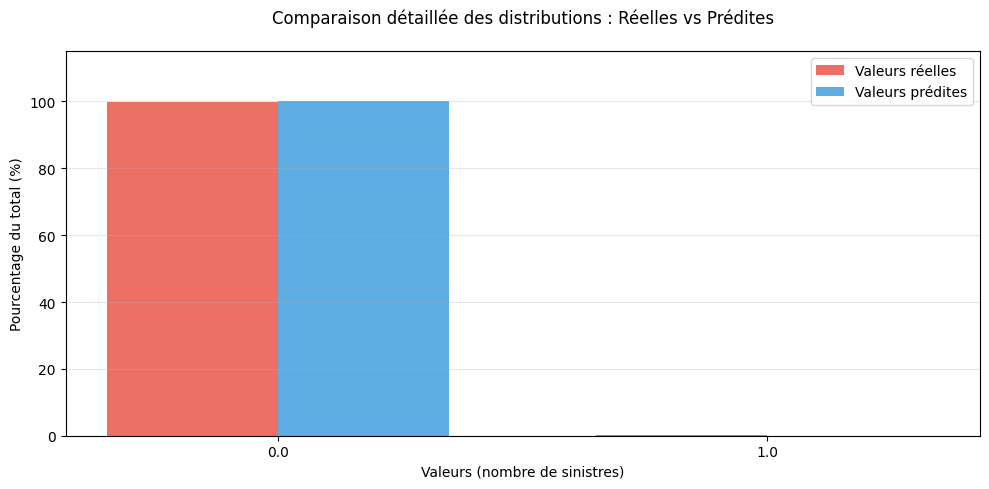


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%)  | Remarque
-----------------------------------------------------------------
0.0      |      99.79% |     100.00% |      +0.21% | 
1.0      |       0.21% |       0.00% |      -0.21% | ⚠️ absente dans les prédictions

Analyse des zéros :
- Taux de zéros (réels)   : 99.79%
- Taux de zéros (prédits) : 100.00%
- Écart                    : +0.21%


In [ ]:
# 1. Prédictions du modèle (en supposant que le modèle retourne 2 valeurs : p_zero et mu)
with torch.no_grad():
    p_zero, mu = trained_model(X_test_tensor)  # Il n'y a que 2 valeurs ici
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()

    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 2. Analyse des distributions
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.sort(np.unique(np.concatenate([unique_vals_real, unique_vals_pred])))

# 3. Fréquences relatives
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# 4. Plot comparatif
plt.figure(figsize=(10, 5))
bar_width = 0.35
x_pos = np.arange(len(all_values))

plt.bar(x_pos - bar_width/2,
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width,
        label='Valeurs réelles',
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2,
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width,
        label='Valeurs prédites',
        color='#3498db',
        alpha=0.8)

plt.title("Comparaison détaillée des distributions : Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre de sinistres)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 5. Comparaison textuelle détaillée
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10} | Remarque")
print("-" * 65)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    note = ""
    if val not in unique_vals_real:
        note = "⚠️ absente dans les vraies"
    elif val not in unique_vals_pred:
        note = "⚠️ absente dans les prédictions"
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}% | {note}")

# 6. Résumé sur les zéros
zero_real = (y_test_np == 0).mean() * 100
zero_pred = (y_pred_np == 0).mean() * 100
print("\nAnalyse des zéros :")
print(f"- Taux de zéros (réels)   : {zero_real:.2f}%")
print(f"- Taux de zéros (prédits) : {zero_pred:.2f}%")
print(f"- Écart                    : {zero_pred - zero_real:+.2f}%")


/tmp/ipykernel_439800/3057211847.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


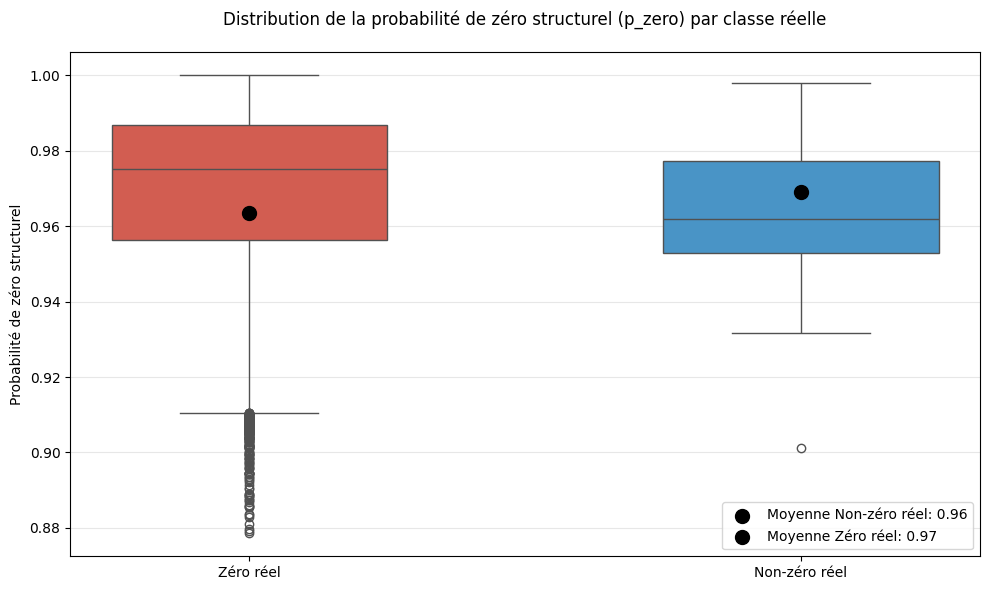


Analyse statistique de p_zero par classe:
                 count    mean     std     min     25%     50%     75%     max
Classe réelle                                                                 
Non-zéro réel     28.0  0.9635  0.0207  0.9013  0.9528  0.9618  0.9773  0.9978
Zéro réel      13311.0  0.9689  0.0227  0.8786  0.9563  0.9750  0.9868  1.0000

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.00      0.00      0.00        28
        Zéro       1.00      1.00      1.00     13311

    accuracy                           1.00     13339
   macro avg       0.50      0.50      0.50     13339
weighted avg       1.00      1.00      1.00     13339



/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# 1. Prédictions du modèle
with torch.no_grad():
    # Ajustement en fonction de ce que ton modèle retourne
    p_zero_test, mu_test = trained_model(X_test_tensor)  # Si le modèle ne retourne que 2 valeurs
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()  # Conversion en numpy array
    y_test_np = y_test_tensor.cpu().numpy()

# 2. Création du DataFrame pour la visualisation
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

# 3. Boxplot amélioré avec les moyennes
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                 palette=["#e74c3c", "#3498db"], width=0.5)

# Calcul des moyennes et ajout des points moyens
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100, label=f'Moyenne {cls}: {mean:.2f}')

plt.title("Distribution de la probabilité de zéro structurel (p_zero) par classe réelle", pad=20)
plt.ylabel("Probabilité de zéro structurel")
plt.xlabel("")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Analyse statistique de p_zero
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 5. Rapport de classification basé sur un seuil de 0.5
y_pred_zero = (p_zero_test_np > 0.5).astype(int)  # Seuil de 0.5 pour prédire les zéros
y_true_zero = (y_test_np == 0).astype(int)  # Conversion des vraies classes de sinistre en 0 et 1

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                            target_names=["Non-zéro", "Zéro"]))


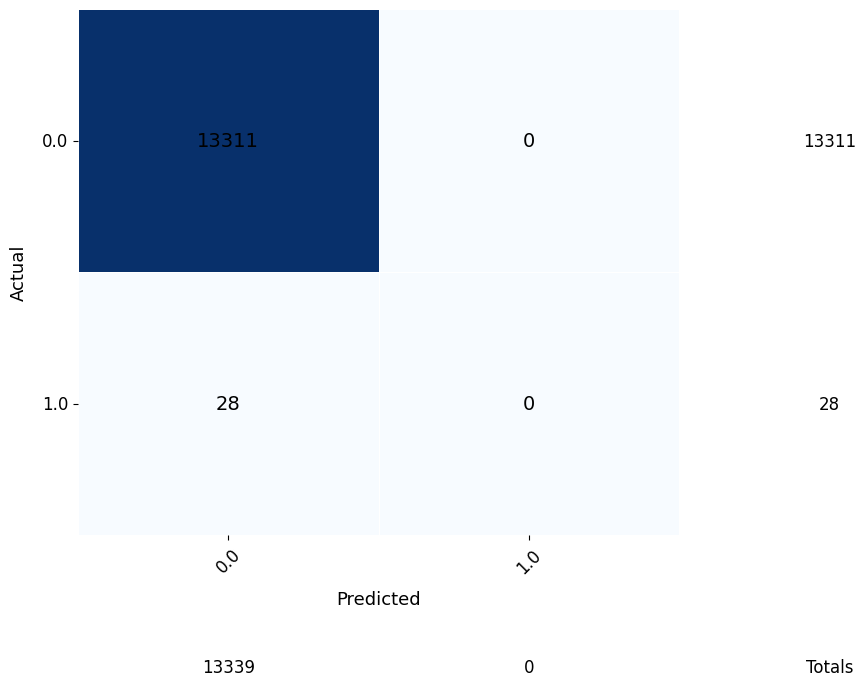


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       1.00      1.00      1.00     13311
   Class 1.0       0.00      0.00      0.00        28

    accuracy                           1.00     13339
   macro avg       0.50      0.50      0.50     13339
weighted avg       1.00      1.00      1.00     13339


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 13311      | 13339      | 13311     
1.0        | 28         | 0          | 0         


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12, rotation=45)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clean total labels
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")


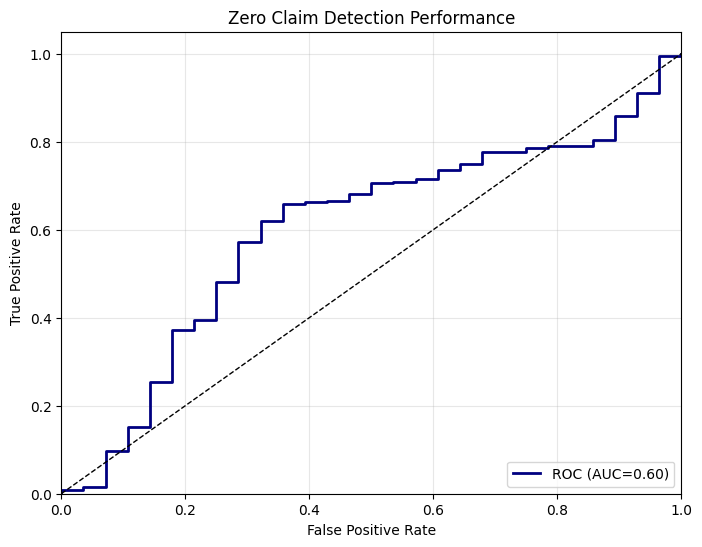

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

def prepare_zip_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors and scaler
    """
    # 1. Feature/target selection with validation
    X = df[features].values
    y = df[target].values

    # Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Features and target must be convertible to numpy arrays")

    # 2. Preprocessing with standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 4. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': scaler
    }

    # 5. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zip_data(
    df=AssuAE,
    features=["facteur1", "facteur2", "facteur3"],
    target="fire"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']


Data Preparation Summary:
- Training samples: 53354
- Test samples: 13339
- Feature dimension: 3
- Target range: [0, 2]
- Train zero proportion: 99.79%
- Test zero proportion: 99.79%

First 5 training samples:
Features: [-1.11  0.99  1.32] -> Target: 0
Features: [0.61 1.82 0.06] -> Target: 0
Features: [-0.64  0.25  0.81] -> Target: 0
Features: [-0.14  1.01 -0.58] -> Target: 0
Features: [ 0.51 -1.61 -1.14] -> Target: 0


## Construction du ZINN pour la base 3

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def prepare_zip_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors, scaler, and column names
    """
    # 1. Feature/target selection with validation
    X = df[features].copy()  # Ensure we don't modify the original dataframe
    y = df[target].values  # Convert target column to numpy array

    # Check types: X must be a pandas DataFrame and y must be a numpy array
    if not isinstance(X, pd.DataFrame):
        raise TypeError(f"Features must be a pandas DataFrame, got {type(X)}")
    if not isinstance(y, np.ndarray):
        raise TypeError(f"Target must be a numpy array, got {type(y)}")

    # 2. Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")

    # 3. Identify categorical features (object and bool types)
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    # 4. Identify numerical features (int and float types)
    numerical_features = X.select_dtypes(include=['int', 'float']).columns.tolist()

    # 5. Preprocessing pipeline for categorical variables with one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHotEncoding
    ])

    # 6. Preprocessing pipeline for numerical variables with standardization
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
        ('scaler', StandardScaler())  # Standardization
    ])
    
    # 7. ColumnTransformer to apply transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)  # Standardize numerical features
        ]
    )

    # Apply transformations
    X_transformed = preprocessor.fit_transform(X)
    
    # 8. Get the feature names after one-hot encoding and standardization
    encoded_feature_names = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    standardized_feature_names = numerical_features  # Keep original names for standardized numerical features

    # Combine all feature names
    all_feature_names = np.concatenate([encoded_feature_names, standardized_feature_names])

    # 9. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_transformed, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 10. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': preprocessor,
        'encoded_feature_names': encoded_feature_names,  # Include the encoded feature names
        'all_feature_names': all_feature_names  # Include all feature names (encoded + standardized)
    }

    # 11. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zip_data(
    df=df_forward1,
    features = [
        "months_between_inception", "is_from_aggregator", "PC_earned_exposure", "driver_count", "package", "POL_Fract",
        "POL_Age", "BEH_TypeGarage", "BEH_Usage", "POL_DeclaredAnnualKm", "PER_PurchaseMode",
        "PER_DurDetVehicle", "VEH_Age", "VEH_Antecedent", "is_md_worst_driver", "PER_Age",
        "PER_Profession", "BEH_MaritalStatus", "previous_insurance_months", "POL_Antecedent",
        "PER_LicenceAge", "POL_CRM", "POL_CRMMax", "PER_TimeB50", "is_learner_driver",
        "SRA_DernierPrixConnu", "SRA_Marque", "SRA_CodeEnergie", "SRA_PuissanceReelleMaxiCEE",
        "SRA_Alimentation", "SRA_VitesseMaxi", "SRA_TypeFreins", "SRA_CodeCarrosserie",
        "SRA_Transmission", "SRA_NombrePlaces", "SRA_ClasseReparationActuelle",
        "SRA_ClasseActuelle", "SRA_BoiteVitesses", "SRA_Groupe", "SRA_Classe",
        "SRA_AntiDemarrage", "SRA_Segment", "SRA_NombreRapports", "VEH_ClasseCout",
        "VEH_Segment_FOCUS", "VEH_Carrosserie_FOCUS", "RFVLX1", "RFVLX2", "PDVOL", "AMV2",
        "CVH1", "CVH2", "PROPIL1", "RFBDG", "all_missings"
    ],
    target = "totalClaimCount"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']
encoded_feature_names = data_dict['encoded_feature_names']
all_feature_names = data_dict['all_feature_names']

# Print all feature names to check
print("All Feature Names (Encoded + Standardized):")
print(all_feature_names)



Data Preparation Summary:
- Training samples: 2451
- Test samples: 613
- Feature dimension: 299
- Target range: [0, 2]
- Train zero proportion: 88.25%
- Test zero proportion: 88.25%

First 5 training samples:
Features: [ 1.    0.    0.    1.    1.    0.    1.    0.    0.    0.    0.    1.
  0.    1.    0.    0.    1.    0.    0.    1.    0.    1.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  1.    0.    1.    0.    0.    1.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    1.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.

Epoch    1 | Train Loss: 0.4610 | λ: 0.66 | p(zero): 0.53
Epoch   10 | Train Loss: 0.3921 | λ: 0.32 | p(zero): 0.70
Epoch   20 | Train Loss: 0.3575 | λ: 0.27 | p(zero): 0.56
Epoch   30 | Train Loss: 0.3247 | λ: 0.18 | p(zero): 0.53
Epoch   40 | Train Loss: 0.3012 | λ: 0.17 | p(zero): 0.41
Epoch   50 | Train Loss: 0.2766 | λ: 0.14 | p(zero): 0.38
Epoch   60 | Train Loss: 0.2494 | λ: 0.14 | p(zero): 0.40
Epoch   70 | Train Loss: 0.2209 | λ: 0.14 | p(zero): 0.42
Epoch   80 | Train Loss: 0.1982 | λ: 0.16 | p(zero): 0.44
Epoch   90 | Train Loss: 0.1762 | λ: 0.13 | p(zero): 0.53
Epoch  100 | Train Loss: 0.1591 | λ: 0.14 | p(zero): 0.57
Epoch  110 | Train Loss: 0.1478 | λ: 0.12 | p(zero): 0.64
Epoch  120 | Train Loss: 0.1387 | λ: 0.13 | p(zero): 0.66
Epoch  130 | Train Loss: 0.1336 | λ: 0.12 | p(zero): 0.68
Epoch  140 | Train Loss: 0.1296 | λ: 0.13 | p(zero): 0.70
Epoch  150 | Train Loss: 0.1286 | λ: 0.12 | p(zero): 0.72
Epoch  160 | Train Loss: 0.1292 | λ: 0.16 | p(zero): 0.70
Epoch  170 | T

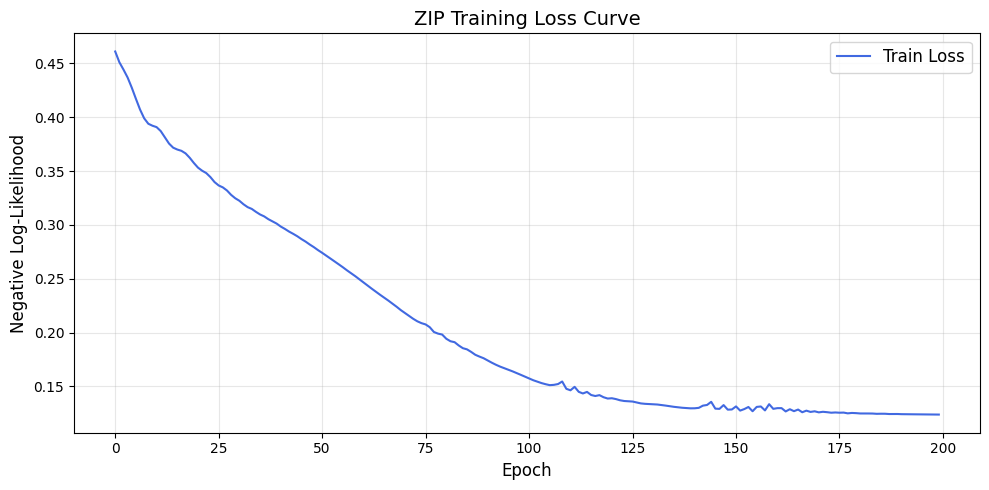


Evaluation Metrics:
- Test Loss: 1.1406
- MAE: 0.2007
- Mean p(zero): 0.7259
- Mean λ: 0.0988

Prediction Examples:
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0

Advanced Prediction Statistics:
- MAE: 0.2007
- RMSE: 0.5494
- True Zero Rate: 88.25%
- Predicted Zero Rate: 94.13%

Prediction Distribution:
  Mean: 0.09
  Std: 0.42
  Min/Max: 0/3
  Percentiles (25/50/75/90/95): [0. 0. 0. 0. 1.]


In [ ]:
def train_evaluate_zip(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZIP training and evaluation workflow.
    """
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN_Poisson(input_dim=input_dim, hidden_dim=hidden_dim)
    
    trained_model, train_losses = train_zip(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZIP Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    test_results = evaluate_zip(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zip(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=200,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']


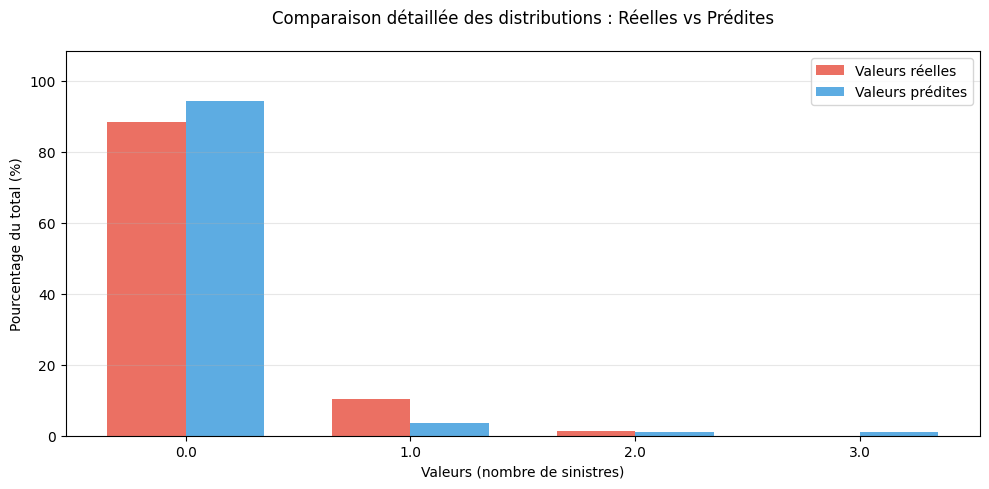


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%)  | Remarque
-----------------------------------------------------------------
0.0      |      88.25% |      94.13% |      +5.87% | 
1.0      |      10.44% |       3.59% |      -6.85% | 
2.0      |       1.31% |       1.14% |      -0.16% | 
3.0      |       0.00% |       1.14% |      +1.14% | ⚠️ absente dans les vraies

Analyse des zéros :
- Taux de zéros (réels)   : 88.25%
- Taux de zéros (prédits) : 94.13%
- Écart                    : +5.87%


In [ ]:
# 1. Prédictions du modèle (en supposant que le modèle retourne 2 valeurs : p_zero et mu)
with torch.no_grad():
    p_zero, mu = trained_model(X_test_tensor)  # Il n'y a que 2 valeurs ici
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()

    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 2. Analyse des distributions
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.sort(np.unique(np.concatenate([unique_vals_real, unique_vals_pred])))

# 3. Fréquences relatives
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# 4. Plot comparatif
plt.figure(figsize=(10, 5))
bar_width = 0.35
x_pos = np.arange(len(all_values))

plt.bar(x_pos - bar_width/2,
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width,
        label='Valeurs réelles',
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2,
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width,
        label='Valeurs prédites',
        color='#3498db',
        alpha=0.8)

plt.title("Comparaison détaillée des distributions : Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre de sinistres)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 5. Comparaison textuelle détaillée
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10} | Remarque")
print("-" * 65)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    note = ""
    if val not in unique_vals_real:
        note = "⚠️ absente dans les vraies"
    elif val not in unique_vals_pred:
        note = "⚠️ absente dans les prédictions"
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}% | {note}")

# 6. Résumé sur les zéros
zero_real = (y_test_np == 0).mean() * 100
zero_pred = (y_pred_np == 0).mean() * 100
print("\nAnalyse des zéros :")
print(f"- Taux de zéros (réels)   : {zero_real:.2f}%")
print(f"- Taux de zéros (prédits) : {zero_pred:.2f}%")
print(f"- Écart                    : {zero_pred - zero_real:+.2f}%")


/tmp/ipykernel_439800/3057211847.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


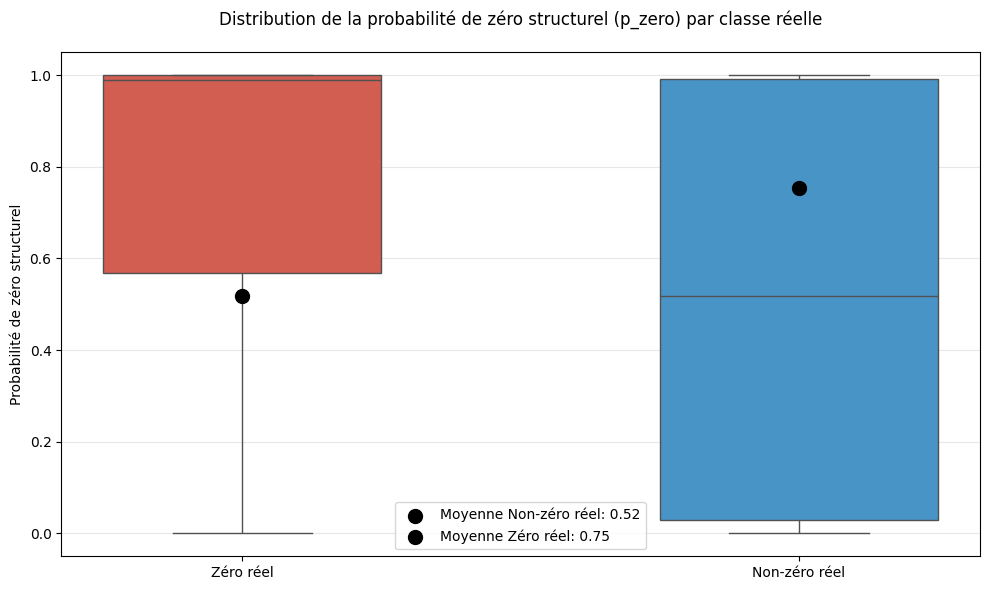


Analyse statistique de p_zero par classe:
               count    mean     std     min     25%     50%     75%  max
Classe réelle                                                            
Non-zéro réel   72.0  0.5179  0.4279  0.0001  0.0284  0.5179  0.9909  1.0
Zéro réel      541.0  0.7536  0.3677  0.0000  0.5681  0.9905  0.9998  1.0

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.20      0.46      0.28        72
        Zéro       0.91      0.76      0.83       541

    accuracy                           0.73       613
   macro avg       0.56      0.61      0.56       613
weighted avg       0.83      0.73      0.77       613



In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# 1. Prédictions du modèle
with torch.no_grad():
    # Ajustement en fonction de ce que ton modèle retourne
    p_zero_test, mu_test = trained_model(X_test_tensor)  # Si le modèle ne retourne que 2 valeurs
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()  # Conversion en numpy array
    y_test_np = y_test_tensor.cpu().numpy()

# 2. Création du DataFrame pour la visualisation
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

# 3. Boxplot amélioré avec les moyennes
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                 palette=["#e74c3c", "#3498db"], width=0.5)

# Calcul des moyennes et ajout des points moyens
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100, label=f'Moyenne {cls}: {mean:.2f}')

plt.title("Distribution de la probabilité de zéro structurel (p_zero) par classe réelle", pad=20)
plt.ylabel("Probabilité de zéro structurel")
plt.xlabel("")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Analyse statistique de p_zero
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 5. Rapport de classification basé sur un seuil de 0.5
y_pred_zero = (p_zero_test_np > 0.5).astype(int)  # Seuil de 0.5 pour prédire les zéros
y_true_zero = (y_test_np == 0).astype(int)  # Conversion des vraies classes de sinistre en 0 et 1

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                            target_names=["Non-zéro", "Zéro"]))


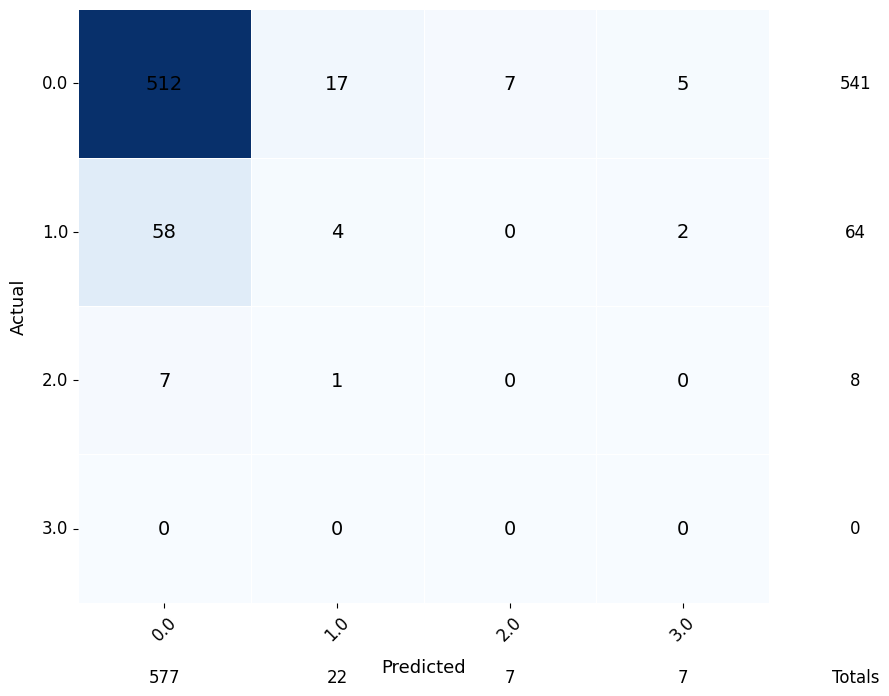


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       0.89      0.95      0.92       541
   Class 1.0       0.18      0.06      0.09        64
   Class 2.0       0.00      0.00      0.00         8
   Class 3.0       0.00      0.00      0.00         0

    accuracy                           0.84       613
   macro avg       0.27      0.25      0.25       613
weighted avg       0.80      0.84      0.82       613


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 541        | 577        | 512       
1.0        | 64         | 22         | 4         
2.0        | 8          | 7          | 0         
3.0        | 0          | 7          | 0         


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12, rotation=45)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clean total labels
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")


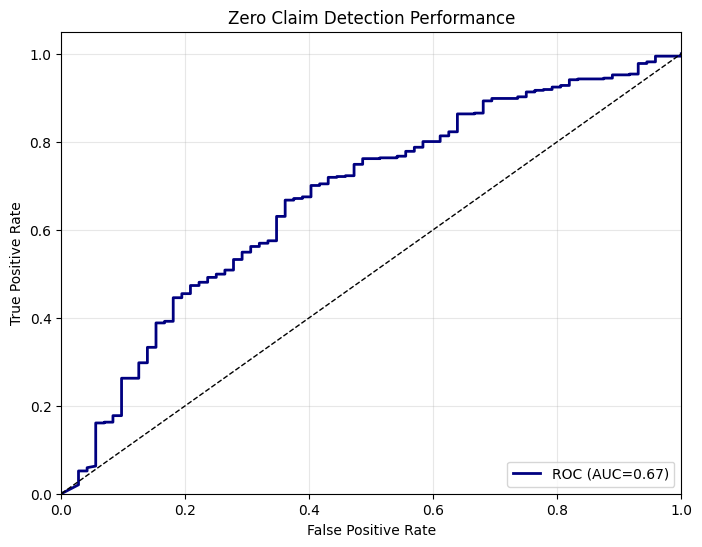

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

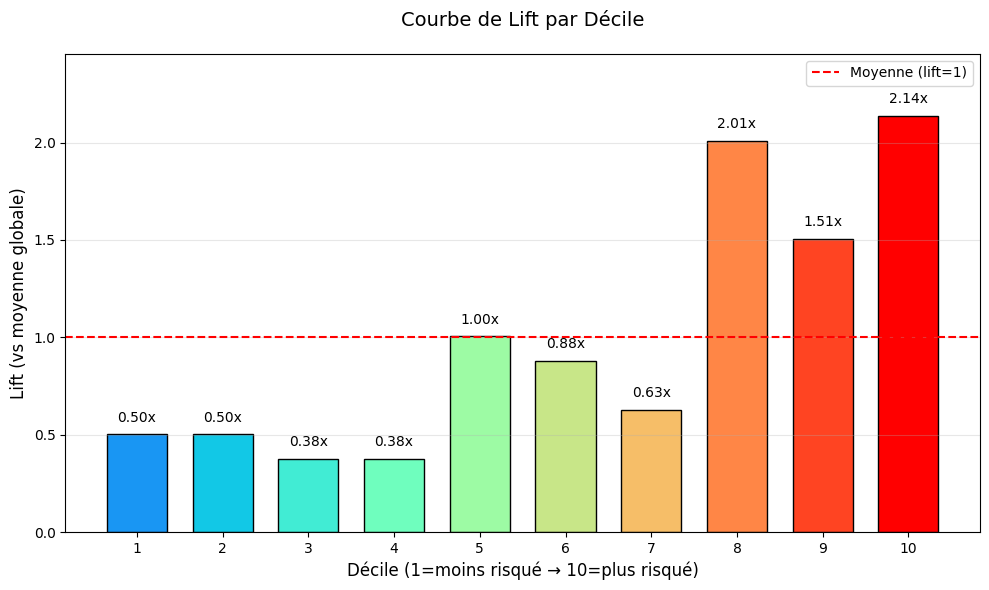

In [ ]:
def calculate_and_plot_lift_vertical(model, X_test, y_test, n_deciles=10):
    """
    Courbe de lift verticale avec déciles 1 (moins bien) à 10 (mieux classés)
    """
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    
    # Prédictions
    model.eval()
    with torch.no_grad():
        p_zero, lambda_ = model(X_test)
        risk_scores = (1 - p_zero) * lambda_
        
    risk_scores = risk_scores.cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    # Tri du MOINS risqué (décile 1) au PLUS risqué (décile 10)
    sorted_indices = np.argsort(risk_scores)  # Ascendant pour 1=moins risqué
    sorted_y_true = y_true[sorted_indices]
    
    # Déciles
    decile_size = len(y_true) // n_deciles
    decile_stats = []
    overall_mean = y_true.mean()
    
    for i in range(n_deciles):
        start = i * decile_size
        end = (i+1) * decile_size
        decile_y_true = sorted_y_true[start:end]
        decile_mean = decile_y_true.mean()
        
        decile_stats.append({
            'decile': i+1,
            'mean_actual': decile_mean,
            'lift': decile_mean / overall_mean
        })
    
    df_lift = pd.DataFrame(decile_stats)
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    colors = plt.cm.rainbow(np.linspace(0.2, 1, n_deciles))  # Palette claire
    
    bars = plt.bar(
        df_lift['decile'], 
        df_lift['lift'], 
        color=colors,
        edgecolor='black',
        width=0.7
    )
    
    # Annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.05,
            f'{height:.2f}x',
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    plt.axhline(1, color='red', linestyle='--', label='Moyenne (lift=1)')
    plt.xlabel('Décile (1=moins risqué → 10=plus risqué)', fontsize=12)
    plt.ylabel('Lift (vs moyenne globale)', fontsize=12)
    plt.title('Courbe de Lift par Décile', fontsize=14, pad=20)
    plt.xticks(range(1, n_deciles+1))
    plt.ylim(0, max(df_lift['lift']) * 1.15)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return df_lift

# Exécution
df_lift = calculate_and_plot_lift_vertical(
    model=results['model'],
    X_test=X_test_tensor,
    y_test=y_test_tensor
)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def prepare_zip_data(df, features, target, test_size=0.2, random_state=42, verbose=True):
    """
    Prepares data for Zero-Inflated Negative Binomial modeling.
    
    Args:
        df: Input DataFrame
        features: List of feature column names
        target: Target column name
        test_size: Size of test split
        random_state: Random seed
        verbose: Whether to print summary stats
        
    Returns:
        Dictionary containing prepared tensors, scaler, and column names
    """
    # 1. Feature/target selection with validation
    X = df[features].copy()  # Ensure we don't modify the original dataframe
    y = df[target].values  # Convert target column to numpy array

    # Check types: X must be a pandas DataFrame and y must be a numpy array
    if not isinstance(X, pd.DataFrame):
        raise TypeError(f"Features must be a pandas DataFrame, got {type(X)}")
    if not isinstance(y, np.ndarray):
        raise TypeError(f"Target must be a numpy array, got {type(y)}")

    # 2. Critical checks for ZINB
    if not (y >= 0).all():
        raise ValueError("Target must contain only non-negative values")
    if len(np.unique(y)) <= 1:
        raise ValueError("Target must have more than one unique value")

    # 3. Identify categorical features (object and bool types)
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    # 4. Identify numerical features (int and float types)
    numerical_features = X.select_dtypes(include=['int', 'float']).columns.tolist()

    # 5. Preprocessing pipeline for categorical variables with one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # OneHotEncoding
    ])

    # 6. Preprocessing pipeline for numerical variables with standardization
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
        ('scaler', StandardScaler())  # Standardization
    ])
    
    # 7. ColumnTransformer to apply transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)  # Standardize numerical features
        ]
    )

    # Apply transformations
    X_transformed = preprocessor.fit_transform(X)
    
    # 8. Get the feature names after one-hot encoding and standardization
    encoded_feature_names = preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    standardized_feature_names = numerical_features  # Keep original names for standardized numerical features

    # Combine all feature names
    all_feature_names = np.concatenate([encoded_feature_names, standardized_feature_names])

    # 9. Train/test split with zero-stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_transformed, 
        y, 
        test_size=test_size,
        random_state=random_state,
        stratify=(y == 0)  # Maintain zero proportion
    )

    # 10. Convert to tensors with type checking
    def _safe_tensor_convert(data, dtype):
        if isinstance(data, torch.Tensor):
            return data.to(dtype=dtype)
        return torch.as_tensor(data, dtype=dtype)
    
    tensors = {
        'X_train': _safe_tensor_convert(X_train, torch.float32),
        'y_train': _safe_tensor_convert(y_train, torch.float32),
        'X_test': _safe_tensor_convert(X_test, torch.float32),
        'y_test': _safe_tensor_convert(y_test, torch.float32),
        'scaler': preprocessor,
        'encoded_feature_names': encoded_feature_names,  # Include the encoded feature names
        'all_feature_names': all_feature_names  # Include all feature names (encoded + standardized)
    }

    # 11. Validation and reporting
    if verbose:
        print("\nData Preparation Summary:")
        print(f"- Training samples: {len(tensors['y_train'])}")
        print(f"- Test samples: {len(tensors['y_test'])}")
        print(f"- Feature dimension: {tensors['X_train'].shape[1]}")
        print(f"- Target range: [{y.min()}, {y.max()}]")
        print(f"- Train zero proportion: {(y_train == 0).mean():.2%}")
        print(f"- Test zero proportion: {(y_test == 0).mean():.2%}")
        print("\nFirst 5 training samples:")
        for i in range(min(5, len(y_train))):
            print(f"Features: {X_train[i].round(2)} -> Target: {y_train[i]}")

    return tensors

# Usage example:
data_dict = prepare_zip_data(
    df=df_forward1,
    features = [
        "months_between_inception", "is_from_aggregator", "PC_earned_exposure", "driver_count", "package", "POL_Fract",
        "POL_Age", "BEH_TypeGarage", "BEH_Usage", "POL_DeclaredAnnualKm", "PER_PurchaseMode",
        "PER_DurDetVehicle", "VEH_Age", "VEH_Antecedent", "is_md_worst_driver", "PER_Age",
        "PER_Profession", "BEH_MaritalStatus", "previous_insurance_months", "POL_Antecedent",
        "PER_LicenceAge", "POL_CRM", "POL_CRMMax", "PER_TimeB50", "is_learner_driver",
        "SRA_DernierPrixConnu", "SRA_Marque", "SRA_CodeEnergie", "SRA_PuissanceReelleMaxiCEE",
        "SRA_Alimentation", "SRA_VitesseMaxi", "SRA_TypeFreins", "SRA_CodeCarrosserie",
        "SRA_Transmission", "SRA_NombrePlaces", "SRA_ClasseReparationActuelle",
        "SRA_ClasseActuelle", "SRA_BoiteVitesses", "SRA_Groupe", "SRA_Classe",
        "SRA_AntiDemarrage", "SRA_Segment", "SRA_NombreRapports", "VEH_ClasseCout",
        "VEH_Segment_FOCUS", "VEH_Carrosserie_FOCUS", "RFVLX1", "RFVLX2", "PDVOL", "AMV2",
        "CVH1", "CVH2", "PROPIL1", "RFBDG", "all_missings","facteur1","facteur2","facteur3"
    ],
    target = "totalClaimCount"
)

# Access prepared data:
X_train_tensor = data_dict['X_train']
y_train_tensor = data_dict['y_train']
X_test_tensor = data_dict['X_test']
y_test_tensor = data_dict['y_test']
scaler = data_dict['scaler']
encoded_feature_names = data_dict['encoded_feature_names']
all_feature_names = data_dict['all_feature_names']

# Print all feature names to check
print("All Feature Names (Encoded + Standardized):")
print(all_feature_names)



Data Preparation Summary:
- Training samples: 2451
- Test samples: 613
- Feature dimension: 302
- Target range: [0, 2]
- Train zero proportion: 88.25%
- Test zero proportion: 88.25%

First 5 training samples:
Features: [ 1.    0.    0.    1.    1.    0.    1.    0.    0.    0.    0.    1.
  0.    1.    0.    0.    1.    0.    0.    1.    0.    1.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  1.    0.    1.    0.    0.    1.    1.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    1.    0.    1.    0.    0.    0.
  0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.

Epoch    1 | Train Loss: 0.4756 | λ: 0.65 | p(zero): 0.47
Epoch   10 | Train Loss: 0.3954 | λ: 0.22 | p(zero): 0.67
Epoch   20 | Train Loss: 0.3651 | λ: 0.29 | p(zero): 0.60
Epoch   30 | Train Loss: 0.3410 | λ: 0.25 | p(zero): 0.58
Epoch   40 | Train Loss: 0.3083 | λ: 0.19 | p(zero): 0.48
Epoch   50 | Train Loss: 0.2752 | λ: 0.15 | p(zero): 0.31
Epoch   60 | Train Loss: 0.2376 | λ: 0.14 | p(zero): 0.29
Epoch   70 | Train Loss: 0.2037 | λ: 0.14 | p(zero): 0.32
Epoch   80 | Train Loss: 0.1765 | λ: 0.12 | p(zero): 0.42
Epoch   90 | Train Loss: 0.1564 | λ: 0.14 | p(zero): 0.51
Epoch  100 | Train Loss: 0.1457 | λ: 0.16 | p(zero): 0.57
Epoch  110 | Train Loss: 0.1354 | λ: 0.13 | p(zero): 0.63
Epoch  120 | Train Loss: 0.1314 | λ: 0.15 | p(zero): 0.65
Epoch  130 | Train Loss: 0.1279 | λ: 0.13 | p(zero): 0.69
Epoch  140 | Train Loss: 0.1267 | λ: 0.12 | p(zero): 0.71
Epoch  150 | Train Loss: 0.1269 | λ: 0.15 | p(zero): 0.70
Epoch  160 | Train Loss: 0.1245 | λ: 0.13 | p(zero): 0.72
Epoch  170 | T

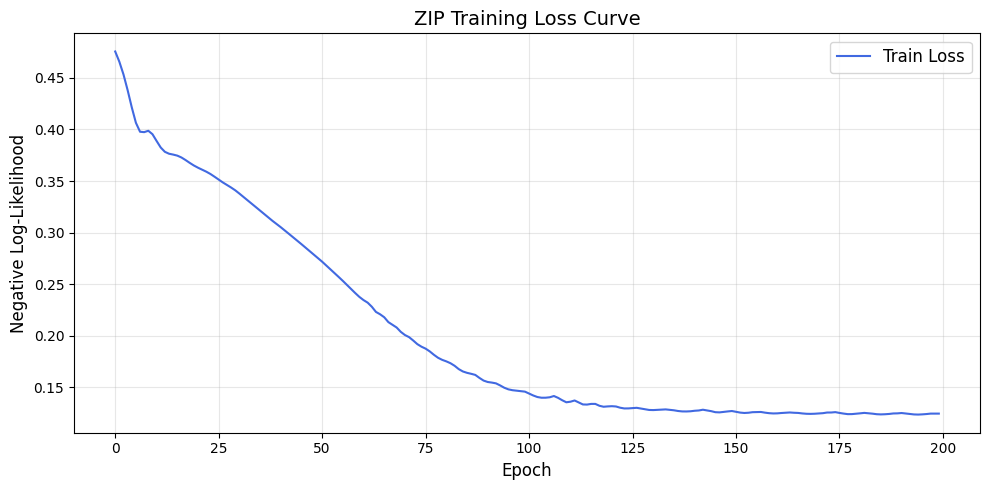


Evaluation Metrics:
- Test Loss: 1.0538
- MAE: 0.1843
- Mean p(zero): 0.7568
- Mean λ: 0.0855

Prediction Examples:
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0
True:  0.0 | Pred:    0

Advanced Prediction Statistics:
- MAE: 0.1843
- RMSE: 0.5523
- True Zero Rate: 88.25%
- Predicted Zero Rate: 96.08%

Prediction Distribution:
  Mean: 0.07
  Std: 0.45
  Min/Max: 0/6
  Percentiles (25/50/75/90/95): [0. 0. 0. 0. 0.]


In [ ]:
def train_evaluate_zip(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                       hidden_dim=32, epochs=100, lr=0.005, verbose=True, plot=True):
    """
    Complete ZIP training and evaluation workflow.
    """
    input_dim = X_train_tensor.shape[1]
    model = ZeroInflatedNN_Poisson(input_dim=input_dim, hidden_dim=hidden_dim)
    
    trained_model, train_losses = train_zip(
        model=model,
        X_train=X_train_tensor,
        y_train=y_train_tensor,
        epochs=epochs,
        lr=lr,
        verbose=verbose,
        early_stopping=True,
        patience=20
    )
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', color='royalblue')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Negative Log-Likelihood', fontsize=12)
        plt.title('ZIP Training Loss Curve', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    test_results = evaluate_zip(
        model=trained_model,
        X_test=X_test_tensor,
        y_test=y_test_tensor,
        verbose=verbose
    )
    
    y_pred_int = np.round(test_results['predictions']).astype(int)
    y_true = y_test_tensor.cpu().numpy()
    
    test_results['additional_metrics'] = {
        'mae': mean_absolute_error(y_true, y_pred_int),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred_int)),
        'zero_pred_rate': (y_pred_int == 0).mean(),
        'true_zero_rate': (y_true == 0).mean(),
        'prediction_stats': {
            'mean': y_pred_int.mean(),
            'std': y_pred_int.std(),
            'min': y_pred_int.min(),
            'max': y_pred_int.max(),
            'percentiles': np.percentile(y_pred_int, [25, 50, 75, 90, 95])
        }
    }
    
    if verbose:
        print("\nAdvanced Prediction Statistics:")
        print(f"- MAE: {test_results['additional_metrics']['mae']:.4f}")
        print(f"- RMSE: {test_results['additional_metrics']['rmse']:.4f}")
        print(f"- True Zero Rate: {test_results['additional_metrics']['true_zero_rate']:.2%}")
        print(f"- Predicted Zero Rate: {test_results['additional_metrics']['zero_pred_rate']:.2%}")
        print("\nPrediction Distribution:")
        print(f"  Mean: {test_results['additional_metrics']['prediction_stats']['mean']:.2f}")
        print(f"  Std: {test_results['additional_metrics']['prediction_stats']['std']:.2f}")
        print(f"  Min/Max: {test_results['additional_metrics']['prediction_stats']['min']}/{test_results['additional_metrics']['prediction_stats']['max']}")
        print(f"  Percentiles (25/50/75/90/95): {test_results['additional_metrics']['prediction_stats']['percentiles'].round(2)}")
    
    return {
        'model': trained_model,
        'train_losses': train_losses,
        'test_results': test_results,
        'predictions': y_pred_int
    }

# Usage example:
results = train_evaluate_zip(
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    hidden_dim=32,
    epochs=200,
    lr=0.005
)

# Access results:
trained_model = results['model']
y_pred_int = results['predictions']
test_metrics = results['test_results']['additional_metrics']


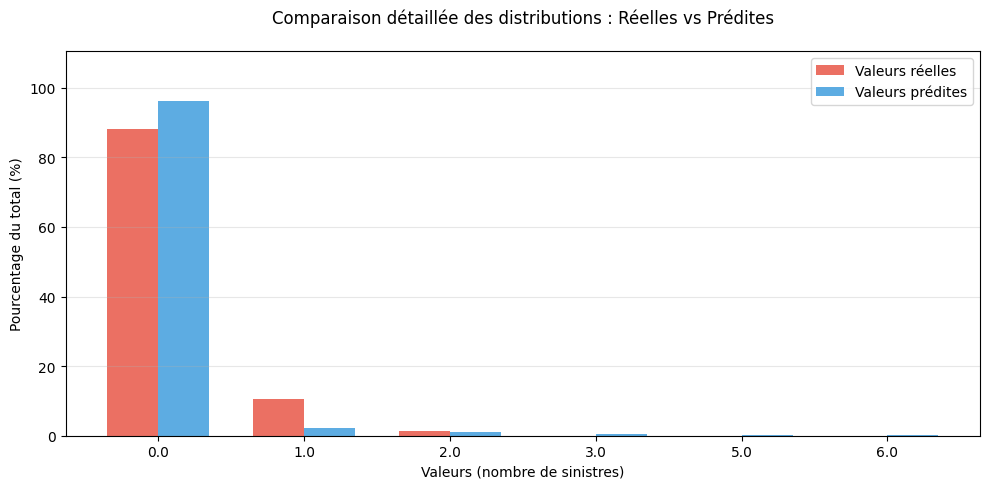


Analyse détaillée des proportions:
Valeur   | Réelles      | Prédites     | Écart (%)  | Remarque
-----------------------------------------------------------------
0.0      |      88.25% |      96.08% |      +7.83% | 
1.0      |      10.44% |       2.12% |      -8.32% | 
2.0      |       1.31% |       0.98% |      -0.33% | 
3.0      |       0.00% |       0.49% |      +0.49% | ⚠️ absente dans les vraies
5.0      |       0.00% |       0.16% |      +0.16% | ⚠️ absente dans les vraies
6.0      |       0.00% |       0.16% |      +0.16% | ⚠️ absente dans les vraies

Analyse des zéros :
- Taux de zéros (réels)   : 88.25%
- Taux de zéros (prédits) : 96.08%
- Écart                    : +7.83%


In [ ]:
# 1. Prédictions du modèle (en supposant que le modèle retourne 2 valeurs : p_zero et mu)
with torch.no_grad():
    p_zero, mu = trained_model(X_test_tensor)  # Il n'y a que 2 valeurs ici
    y_pred_mean = (1 - p_zero) * mu
    y_pred_int = torch.round(y_pred_mean).long()

    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred_int.cpu().numpy()

# 2. Analyse des distributions
unique_vals_real, counts_real = np.unique(y_test_np, return_counts=True)
unique_vals_pred, counts_pred = np.unique(y_pred_np, return_counts=True)
all_values = np.sort(np.unique(np.concatenate([unique_vals_real, unique_vals_pred])))

# 3. Fréquences relatives
real_props = counts_real / len(y_test_np) * 100
pred_props = counts_pred / len(y_pred_np) * 100

# 4. Plot comparatif
plt.figure(figsize=(10, 5))
bar_width = 0.35
x_pos = np.arange(len(all_values))

plt.bar(x_pos - bar_width/2,
        [real_props[unique_vals_real == v][0] if v in unique_vals_real else 0 for v in all_values],
        width=bar_width,
        label='Valeurs réelles',
        color='#e74c3c',
        alpha=0.8)

plt.bar(x_pos + bar_width/2,
        [pred_props[unique_vals_pred == v][0] if v in unique_vals_pred else 0 for v in all_values],
        width=bar_width,
        label='Valeurs prédites',
        color='#3498db',
        alpha=0.8)

plt.title("Comparaison détaillée des distributions : Réelles vs Prédites", pad=20)
plt.xlabel("Valeurs (nombre de sinistres)")
plt.ylabel("Pourcentage du total (%)")
plt.xticks(x_pos, all_values)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(np.max(real_props), np.max(pred_props)) * 1.15)
plt.tight_layout()
plt.show()

# 5. Comparaison textuelle détaillée
print("\nAnalyse détaillée des proportions:")
print(f"{'Valeur':<8} | {'Réelles':<12} | {'Prédites':<12} | {'Écart (%)':<10} | Remarque")
print("-" * 65)
for val in all_values:
    real_pct = (y_test_np == val).mean() * 100
    pred_pct = (y_pred_np == val).mean() * 100
    diff = pred_pct - real_pct
    note = ""
    if val not in unique_vals_real:
        note = "⚠️ absente dans les vraies"
    elif val not in unique_vals_pred:
        note = "⚠️ absente dans les prédictions"
    print(f"{val:<8} | {real_pct:>10.2f}% | {pred_pct:>10.2f}% | {diff:>+10.2f}% | {note}")

# 6. Résumé sur les zéros
zero_real = (y_test_np == 0).mean() * 100
zero_pred = (y_pred_np == 0).mean() * 100
print("\nAnalyse des zéros :")
print(f"- Taux de zéros (réels)   : {zero_real:.2f}%")
print(f"- Taux de zéros (prédits) : {zero_pred:.2f}%")
print(f"- Écart                    : {zero_pred - zero_real:+.2f}%")


/tmp/ipykernel_439800/3057211847.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero,


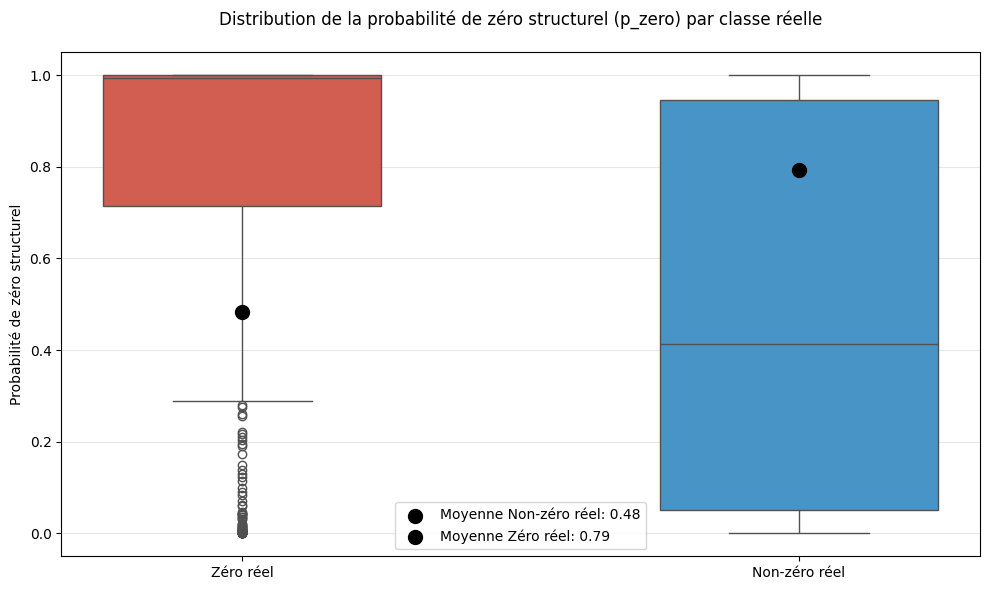


Analyse statistique de p_zero par classe:
               count    mean     std  min     25%     50%     75%  max
Classe réelle                                                         
Non-zéro réel   72.0  0.4842  0.4160  0.0  0.0505  0.4122  0.9462  1.0
Zéro réel      541.0  0.7931  0.3412  0.0  0.7146  0.9945  0.9999  1.0

Rapport de classification (seuil=0.5):
              precision    recall  f1-score   support

    Non-zéro       0.26      0.53      0.35        72
        Zéro       0.93      0.80      0.86       541

    accuracy                           0.77       613
   macro avg       0.59      0.66      0.60       613
weighted avg       0.85      0.77      0.80       613



In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# 1. Prédictions du modèle
with torch.no_grad():
    # Ajustement en fonction de ce que ton modèle retourne
    p_zero_test, mu_test = trained_model(X_test_tensor)  # Si le modèle ne retourne que 2 valeurs
    p_zero_test_np = p_zero_test.squeeze().cpu().numpy()  # Conversion en numpy array
    y_test_np = y_test_tensor.cpu().numpy()

# 2. Création du DataFrame pour la visualisation
df_pzero = pd.DataFrame({
    "p_zero": p_zero_test_np,
    "Classe réelle": np.where(y_test_np == 0, "Zéro réel", "Non-zéro réel")
})

# 3. Boxplot amélioré avec les moyennes
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Classe réelle", y="p_zero", data=df_pzero, 
                 palette=["#e74c3c", "#3498db"], width=0.5)

# Calcul des moyennes et ajout des points moyens
means = df_pzero.groupby("Classe réelle")["p_zero"].mean()
for i, (cls, mean) in enumerate(means.items()):
    ax.scatter(i, mean, color='black', zorder=5, s=100, label=f'Moyenne {cls}: {mean:.2f}')

plt.title("Distribution de la probabilité de zéro structurel (p_zero) par classe réelle", pad=20)
plt.ylabel("Probabilité de zéro structurel")
plt.xlabel("")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Analyse statistique de p_zero
print("\nAnalyse statistique de p_zero par classe:")
stats = df_pzero.groupby("Classe réelle")["p_zero"].describe().round(4)
print(stats)

# 5. Rapport de classification basé sur un seuil de 0.5
y_pred_zero = (p_zero_test_np > 0.5).astype(int)  # Seuil de 0.5 pour prédire les zéros
y_true_zero = (y_test_np == 0).astype(int)  # Conversion des vraies classes de sinistre en 0 et 1

print("\nRapport de classification (seuil=0.5):")
print(classification_report(y_true_zero, y_pred_zero, 
                            target_names=["Non-zéro", "Zéro"]))


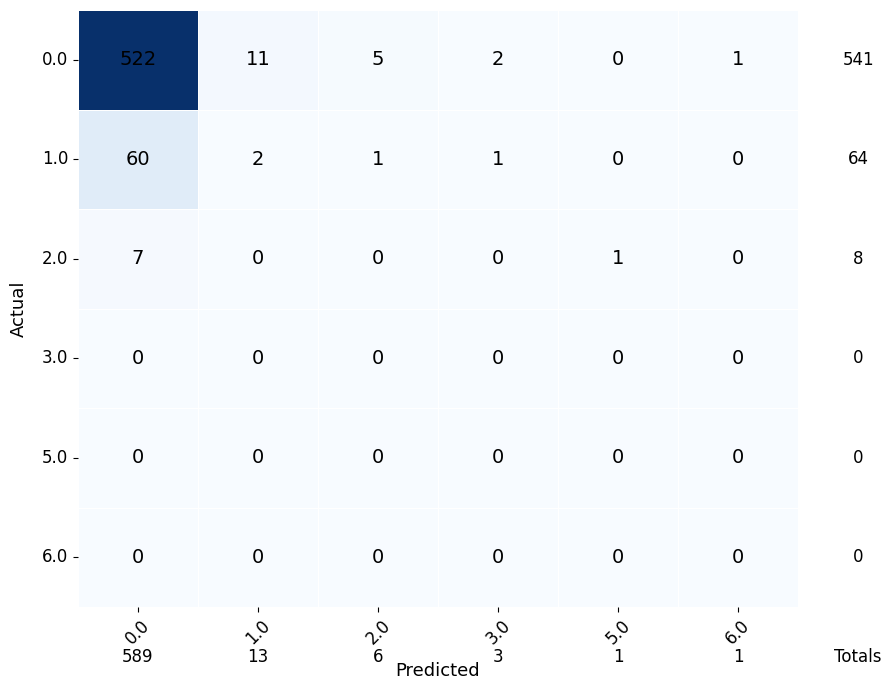


Classification Report:
              precision    recall  f1-score   support

   Class 0.0       0.89      0.96      0.92       541
   Class 1.0       0.15      0.03      0.05        64
   Class 2.0       0.00      0.00      0.00         8
   Class 3.0       0.00      0.00      0.00         0
   Class 5.0       0.00      0.00      0.00         0
   Class 6.0       0.00      0.00      0.00         0

    accuracy                           0.85       613
   macro avg       0.17      0.17      0.16       613
weighted avg       0.80      0.85      0.82       613


Class Distribution:
Class      | Actual     | Predicted  | Correct   
------------------------------------------------------------
0.0        | 541        | 589        | 522       
1.0        | 64         | 13         | 2         
2.0        | 8          | 6          | 0         
3.0        | 0          | 3          | 0         
5.0        | 0          | 1          | 0         
6.0        | 0          | 1          | 0         


/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy if they're tensors
y_test_np = y_test_tensor.numpy() if isinstance(y_test_tensor, torch.Tensor) else y_test_tensor
y_pred_np = y_pred_int.numpy() if isinstance(y_pred_int, torch.Tensor) else y_pred_int

# Get all classes present
classes = np.unique(np.concatenate([y_test_np, y_pred_np]))
classes.sort()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=classes)

# Clean Confusion Matrix Visualization
plt.figure(figsize=(9, 7))

# Create clean confusion matrix
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    linewidths=0.5, 
    linecolor='white',
    annot_kws={"size": 14, "color": "black"}
)

# Remove all titles and labels we don't need
ax.set_xticklabels(classes, fontsize=12, rotation=45)
ax.set_yticklabels(classes, fontsize=12, rotation=0)
ax.set_xlabel("Predicted", fontsize=13, labelpad=10)
ax.set_ylabel("Actual", fontsize=13, labelpad=10)

# Add clean total labels
for i in range(len(classes)):
    # Right-side totals (actual counts)
    ax.text(
        len(classes)+0.5, i+0.5, 
        f"{cm[i,:].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )
    # Bottom totals (predicted counts)
    ax.text(
        i+0.5, len(classes)+0.5, 
        f"{cm[:,i].sum()}",
        ha='center', 
        va='center', 
        fontsize=12
    )

ax.text(
    len(classes)+0.5, len(classes)+0.5, 
    "Totals",
    ha='center', 
    va='center', 
    fontsize=12
)

plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_np, y_pred_np, target_names=[f"Class {c}" for c in classes]))

# Print class distribution
print("\n" + "="*60)
print("Class Distribution:")
print("="*60)
print(f"{'Class':<10} | {'Actual':<10} | {'Predicted':<10} | {'Correct':<10}")
print("-"*60)
for i, cls in enumerate(classes):
    correct = cm[i,i]
    actual = cm[i,:].sum()
    predicted = cm[:,i].sum()
    print(f"{cls:<10} | {actual:<10} | {predicted:<10} | {correct:<10}")


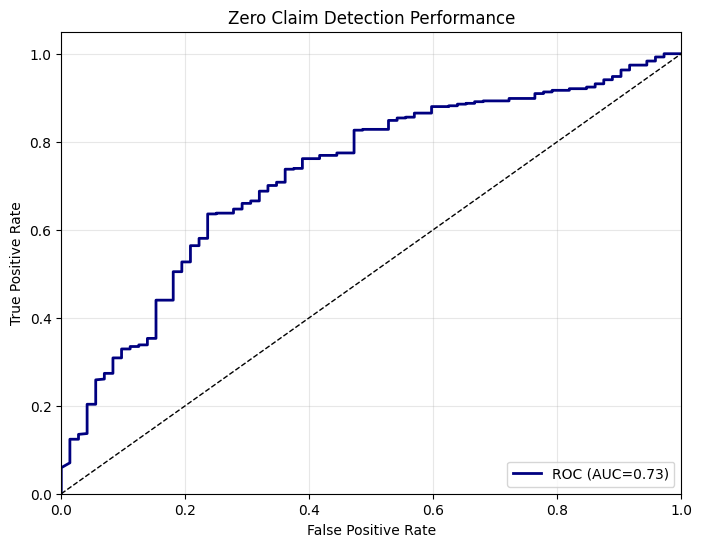

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1. Get proper predictions
with torch.no_grad():
    p_zero_test = trained_model(X_test_tensor)[0].squeeze().cpu().numpy()
y_test_binary = (y_test_tensor.cpu().numpy() == 0).astype(int)

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, p_zero_test)
roc_auc = auc(fpr, tpr)

# 3. Find optimal threshold (Youden's J)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 4. Plot with clear annotations
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zero Claim Detection Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

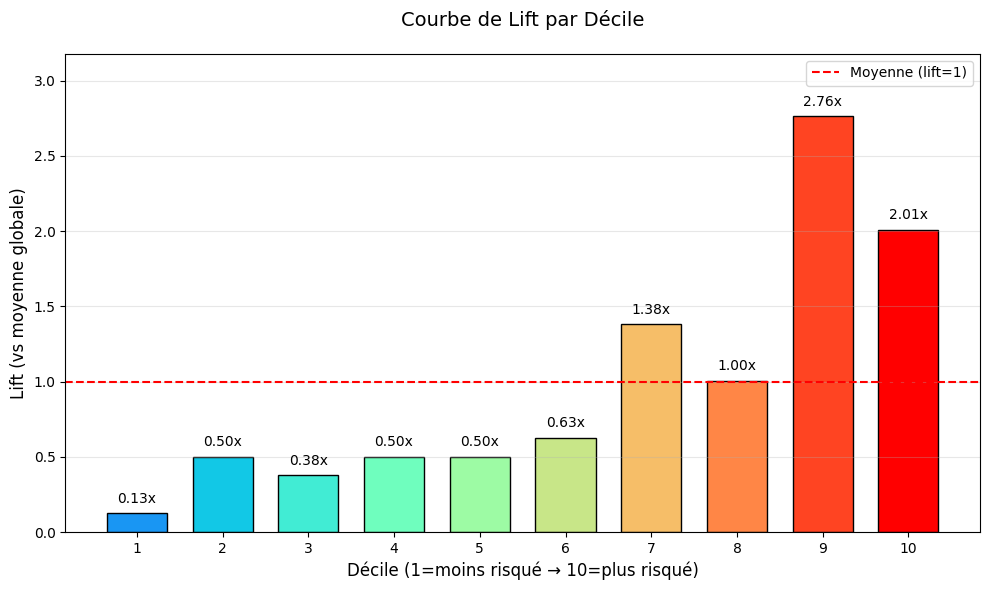

In [ ]:
def calculate_and_plot_lift_vertical(model, X_test, y_test, n_deciles=10):
    """
    Courbe de lift verticale avec déciles 1 (moins bien) à 10 (mieux classés)
    """
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    
    # Prédictions
    model.eval()
    with torch.no_grad():
        p_zero, lambda_ = model(X_test)
        risk_scores = (1 - p_zero) * lambda_
        
    risk_scores = risk_scores.cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    # Tri du MOINS risqué (décile 1) au PLUS risqué (décile 10)
    sorted_indices = np.argsort(risk_scores)  # Ascendant pour 1=moins risqué
    sorted_y_true = y_true[sorted_indices]
    
    # Déciles
    decile_size = len(y_true) // n_deciles
    decile_stats = []
    overall_mean = y_true.mean()
    
    for i in range(n_deciles):
        start = i * decile_size
        end = (i+1) * decile_size
        decile_y_true = sorted_y_true[start:end]
        decile_mean = decile_y_true.mean()
        
        decile_stats.append({
            'decile': i+1,
            'mean_actual': decile_mean,
            'lift': decile_mean / overall_mean
        })
    
    df_lift = pd.DataFrame(decile_stats)
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    colors = plt.cm.rainbow(np.linspace(0.2, 1, n_deciles))  # Palette claire
    
    bars = plt.bar(
        df_lift['decile'], 
        df_lift['lift'], 
        color=colors,
        edgecolor='black',
        width=0.7
    )
    
    # Annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.05,
            f'{height:.2f}x',
            ha='center',
            va='bottom',
            fontsize=10
        )
    
    plt.axhline(1, color='red', linestyle='--', label='Moyenne (lift=1)')
    plt.xlabel('Décile (1=moins risqué → 10=plus risqué)', fontsize=12)
    plt.ylabel('Lift (vs moyenne globale)', fontsize=12)
    plt.title('Courbe de Lift par Décile', fontsize=14, pad=20)
    plt.xticks(range(1, n_deciles+1))
    plt.ylim(0, max(df_lift['lift']) * 1.15)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return df_lift

# Exécution
df_lift = calculate_and_plot_lift_vertical(
    model=results['model'],
    X_test=X_test_tensor,
    y_test=y_test_tensor
)